In [1]:
# Importing all necessary modules and functions

%run src/utils/modules_utils.py

In [2]:
# Suppress certain warnings
warnings.filterwarnings("ignore")

In [3]:
# Data Loading and Cleaning part (One could check the script, every details and parts are described in it or in the copy of the Jupyter Notebook that is on the main branch

%run src/data/data_loading_and_cleaning.py

After loading and cleaning, we want to see how users of each database are distributed among countries. Througout our analyses, we merged, filtered and sometimes added columns to the data.

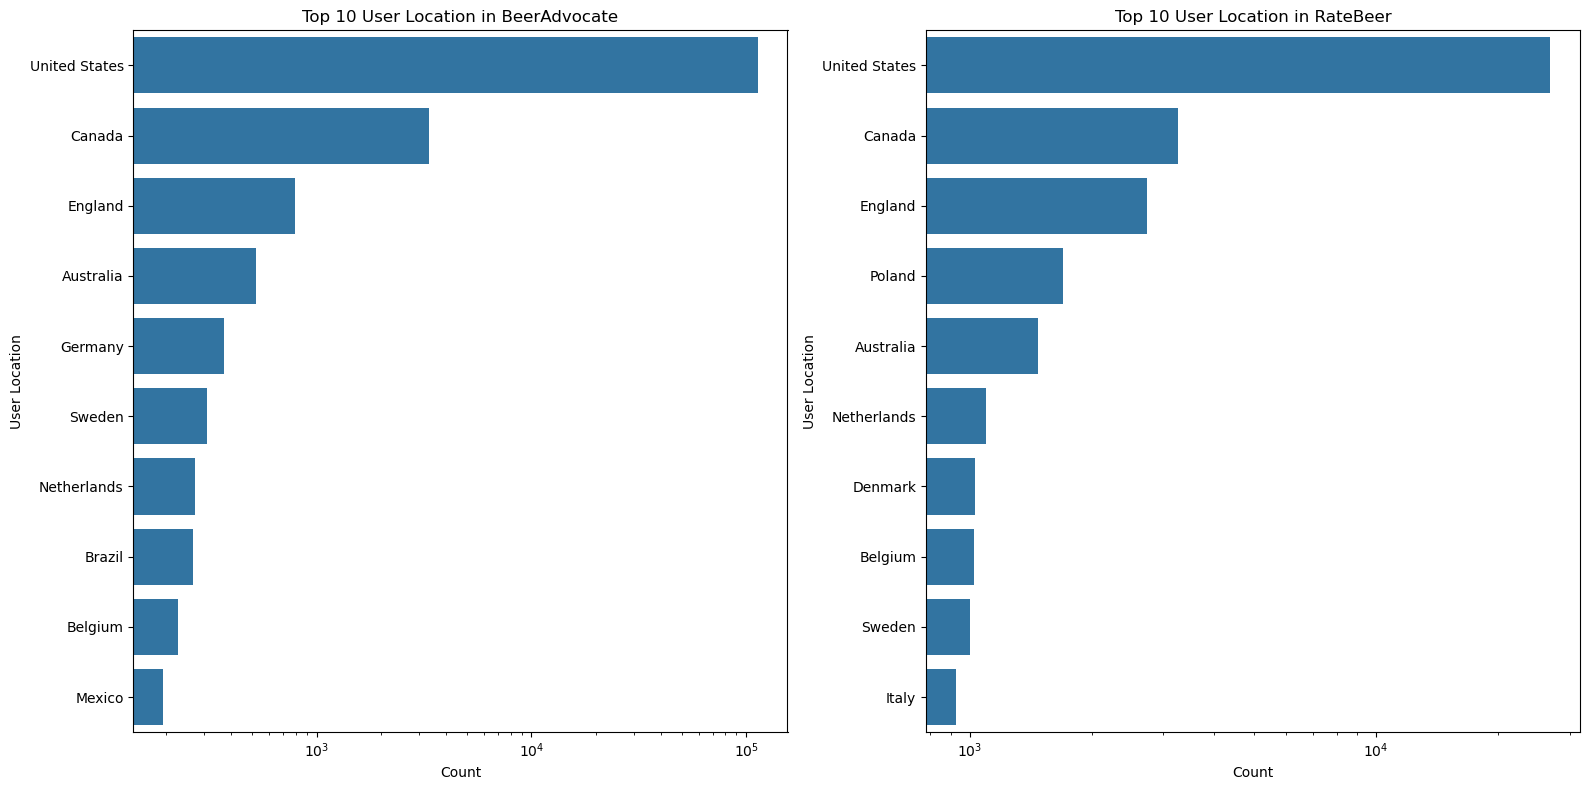

In [4]:
# Distribution of user locations
# 10 most frequent user locations for each dataset (to make plots easier to read)
ba_top_10_user_locations = ba_users[ba_users['location'] != 'nan']['location'].value_counts().head(10)
rb_top_10_user_locations = rb_users[rb_users['location'] != 'nan']['location'].value_counts().head(10)

top_10_plots(ba_top_10_user_locations,rb_top_10_user_locations,'User Location') # Plot function

We can see that for the 2 websites, the vast majority of users come from the US. The next most common user locations are Canada and England.

Let us now observe the distribution of brewery locations.

In [5]:
print('Number of distinct brewery locations:',pd.concat([ba_breweries['location'],rb_breweries['location']]).nunique())

Number of distinct brewery locations: 218


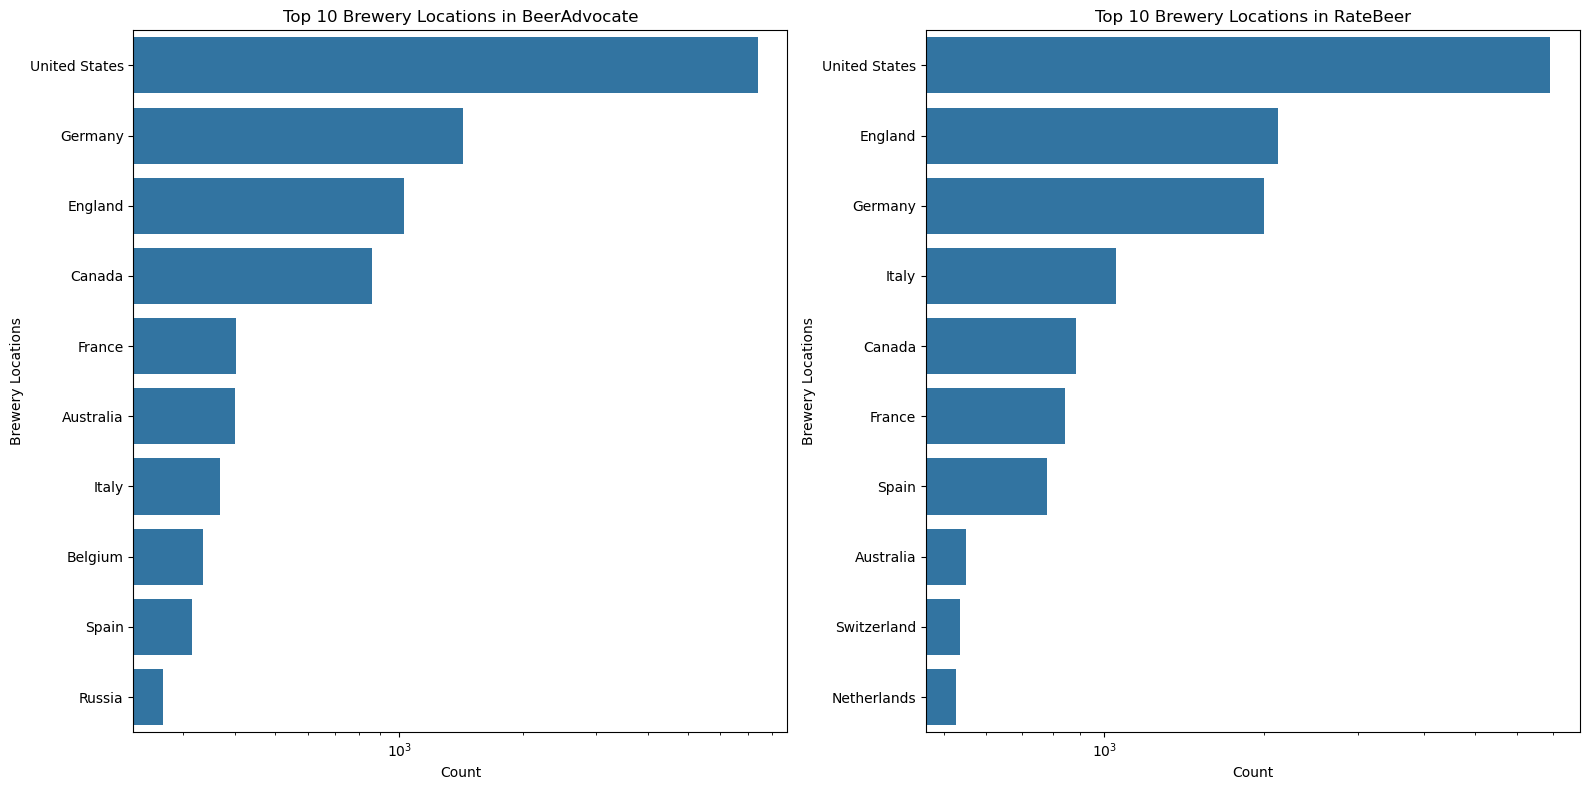

In [6]:
# Distribution of brewery locations
# 10 most frequent brewery locations for each dataset (to make plots easier to read)
ba_top_10_brewery_locations = ba_breweries[ba_breweries['location'] != 'nan']['location'].value_counts().head(10)
rb_top_10_brewery_locations = rb_breweries[rb_breweries['location'] != 'nan']['location'].value_counts().head(10)

top_10_plots(ba_top_10_brewery_locations,rb_top_10_brewery_locations,'Brewery Locations')

Similarly, we can observe that the vast majority of breweries included in the 2 datasets are located in the US. The next most common brewery locations are Germany and England.

## Adding brewery location information to filtered review DataFrames

Finally, to facilitate our analysis, we will add the brewery location information for each beer reviewed in the review dataframes. 

In [7]:
ba_breweries_loc_filtered = ba_breweries.copy()
rb_breweries_loc_filtered = rb_breweries.copy()

In [8]:
# rename 'id' column to 'brewerie_id' column in brewery dataframes to facilitate merging with rating dataframes
ba_breweries_loc_filtered = ba_breweries_loc_filtered.rename(columns={'id': 'brewery_id'})
rb_breweries_loc_filtered = rb_breweries_loc_filtered.rename(columns={'id': 'brewery_id'})

# merge rating dataframes with brewery dataframes on 'brewery_id' to add the'location' column to rating dataframes as 'brewerie_location'

# Beer Advocate
ba_ratings_loc_filtered = ba_ratings_loc_filtered.merge(ba_breweries_loc_filtered[['brewery_id', 'location']], on='brewery_id', how='left')
ba_ratings_loc_filtered = ba_ratings_loc_filtered.rename(columns={'location': 'brewery_location'})

# Rate Beer
rb_ratings_loc_filtered = rb_ratings_loc_filtered.merge(rb_breweries_loc_filtered[['brewery_id', 'location']], on='brewery_id', how='left')
rb_ratings_loc_filtered = rb_ratings_loc_filtered.rename(columns={'location': 'brewery_location'})

ba_ratings_loc_filtered.head()

beer_name   beer_id                               brewery_name  \
0          Régab  142544.0  Societe des Brasseries du Gabon (SOBRAGA)   
1  Barelegs Brew   19590.0       Strangford Lough Brewing Company Ltd   
2  Barelegs Brew   19590.0       Strangford Lough Brewing Company Ltd   
3  Barelegs Brew   19590.0       Strangford Lough Brewing Company Ltd   
4  Barelegs Brew   19590.0       Strangford Lough Brewing Company Ltd   

   brewery_id             style  abv                date        user_name  \
0     37262.0   Euro Pale Lager  4.5 2015-08-20 10:00:00          nmann08   
1     10093.0  English Pale Ale  4.5 2009-02-20 11:00:00      StJamesGate   
2     10093.0  English Pale Ale  4.5 2006-03-13 11:00:00          mdagnew   
3     10093.0  English Pale Ale  4.5 2004-12-01 11:00:00  helloloser12345   
4     10093.0  English Pale Ale  4.5 2004-08-30 10:00:00       cypressbob   

                 user_id  appearance  ...  palate  taste  overall  rating  \
0         nmann08.184925        3.25  ...    3.25   2.75      3.0    2.88   
1     stjamesgate.163714        3.00  ...    3.50   4.00      3.5    3.67   
2          mdagnew.19527        4.00  ...    3.50   4.00      3.5    3.73   
3  helloloser12345.10867        4.00  ...    4.00   4.00      4.5    3.98   
4        cypressbob.3708        4.00  ...    4.00   4.00      4.0    4.00   

   user_avg_rating  brewery_avg_rating  style_avg_rating  user_nb_reviews  \
0         3.730887            2.880000          2.986608            465.0   
1         3.885664            3.526513          3.542445           2504.0   
2         3.866884            3.526513          3.542445           1143.0   
3         3.563226            3.526513          3.542445             31.0   
4         3.624354            3.526513          3.542445            604.0   

      user_location  brewery_location  
0     United States             Gabon  
1     United States  Northern Ireland  
2  Northern Ireland  Northern Ireland  
3  Northern Ireland  Northern Ireland  
4  Northern Ireland  Northern Ireland  

[5 rows x 21 columns]

# 1) Link between culture and taste

## a) Beer style preferences

In this part, we examine how different beer styles are reviewed across different countries. 

- In our analysis, we approached features in two scopes: first, we started with the number of ratings of certain beer styles as features of a given country to determine if certain countries cluster together in terms of beer style preferences. Secondly, we added average ratings of each beer style from each country as an additional feature to our previous data and then reduced this fourth dimensional dataframe to third dimensional one via merging these two features. Our initial analysis in P2 showed that we should group together the countries according to their actual regions since clustering dependent on Euclidean distances between these points. Then, we used principal component analysis to reduce 3D data into 2D mapping and via unsupervised clustering algorithm (K-means), we clustered the data. An optimal number of clusters were chosen according to Silhouette and Inertia scores(Elbow Method) to find a consistent one based on these two decision makers. After this step, regions were plotted with the PCA loadings. However, we cannot directly understand the regional beer preferences using PCA loadings; therefore, in each region,  we found the top 5 beer styles and plotted them as multiple bar plots. 

- In the second part, we used the time information in reviews to determine if regional beer style preferences, which were found in the previous part, remain stable over time — supporting the hypothesis that they are influenced by culture — or if they fluctuate, suggesting other contributing factors.

- Starting from P2, we made inital analyses and showed the results below which also helped that detecting the core problems and how we could proceed to find the regional preferences.

Here we concanated the two data frames together and added a source column so that we are not losing track of the origin of each rating.This data frame will be the main data frame for linear regression analysis and the clustering as it will give us the total ratings

In [9]:
total_ratings_loc_filtered = pd.concat([ba_ratings_loc_filtered, rb_ratings_loc_filtered], keys=['ba', 'rb']).reset_index(level=0).rename(columns={'level_0': 'source'})
total_ratings_loc_filtered = total_ratings_loc_filtered.reset_index(drop=True)
total_ratings_loc_filtered.head()

source      beer_name   beer_id                               brewery_name  \
0     ba          Régab  142544.0  Societe des Brasseries du Gabon (SOBRAGA)   
1     ba  Barelegs Brew   19590.0       Strangford Lough Brewing Company Ltd   
2     ba  Barelegs Brew   19590.0       Strangford Lough Brewing Company Ltd   
3     ba  Barelegs Brew   19590.0       Strangford Lough Brewing Company Ltd   
4     ba  Barelegs Brew   19590.0       Strangford Lough Brewing Company Ltd   

   brewery_id             style  abv                date        user_name  \
0     37262.0   Euro Pale Lager  4.5 2015-08-20 10:00:00          nmann08   
1     10093.0  English Pale Ale  4.5 2009-02-20 11:00:00      StJamesGate   
2     10093.0  English Pale Ale  4.5 2006-03-13 11:00:00          mdagnew   
3     10093.0  English Pale Ale  4.5 2004-12-01 11:00:00  helloloser12345   
4     10093.0  English Pale Ale  4.5 2004-08-30 10:00:00       cypressbob   

                 user_id  ...  palate  taste  overall  rating  \
0         nmann08.184925  ...    3.25   2.75      3.0    2.88   
1     stjamesgate.163714  ...    3.50   4.00      3.5    3.67   
2          mdagnew.19527  ...    3.50   4.00      3.5    3.73   
3  helloloser12345.10867  ...    4.00   4.00      4.5    3.98   
4        cypressbob.3708  ...    4.00   4.00      4.0    4.00   

   user_avg_rating  brewery_avg_rating  style_avg_rating  user_nb_reviews  \
0         3.730887            2.880000          2.986608            465.0   
1         3.885664            3.526513          3.542445           2504.0   
2         3.866884            3.526513          3.542445           1143.0   
3         3.563226            3.526513          3.542445             31.0   
4         3.624354            3.526513          3.542445            604.0   

      user_location  brewery_location  
0     United States             Gabon  
1     United States  Northern Ireland  
2  Northern Ireland  Northern Ireland  
3  Northern Ireland  Northern Ireland  
4  Northern Ireland  Northern Ireland  

[5 rows x 22 columns]

Let's start with initial statistics about the which beers and beer styles are most commonly rated in overall data. Before analyzing the beer style preferences in each country or region, we should ensure that we have enough information in the data and whether it is consistent (for example, low variance and low bias) or not for clustering.

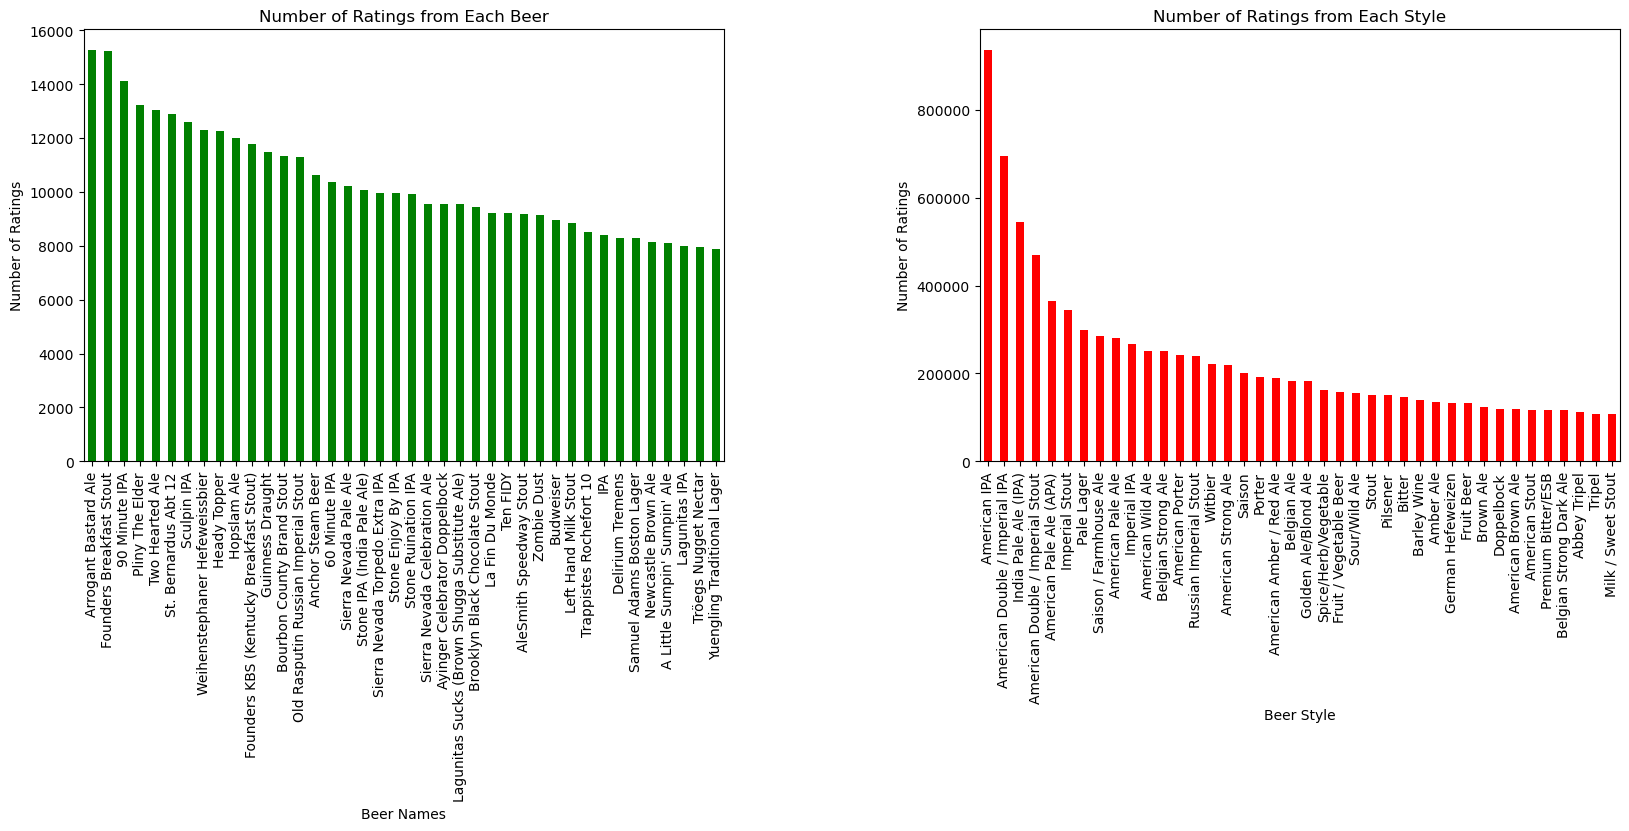

In [10]:
beer_name_values = total_ratings_loc_filtered['beer_name'].value_counts()
beer_style_values = total_ratings_loc_filtered['style'].value_counts()

plt.subplot(1,2,1)
beer_name_values[0:40].plot(kind='bar',color='g')
plt.title("Number of Ratings from Each Beer")
plt.xlabel("Beer Names")
plt.ylabel("Number of Ratings")

plt.subplot(1,2,2)
beer_style_values[0:40].plot(kind='bar',color='r')
plt.title("Number of Ratings from Each Style")
plt.xlabel("Beer Style")
plt.ylabel("Number of Ratings")

plt.subplots_adjust(left=1.5,bottom=0.1, right=3.9, top=1, wspace=0.4, hspace=2)

plt.show()

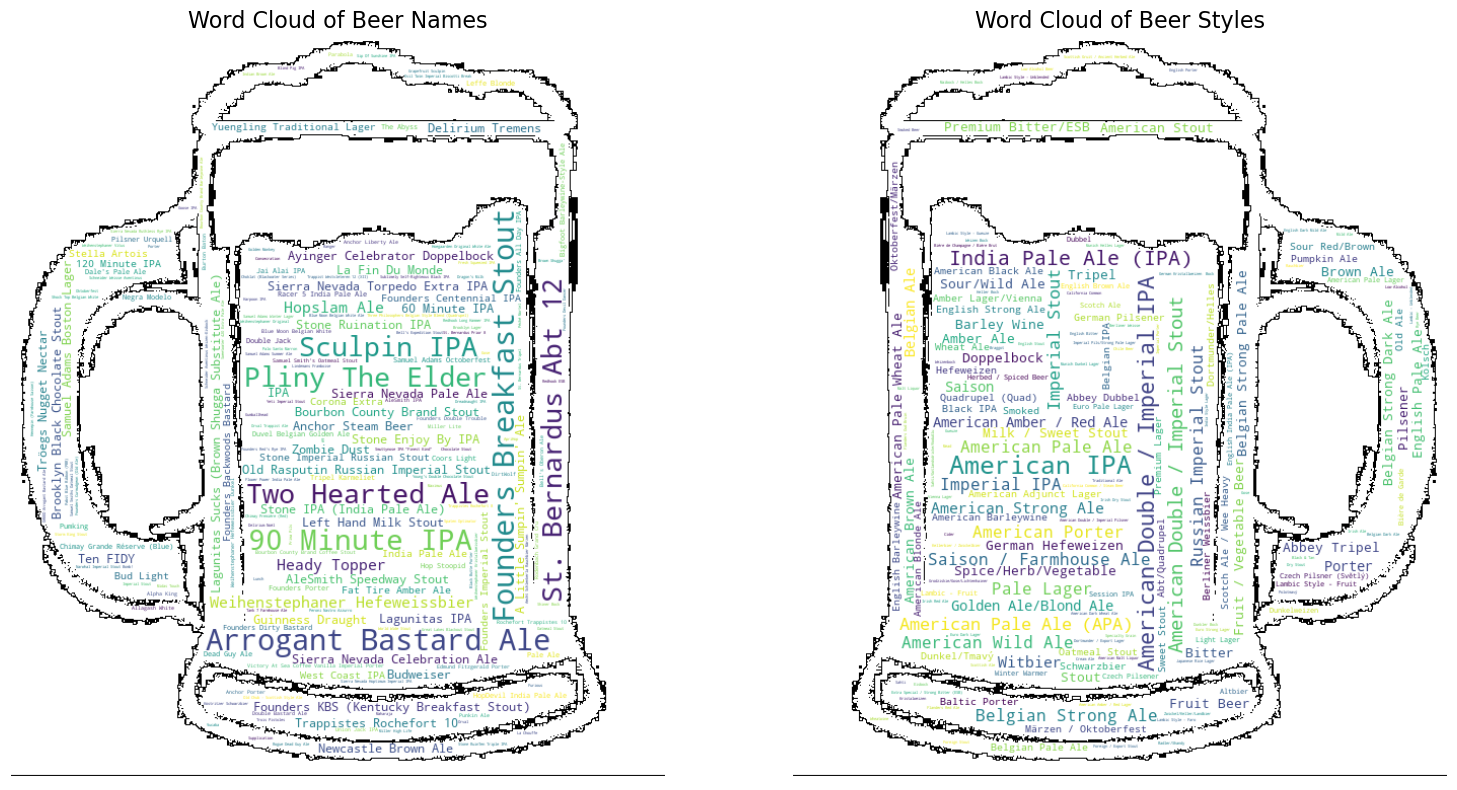

In [11]:
mask_image_path1 = "data/Oktoberfest_Beer_Mug_processed_mask_flipped.png"
mask_image_path2 = "data/Oktoberfest_Beer_Mug_processed_mask.png"

 # Generating wordclouds with the function that we wrote in data_utils

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
generate_wordcloud_from_series(beer_name_values,"Word Cloud of Beer Names", mask_image_path1, ax=axes[0] )
generate_wordcloud_from_series(beer_style_values,"Word Cloud of Beer Styles", mask_image_path2, ax=axes[1] )

plt.tight_layout()
plt.show()

The **histograms** and **word cloud maps** show that the distribution of ratings of popular beer brands and styles across the world based on BeerAdvocate and RateBeer data. In the left chart, the most-rated beer brand, "St. Bernardus Abt 12," received over 8,000 ratings, followed closely by "Guinness Draught" and other popular brands that have between 5,000 and 8,000 ratings. This partially indicates that there is almost an uniform distribution among the well-known brands. 

On the other hand, the right chart reveals that specific beer styles dominate in popularity. "American IPA" leads with over 550,000 ratings, followed by "India Pale Ale (IPA)" at around 500,000 ratings. Other styles like "Imperial Stout" and "Pale Ale" also feature prominently, with over 200,000 ratings each.

Let's further analyze the popular beer styles, for example consider the most famous one which is **'American IPA'**. Where are its ratings coming from? Is it really the most popular beer in the world or it is the leading one because of the number of users from specific regions dominate the ratings (in other words, basically it is the favorite preference of associated region)

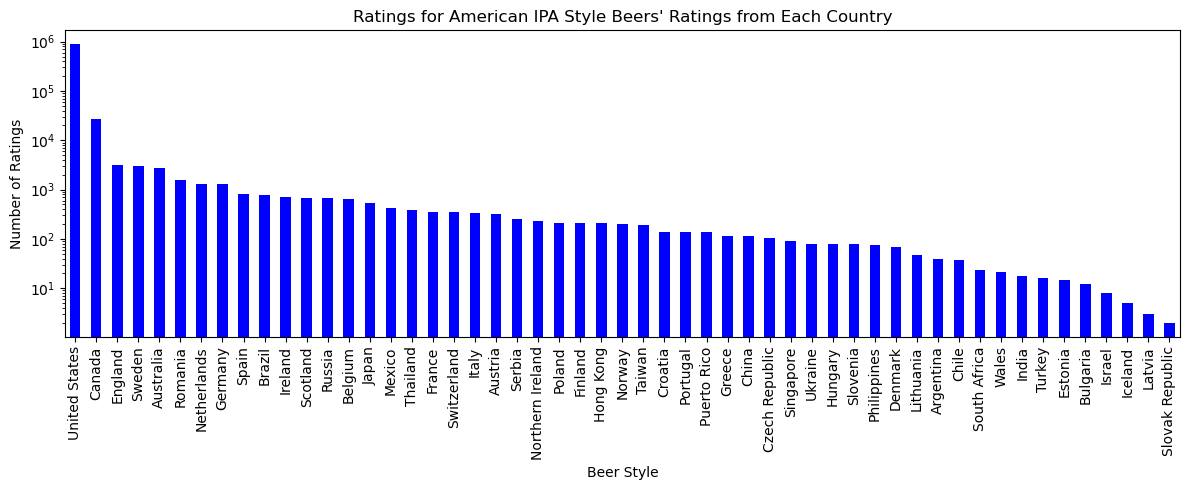

In [12]:
american_IPA_country_values = total_ratings_loc_filtered[total_ratings_loc_filtered['style'] == 'American IPA']
counts_american_IPA_values = american_IPA_country_values['user_location'].value_counts()

plt.figure(figsize=(12, 5))
counts_american_IPA_values[0:60].plot(kind='bar',color='b',logy = True)
plt.title("Ratings for American IPA Style Beers' Ratings from Each Country")
plt.xlabel("Beer Style")
plt.ylabel("Number of Ratings")
plt.tight_layout()

plt.show()

From the log scaled plot, we observe that the United States has a dominant lead in the number of ratings, reaching around 10^6 ratings, which is significantly higher than any other country. This dominance suggests that American IPA is extremely popular in its country of origin, aligning with the general preference for this style in the U.S. Following the U.S., Canada, Denmark, England, and Sweden also show notable levels of engagement, although their rating counts are much lower, in the range of 10^3 to 10^4. These countries represent regions with a strong craft beer culture, indicating that American IPA has gained substantial popularity internationally as well. The presence of other countries with moderate ratings, such as Germany, Netherlands, and Japan, suggests a widespread appreciation for this style, though at a smaller scale.

**To sum up, the chart demonstrates significant variation in preferences for the American IPA style across countries, with the United States showing an overwhelming number of ratings compared to other regions. This suggests that beer preferences are not uniform globally; instead, they exhibit clear regional patterns**

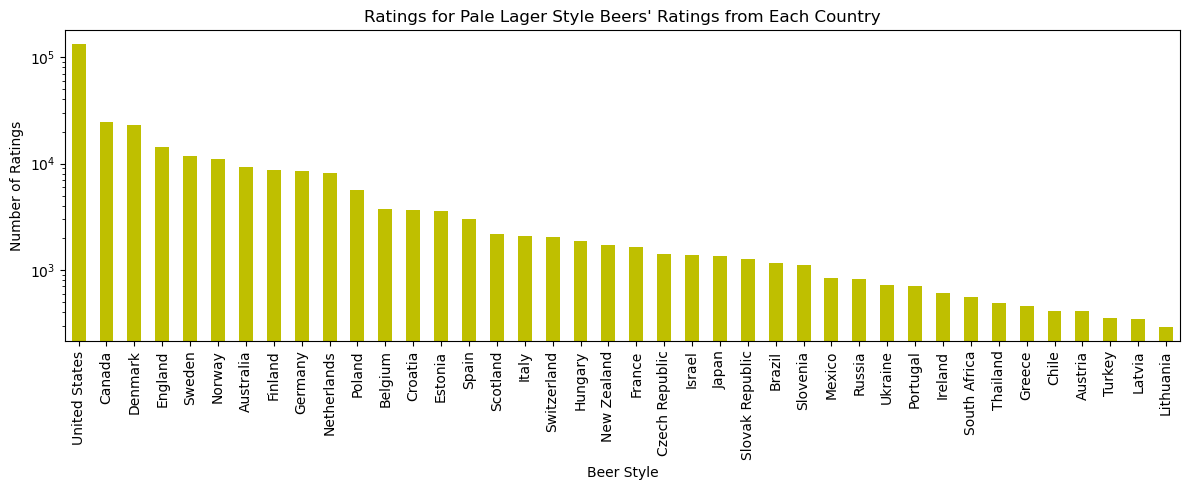

In [13]:
pale_lager_country_values = total_ratings_loc_filtered[total_ratings_loc_filtered['style'] == 'Pale Lager']
counts_pale_lager_values = pale_lager_country_values['user_location'].value_counts()

plt.figure(figsize=(12, 5))
counts_pale_lager_values[0:40].plot(kind='bar',color='y',logy = True)
plt.title("Ratings for Pale Lager Style Beers' Ratings from Each Country")
plt.xlabel("Beer Style")
plt.ylabel("Number of Ratings")
plt.tight_layout()

plt.show()

Let's also look at **Pale Lager** data which demonstrates that the difference between the U.S. and other countries is notably smaller for this beer style. European countries such as Denmark, England, Germany, and Sweden have substantial ratings even though the United States still leads with the highest number of ratings(because there are a significant number of users in particularly from U.S). This is in contrast to the American IPA style underscoring its origins and specific popularity in American craft beer culture. This distribution suggests that Pale Lager, in European countries, which have long-established beer cultures, particularly favor this style. This trend highlights the importance of considering regional preferences in beer style analysis, as Pale Lager’s popularity spans multiple regions, reflecting its acceptance as a global standard. It also underscores the need for clustering techniques to identify and analyze patterns based on these regional preferences.

**To implement the clustering to decide which beer style is most popular in each country / geographic area first considered these steps in P2**

- Determine the axes initially, in our case these are the 1) countries, 2) beer styles and 3) number of ratings. Therefore, this suggests 3D dimensional visualization.
- For the countries, region of interests should be decided, we should determine each region that includes the choosing the countries (for example, we can divide Europe in different subsets such as West/East etc.) We are planning to use K-means clustering because we do not have the labels, we want to discover & reveal patterns like regional preferences or popular beer styles in specific countries.
- Morever, simply number of ratings from each country are not enough to decide which beer style is most preferrable in the particular regions. Overall ratings, time effects should also be considered. Because of the possible dimension increase in the data, we will need to apply PCA to reduce the dimensionality of the dataset.

Let's visualize the initial data we have. First, we need to convert to data into useful frame:

In [14]:
merged_df = merge_data_(total_ratings_loc_filtered) # Merging existing data into new dataframe in order to visualize it

merged_df.head()

user_location            Argentina  Australia  Austria  Belgium  Brazil  \
Euro Pale Lager               27.0      923.0    196.0    378.0   209.0   
English Pale Ale              20.0     2803.0     94.0    414.0   274.0   
English Bitter                 1.0      483.0      8.0     65.0    42.0   
American Pale Wheat Ale        2.0      260.0     10.0     32.0    87.0   
American Blonde Ale            3.0      360.0     18.0     64.0    55.0   

user_location            Bulgaria  Canada  Chile  China  Croatia  ...  \
Euro Pale Lager              50.0  4581.0   21.0   59.0    173.0  ...   
English Pale Ale             11.0  9683.0   68.0   56.0    227.0  ...   
English Bitter                1.0  1743.0    1.0   21.0     17.0  ...   
American Pale Wheat Ale       0.0  2523.0    0.0   15.0      5.0  ...   
American Blonde Ale           2.0  3257.0    0.0    8.0      9.0  ...   

user_location            South Korea  Spain  Sweden  Switzerland  Taiwan  \
Euro Pale Lager                  0.0  449.0  1106.0        262.0    40.0   
English Pale Ale                 1.0  763.0  2885.0        307.0    51.0   
English Bitter                   0.0   83.0   329.0         36.0     8.0   
American Pale Wheat Ale          0.0   60.0   161.0         20.0    12.0   
American Blonde Ale              0.0   79.0   131.0         20.0    13.0   

user_location            Thailand  Turkey  Ukraine  United States  Wales  
Euro Pale Lager             127.0   136.0     82.0        36591.0    8.0  
English Pale Ale            163.0    34.0     56.0        67073.0   35.0  
English Bitter               32.0     4.0     15.0        16840.0   22.0  
American Pale Wheat Ale      24.0     1.0      4.0        95343.0    1.0  
American Blonde Ale          21.0     4.0      2.0        58958.0    4.0  

[5 rows x 55 columns]

Initially, we have the country names randomly distributed along the chosen axis; however, this makes clustering almost impossible and chaotic. As one can know, clustering depends on Euclidean (or it can be Non-Euclidean based on clustering method) distances. In addition to country sorting, we have 3D dimensional data which also makes clustering difficult; therefore, we implement
- Sorting the countries according to their regions (we group them using their region information from widely known classifications)
- Using Principal Component Analysis (PCA), we reduced the dimension of the data


In [15]:
country_region_mapping,merged_with_regions_sorted_0 = region_mapping(merged_df)  # To shorten Euclidean distance of the data, we manually sorted the countries and give them region labelling

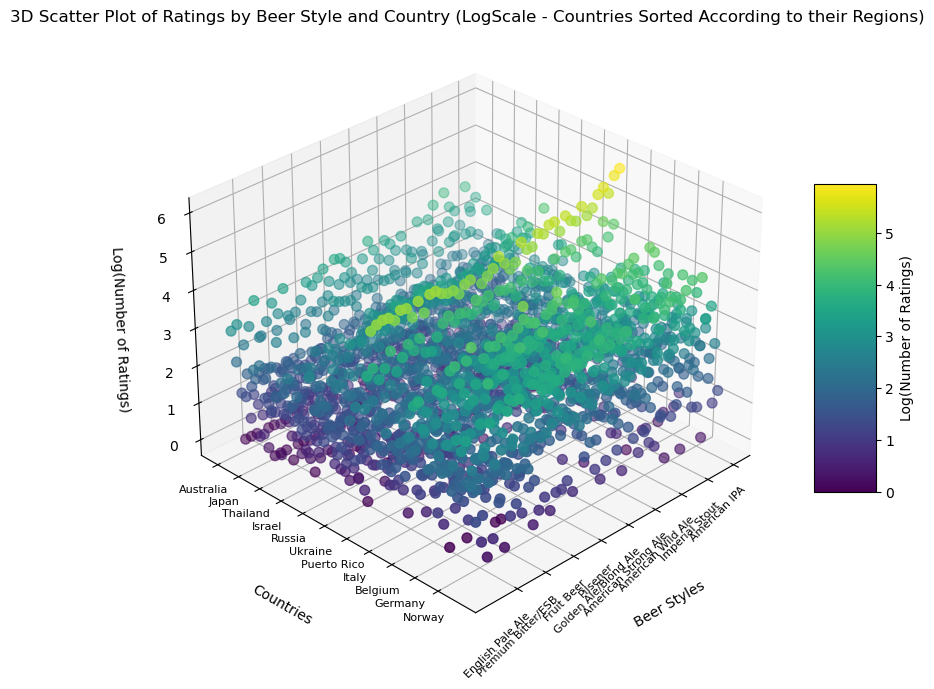

In [16]:
merged_with_regions_sorted = merged_with_regions_sorted_0[:-1]
merged_with_regions_sorted = merged_with_regions_sorted.apply(pd.to_numeric, errors='coerce')
top_styles_sorted = merged_with_regions_sorted.sum(axis=1).nlargest(45).index  # Sum ratings by style and select top 45

subset_df_ = merged_with_regions_sorted.loc[top_styles_sorted, :]

plot_3D_scatter(subset_df_,"3D Scatter Plot of Ratings by Beer Style and Country (LogScale - Countries Sorted According to their Regions)")

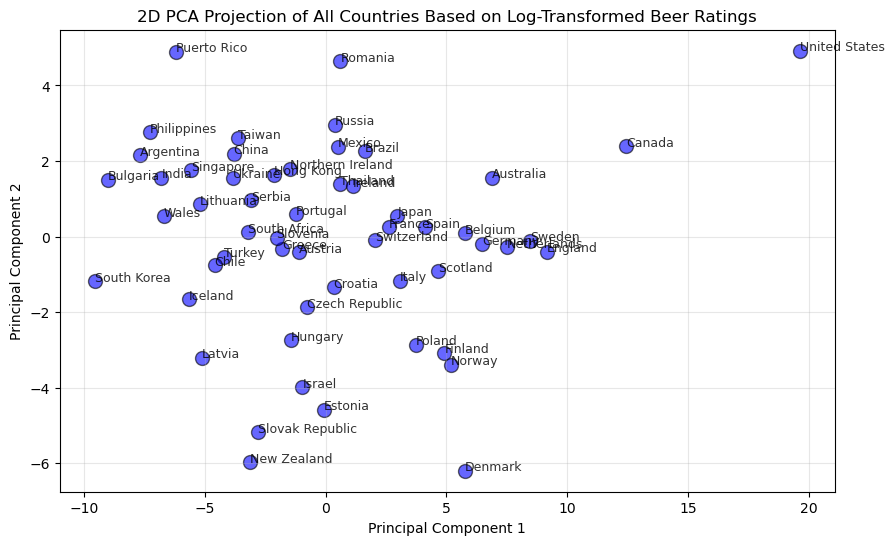

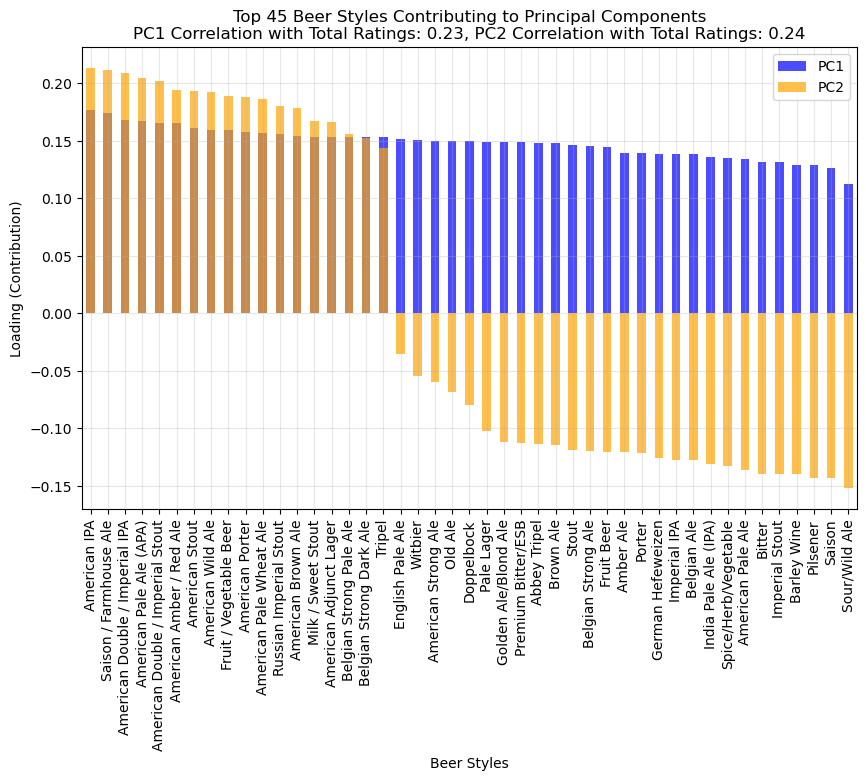

<Figure size 640x480 with 0 Axes>

In [17]:
# Apply the PCA to the our DataFrame with logarithmic scaling for all countries

pca_componentss,loadingss = plot_PCA_2D_with_loadings(subset_df_,'2D PCA Projection of All Countries Based on Log-Transformed Beer Ratings')

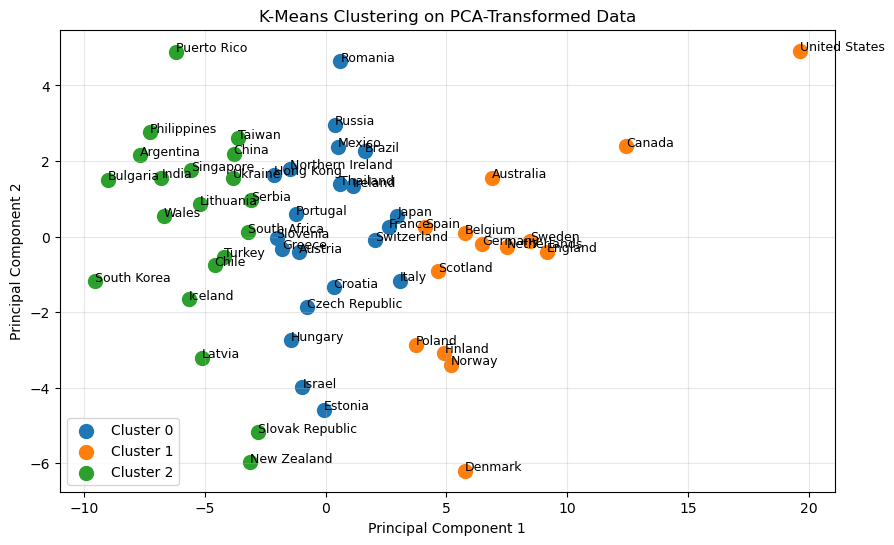

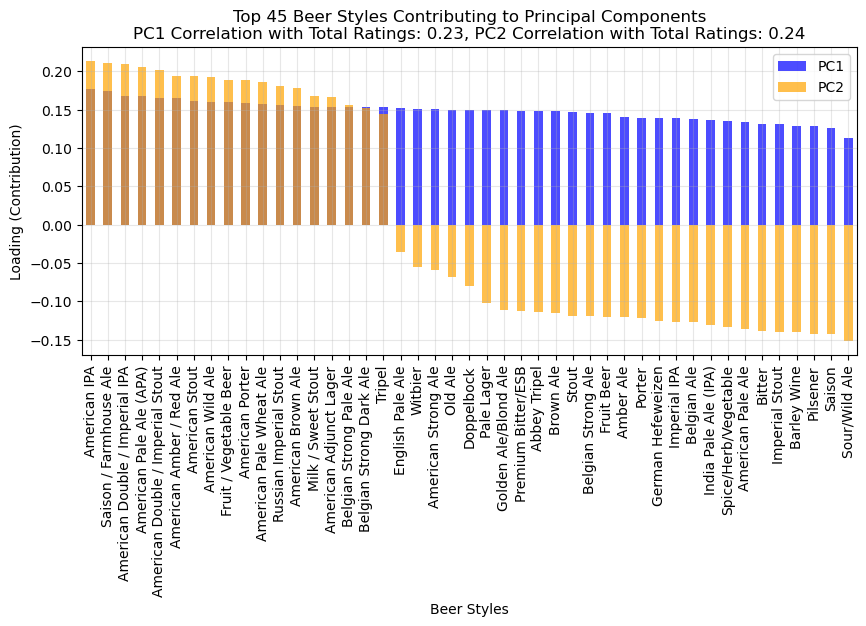

<Figure size 640x480 with 0 Axes>

In [18]:
country_names = list(subset_df_.columns)
#K-Means Clustering (Initially the number of clusters was chosen as n=3 to see how it works)

kmeans = KMeans(n_clusters=3, random_state=42)  # Choose number of clusters
clusters = kmeans.fit_predict(pca_componentss)

pca_transformed = pd.DataFrame(pca_componentss, columns=["PC1", "PC2"])
pca_transformed['Cluster'] = clusters
pca_transformed['Country'] = country_names

plt.figure(figsize=(10, 6))
plot_clusters(pca_transformed)  #Visualize the Clusters

# Calculate the correlation between the number of ratings and PCA loadings
total_ratings = subset_df_.sum(axis=1)
loadingss['Total Ratings'] = total_ratings
pc1_corr = loadingss[['PC1', 'Total Ratings']].corr().iloc[0, 1]
pc2_corr = loadingss[['PC2', 'Total Ratings']].corr().iloc[0, 1]

plt.figure(figsize=(10, 4))
plot_pca_loadings(loadingss,pc1_corr,pc2_corr)  # Plotting the PCA loadings

plt.tight_layout()
plt.show()

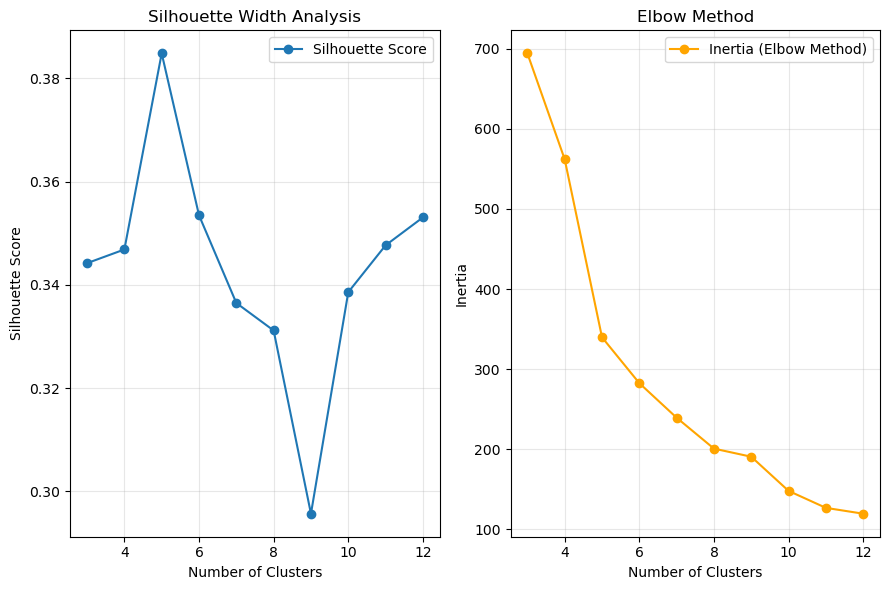

In [19]:
cluster_range = range(3, 13)  # From 3 to 12 clusters to find the optimum one
silhoutte_inertia_plotting(cluster_range,pca_componentss) # Plotting Silhouette Width and Inertia Scores

From the analysis, optimum number of clusters is chosen as **n = 5**

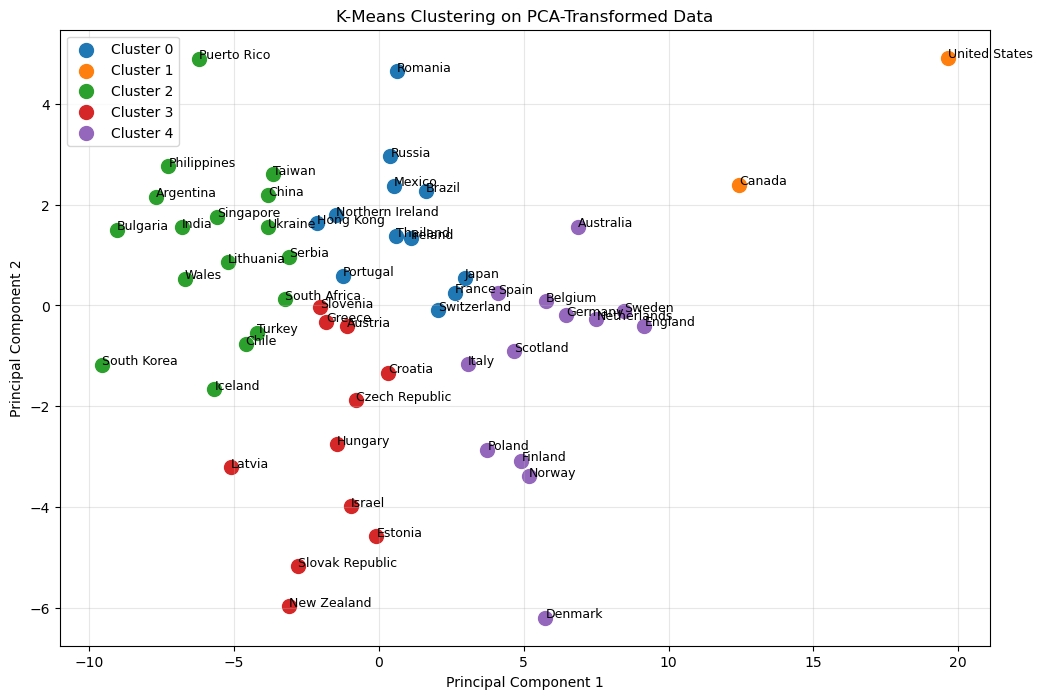

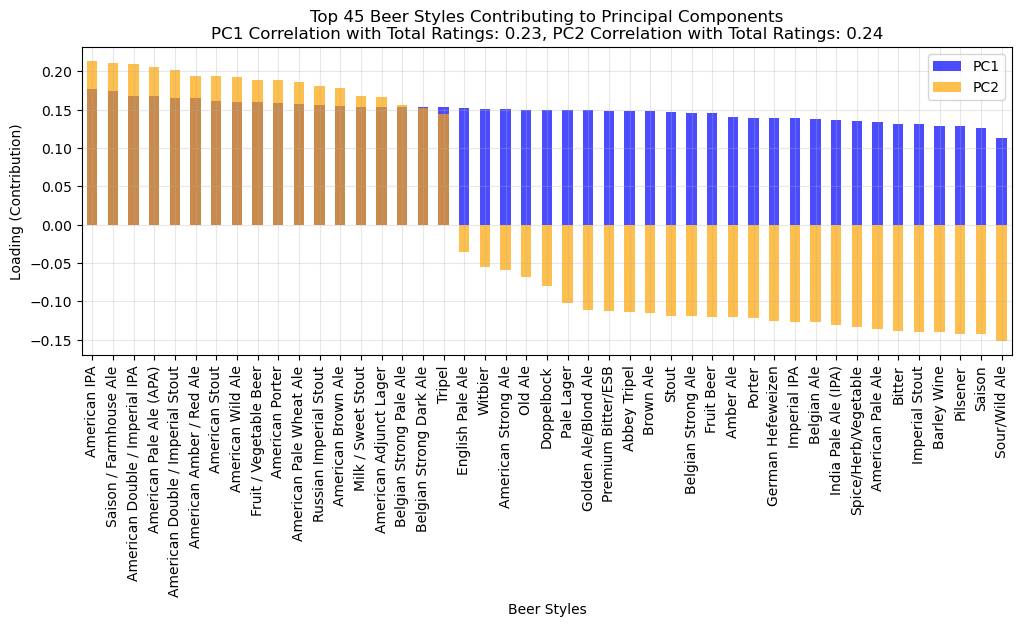

<Figure size 640x480 with 0 Axes>

In [20]:
# Extracting country names
country_names = list(subset_df_.columns)

# Perform K-Means Clustering
kmeans = KMeans(n_clusters=5, random_state=42)  # Choose number of clusters
clusters = kmeans.fit_predict(pca_componentss)

# Combine Clustering Results with Country Names
pca_transformed = pd.DataFrame(pca_componentss, columns=["PC1", "PC2"])
pca_transformed['Cluster'] = clusters
pca_transformed['Country'] = country_names


plt.figure(figsize=(12, 8))
plot_clusters(pca_transformed) # Visualize the Clusters

# Calculate the correlation between the number of ratings and PCA loadings
total_ratings = subset_df_.sum(axis=1)
loadingss['Total Ratings'] = total_ratings
pc1_corr = loadingss[['PC1', 'Total Ratings']].corr().iloc[0, 1]
pc2_corr = loadingss[['PC2', 'Total Ratings']].corr().iloc[0, 1]

plt.figure(figsize=(12, 4))
plot_pca_loadings(loadingss,pc1_corr,pc2_corr)  # Plotting the PCA loadings

plt.tight_layout()
plt.show()

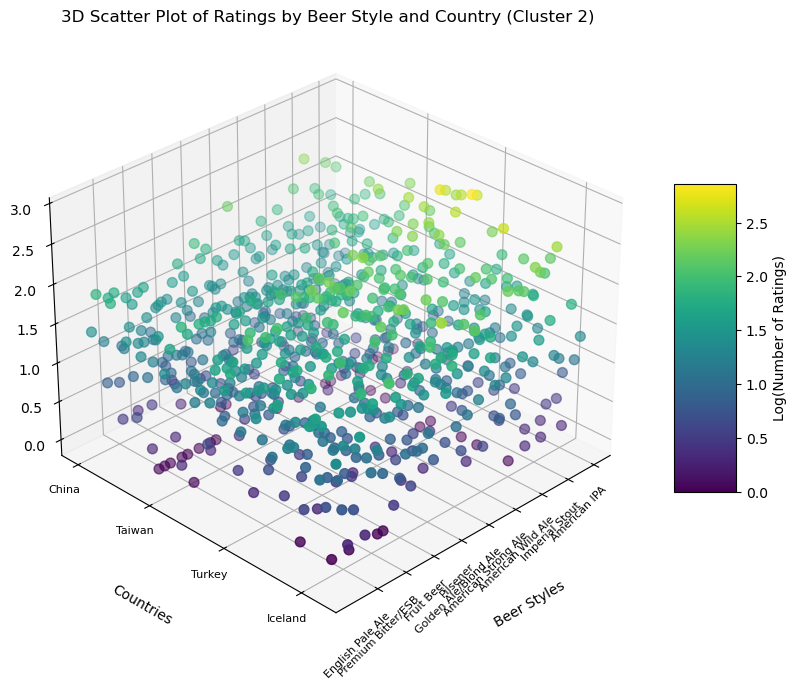

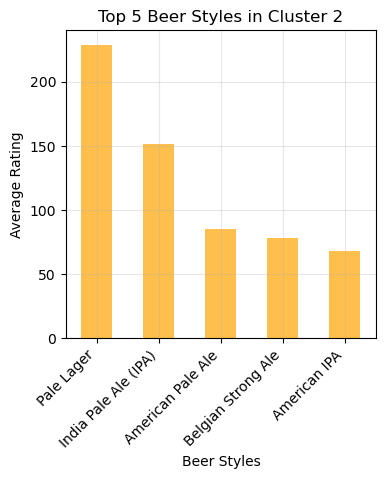

In [21]:
#  Extracting countries in the current cluster and filtering the actual data accordingly
subset_df_.columns = subset_df_.columns.str.strip()  # Clean column names
cluster_2_countries = pca_transformed.loc[pca_transformed['Cluster'] == 2, 'Country'].str.strip().tolist()
countries = [country for country in cluster_2_countries if country in subset_df_.columns]
cluster_2_data = subset_df_[countries]

plot_3D_scatter(cluster_2_data,'3D Scatter Plot of Ratings by Beer Style and Country (Cluster 2)')

# Visualize the top 5 beer styles
cluster_2_data['average_number_of_ratings'] = cluster_2_data.mean(axis=1)  #Calculate the average number of ratings for each beer style across valid countries

top_5_beer_styles = cluster_2_data['average_number_of_ratings'].sort_values(ascending=False).head(5)  #Sort the beer styles by average rating in descending order


top_5_beer_styles.plot(kind='bar', figsize=(4, 4), color='orange', alpha=0.7)
plt.title("Top 5 Beer Styles in Cluster 2")
plt.xlabel("Beer Styles")
plt.ylabel("Average Rating")
plt.xticks(rotation=45, ha='right')
plt.grid(alpha=0.3)
plt.show()

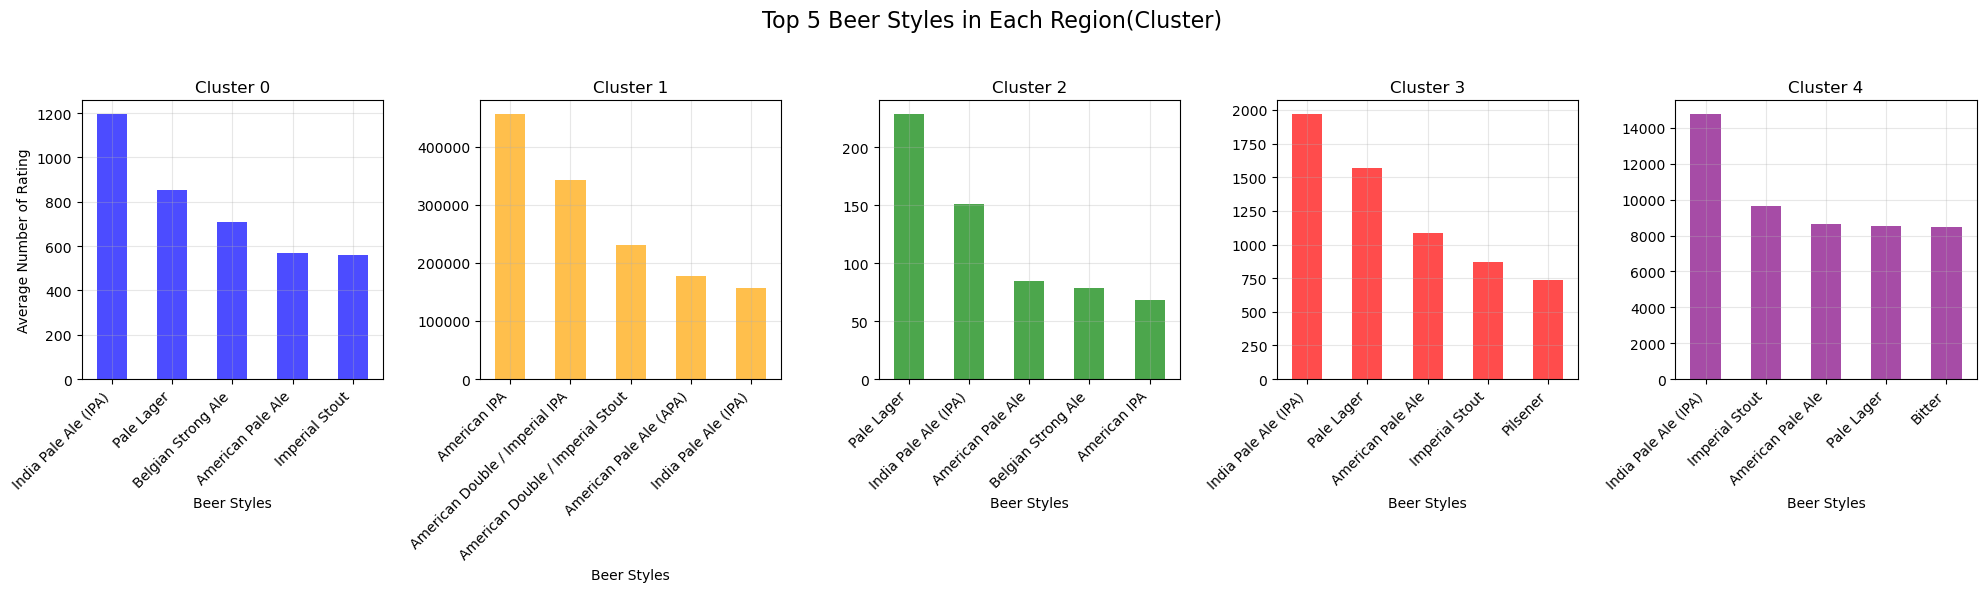

In [22]:
c,b= plot_regional_preferences(pca_transformed,subset_df_)

## Regional Beer Preferences Over Time

Basically, we will use linear regression to see that regional beer style preferences are stable or not.

In [23]:
data = total_ratings_loc_filtered[['style', 'user_location', 'rating','date']] # Choosing relavant columns
data.dropna(inplace=True) # Removing missing values

data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year  # Extract the year for trend analysis

agg_data = data.groupby(['user_location', 'style', 'year']).agg(   #Data by Year, Region, and Beer Style
    avg_rating=('rating', 'mean'),
    rating_count=('rating', 'size')   # Calculate the average rating per year, per region, and per beer style
).reset_index()

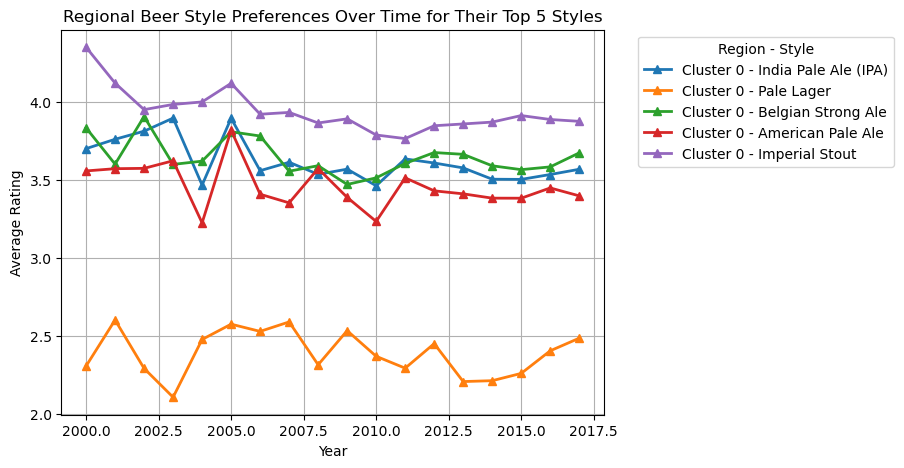

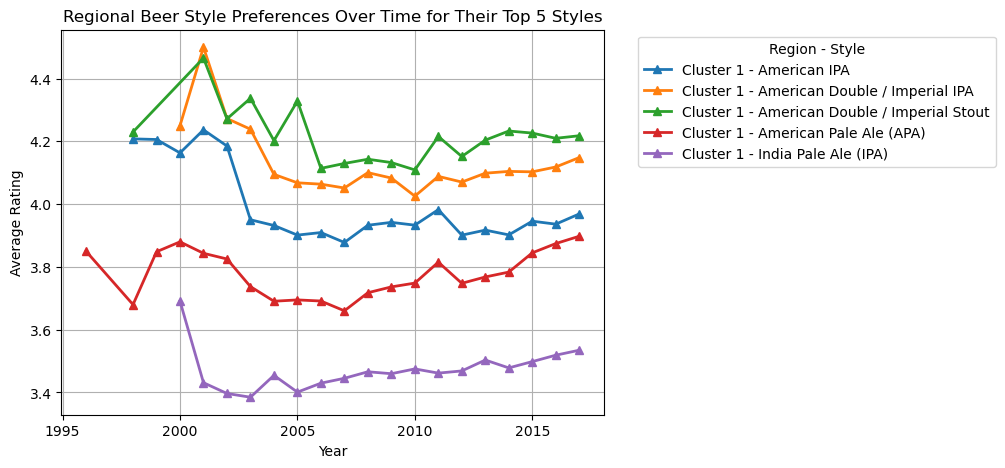

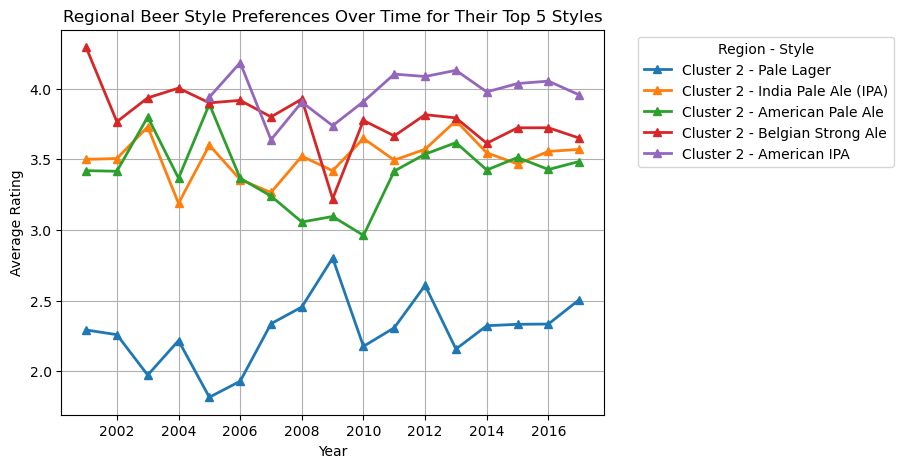

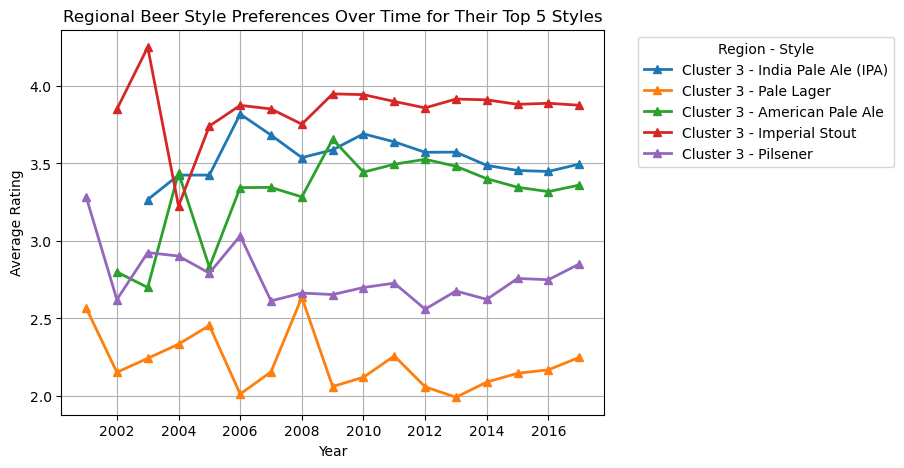

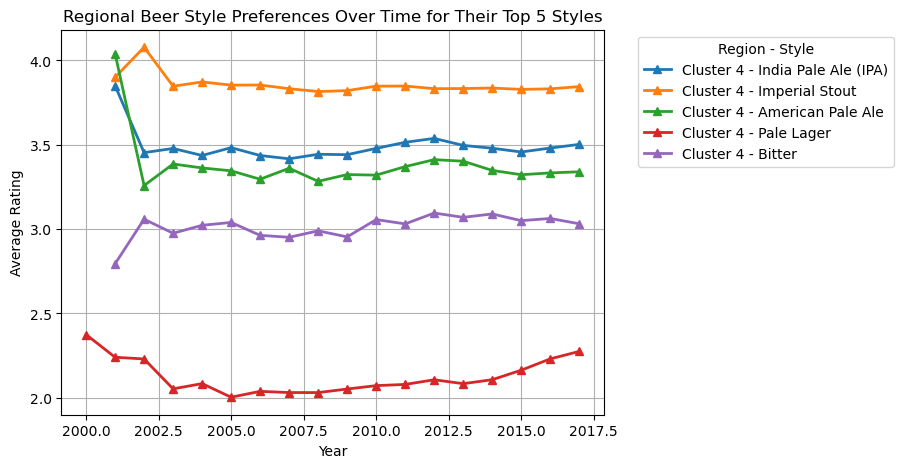

In [24]:
plot_top_styles_over_time(agg_data, clusters, pca_transformed,b,c)   

For the sake of simplicity of the plot, since trends are obvious, we will not plot the linear models. First of all, average ratings show that American IPA is more preferable than Pale Lager in these three chosen countries. Time evolution of the average ratings reveals that American IPA ratings remain relatively stable for these countries, suggesting a steady but not markedly increasing interest. Interestingly, Pale Lager ratings in these two countries increase constantly over time. It suggests that there is a noticeable evolution in tastes over time, likely driven by global beer trends and expanding market availability, challenging the idea of stable, regionally bound beer preferences.

## Adding Average Ratings into Account

In [25]:
merged_df_counts_avg_ratings = merge_data_with_counts_and_avg_ratings(total_ratings_loc_filtered)
merged_df_counts_avg_ratings

Argentina_count  Australia_count  Austria_count  \
Euro Pale Lager                     27.0            923.0          196.0   
English Pale Ale                    20.0           2803.0           94.0   
English Bitter                       1.0            483.0            8.0   
American Pale Wheat Ale              2.0            260.0           10.0   
American Blonde Ale                  3.0            360.0           18.0   
...                                  ...              ...            ...   
Saké - Koshu                         0.0              0.0            0.0   
Saké - Taru                          0.0              0.0            0.0   
Saké - Honjozo                       0.0              0.0            0.0   
Saké - Genshu                        0.0              0.0            0.0   
Saké - Futsu-shu                     0.0              0.0            0.0   

                         Belgium_count  Brazil_count  Bulgaria_count  \
Euro Pale Lager                  378.0         209.0            50.0   
English Pale Ale                 414.0         274.0            11.0   
English Bitter                    65.0          42.0             1.0   
American Pale Wheat Ale           32.0          87.0             0.0   
American Blonde Ale               64.0          55.0             2.0   
...                                ...           ...             ...   
Saké - Koshu                       3.0           0.0             0.0   
Saké - Taru                        0.0           0.0             0.0   
Saké - Honjozo                     0.0           0.0             0.0   
Saké - Genshu                      1.0           0.0             0.0   
Saké - Futsu-shu                   3.0           0.0             0.0   

                         Canada_count  Chile_count  China_count  \
Euro Pale Lager                4581.0         21.0         59.0   
English Pale Ale               9683.0         68.0         56.0   
English Bitter                 1743.0          1.0         21.0   
American Pale Wheat Ale        2523.0          0.0         15.0   
American Blonde Ale            3257.0          0.0          8.0   
...                               ...          ...          ...   
Saké - Koshu                      0.0          0.0          0.0   
Saké - Taru                       0.0          0.0          0.0   
Saké - Honjozo                    0.0          0.0          0.0   
Saké - Genshu                     0.0          0.0          0.0   
Saké - Futsu-shu                  0.0          0.0          0.0   

                         Croatia_count  ...  South Korea_avg_rating  \
Euro Pale Lager                  173.0  ...                     0.0   
English Pale Ale                 227.0  ...                     3.2   
English Bitter                    17.0  ...                     0.0   
American Pale Wheat Ale            5.0  ...                     0.0   
American Blonde Ale                9.0  ...                     0.0   
...                                ...  ...                     ...   
Saké - Koshu                       0.0  ...                     0.0   
Saké - Taru                        0.0  ...                     0.0   
Saké - Honjozo                     0.0  ...                     0.0   
Saké - Genshu                      0.0  ...                     0.0   
Saké - Futsu-shu                   6.0  ...                     0.0   

                         Spain_avg_rating  Sweden_avg_rating  \
Euro Pale Lager                  2.722494           2.565615   
English Pale Ale                 3.004915           3.085109   
English Bitter                   3.493735           3.456626   
American Pale Wheat Ale          3.452667           3.414596   
American Blonde Ale              3.223671           3.359160   
...                                   ...                ...   
Saké - Koshu                     0.000000           0.000000   
Saké - Taru                      0.000000           3.366667   
Saké - Honjoz

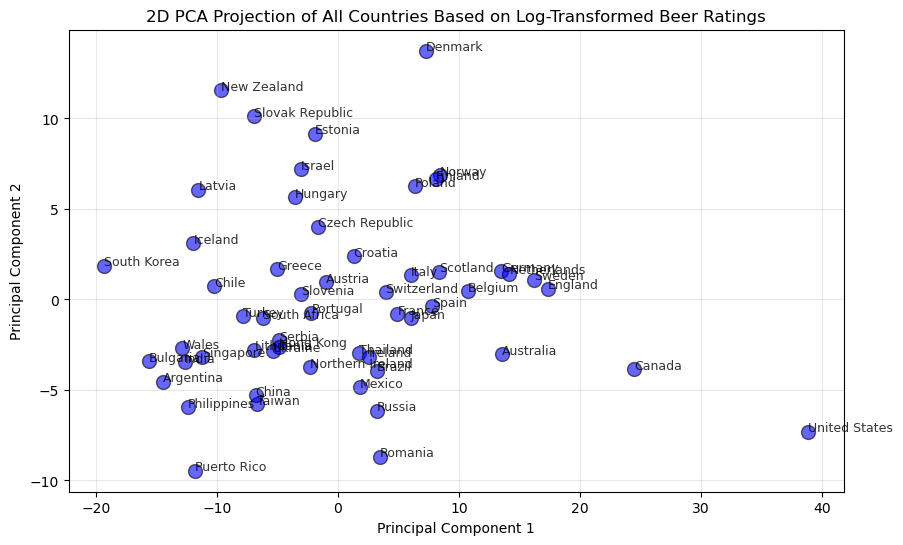

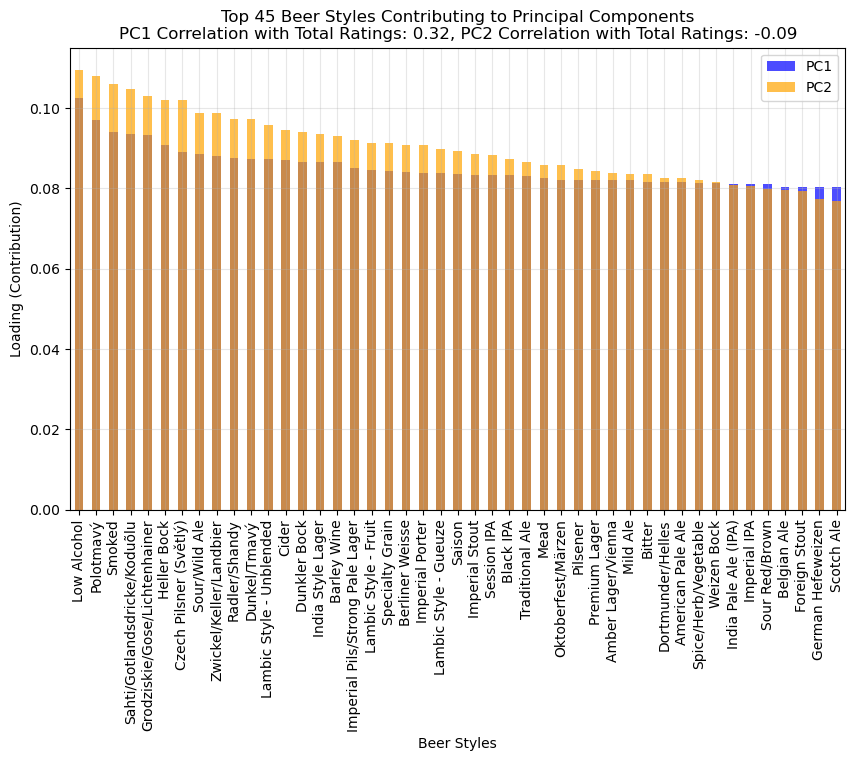

<Figure size 640x480 with 0 Axes>

In [26]:
reduced_to_3D = reduce_data_to_3D(merged_df_counts_avg_ratings)
pca_componentsss, loadingsss = plot_PCA_2D_with_loadings(reduced_to_3D,'2D PCA Projection of All Countries Based on Log-Transformed Beer Ratings')

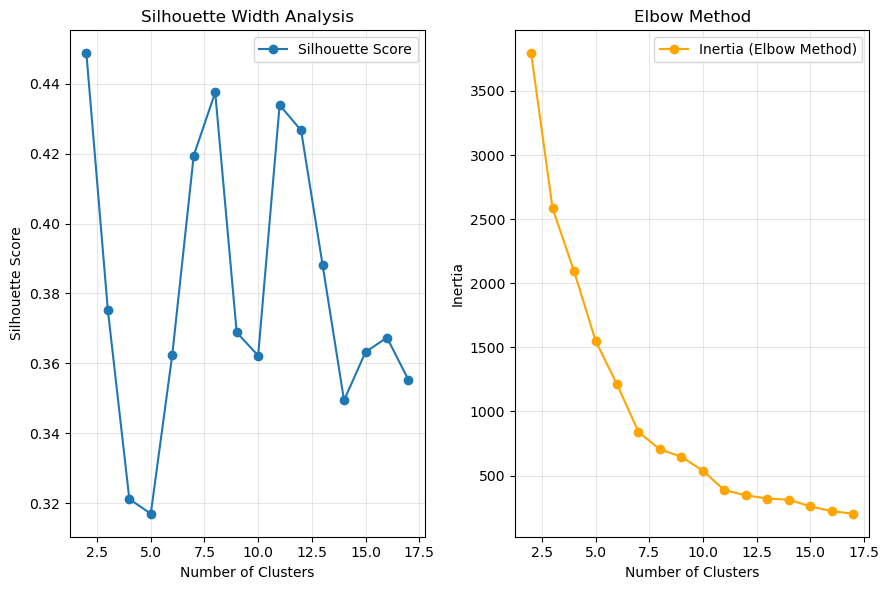

In [27]:
cluster_range1 = range(2,18)
silhoutte_inertia_plotting(cluster_range1,pca_componentsss) # Plotting Silhouette Width and Inertia Scores

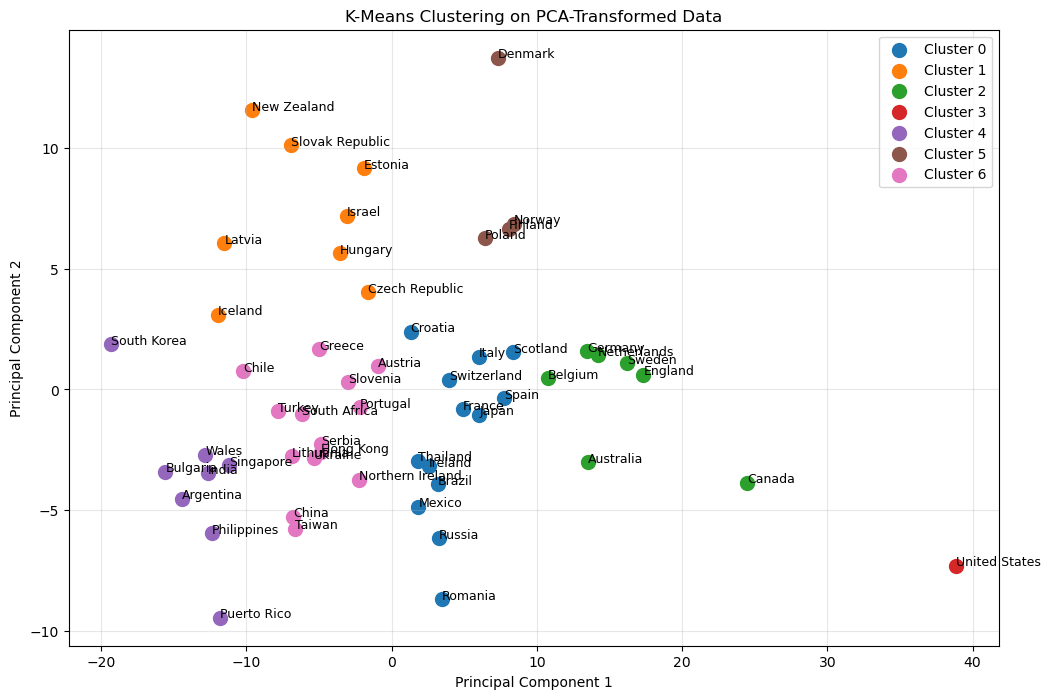

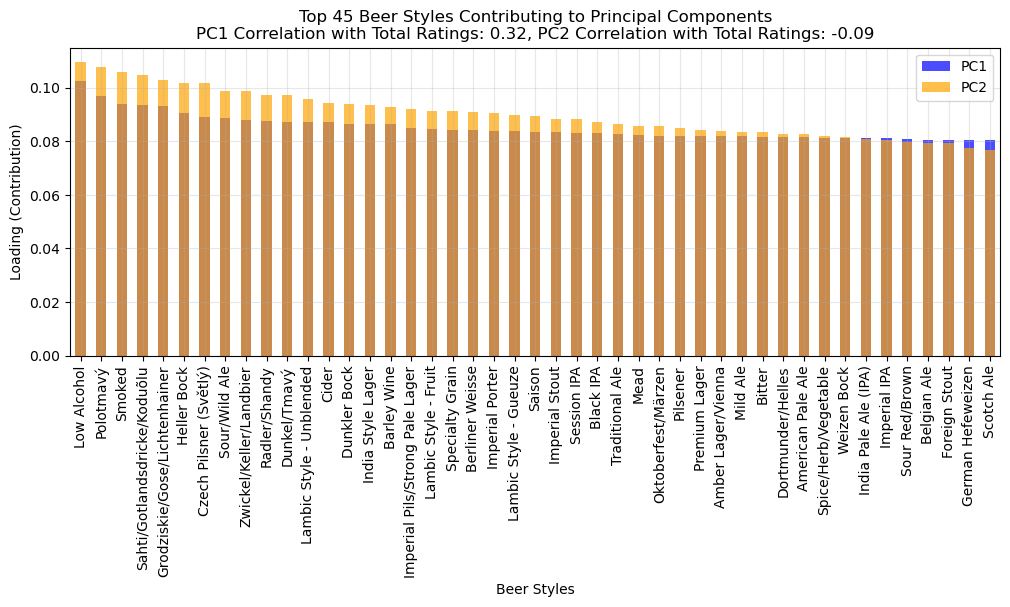

<Figure size 640x480 with 0 Axes>

In [28]:
# Extracting country names
country_names = list(reduced_to_3D.columns)

# Perform K-Means Clustering
kmeans = KMeans(n_clusters=7, random_state=42)  # Choose number of clusters
clusters = kmeans.fit_predict(pca_componentsss)

# Combine Clustering Results with Country Names
pca_transformed = pd.DataFrame(pca_componentsss, columns=["PC1", "PC2"])
pca_transformed['Cluster'] = clusters
pca_transformed['Country'] = country_names


plt.figure(figsize=(12, 8))
plot_clusters(pca_transformed) # Visualize the Clusters

# Calculate the correlation between the number of ratings and PCA loadings
total_ratings = reduced_to_3D.sum(axis=1)
loadingss['Total Ratings'] = total_ratings
pc1_corr = loadingsss[['PC1', 'Total Ratings']].corr().iloc[0, 1]
pc2_corr = loadingsss[['PC2', 'Total Ratings']].corr().iloc[0, 1]

plt.figure(figsize=(12, 4))
plot_pca_loadings(loadingsss,pc1_corr,pc2_corr)  # Plotting the PCA loadings

plt.tight_layout()
plt.show()

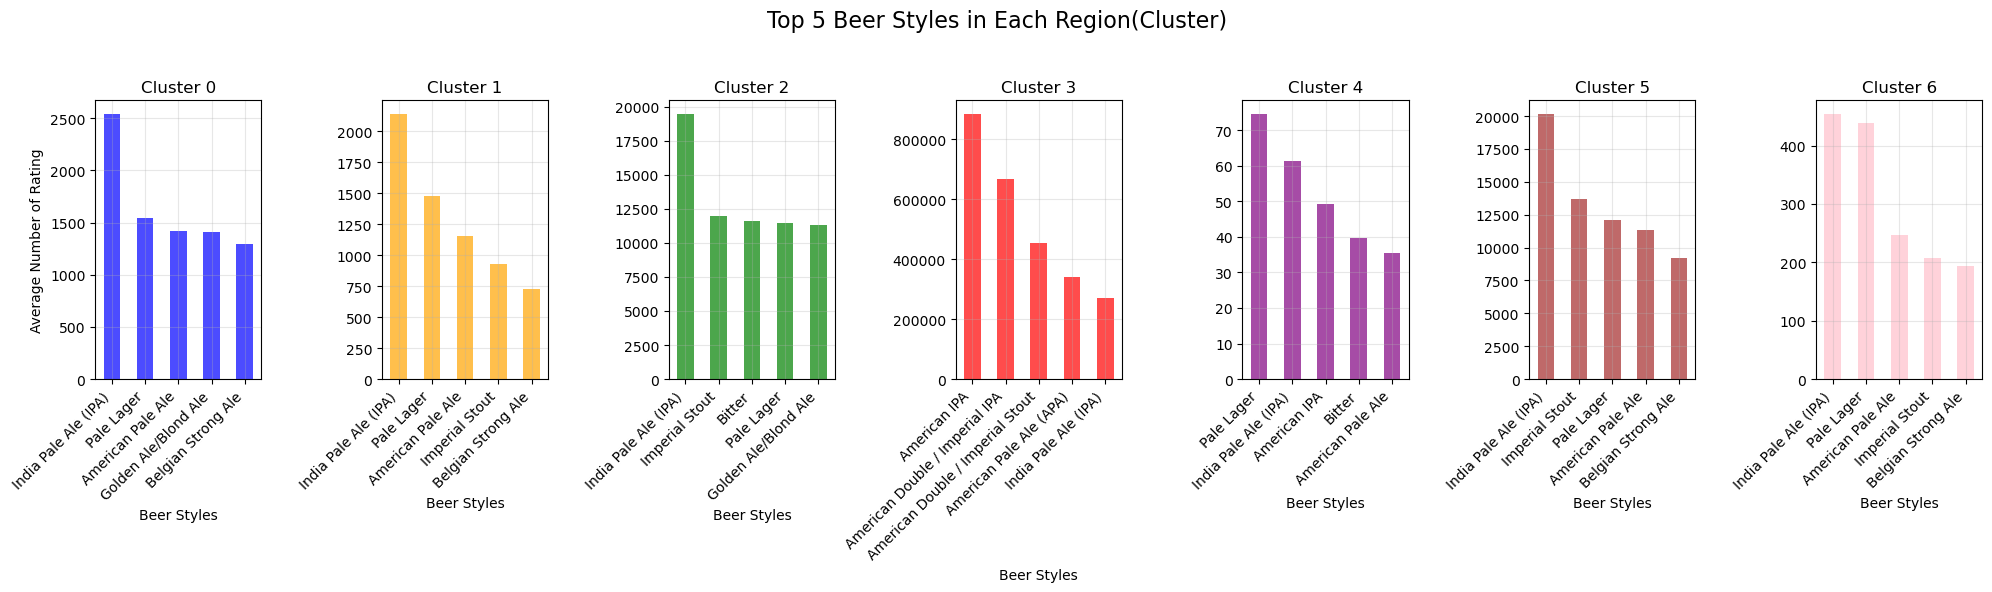

In [29]:
c,b= plot_regional_preferences(pca_transformed,subset_df_)

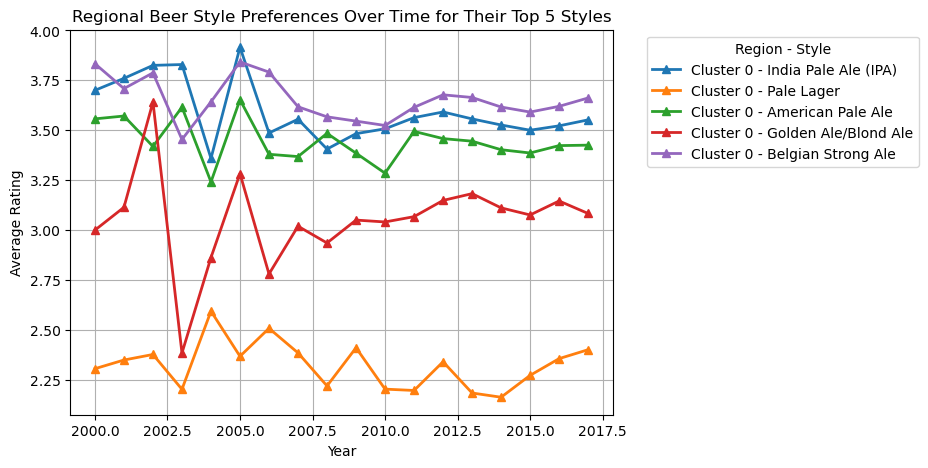

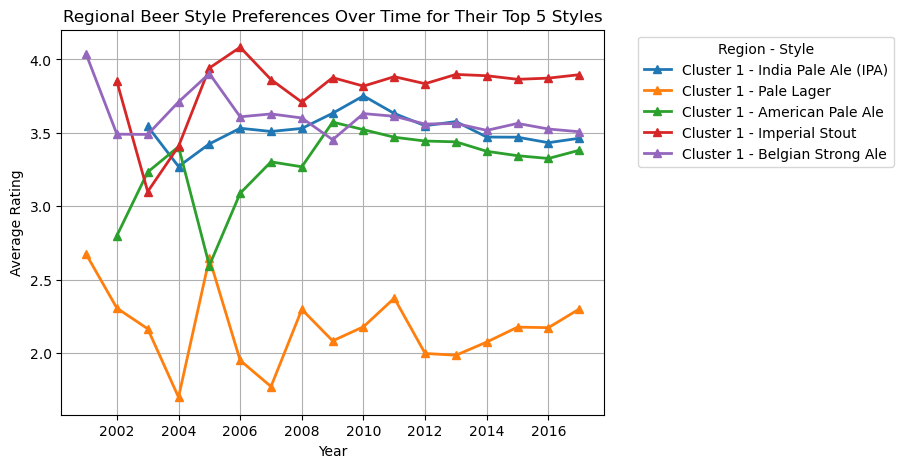

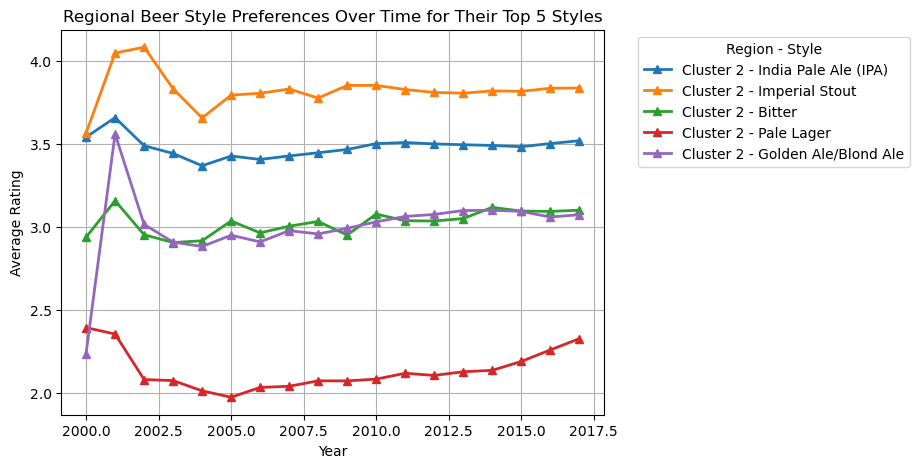

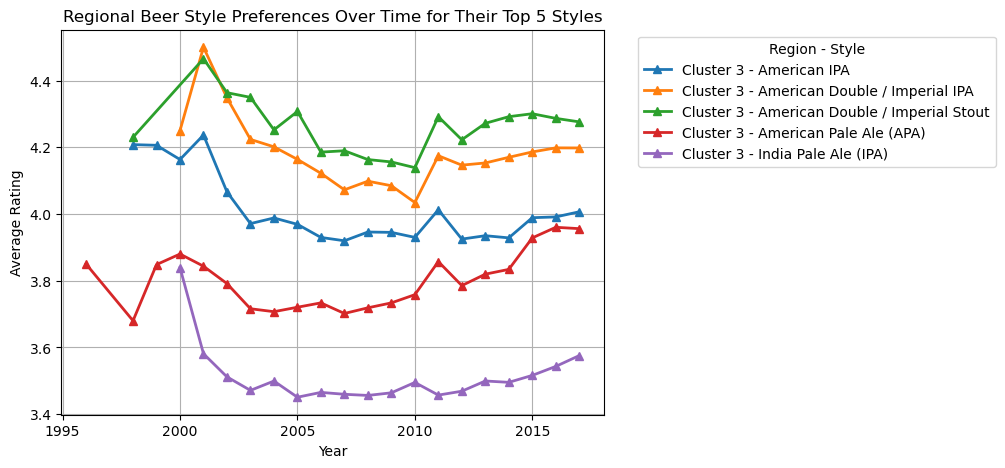

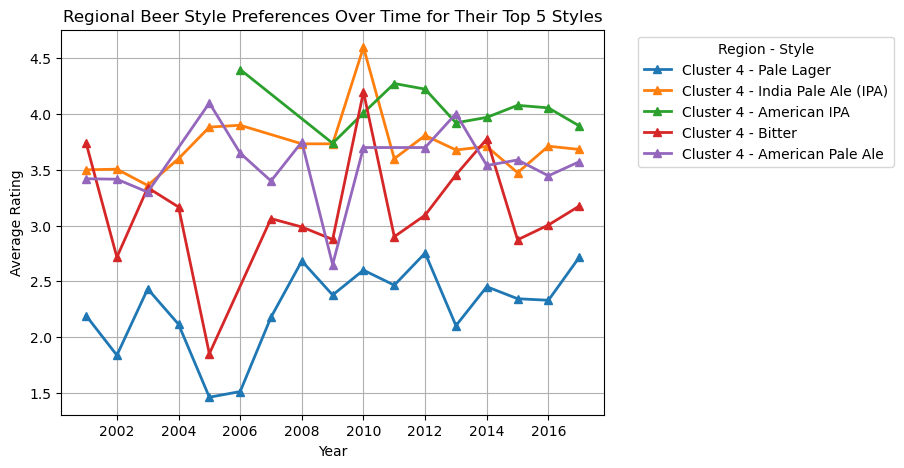

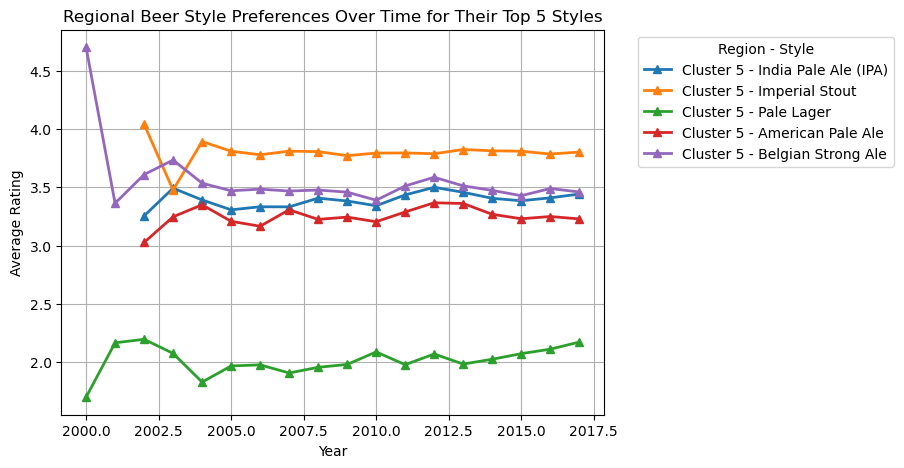

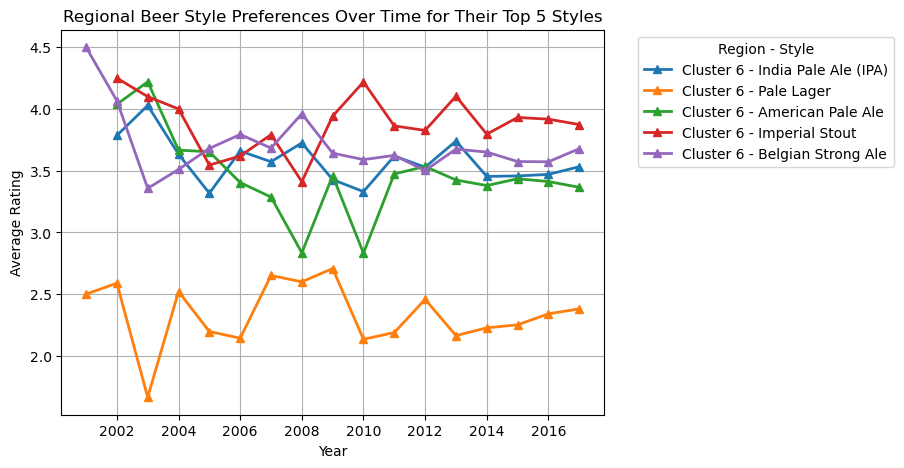

In [30]:
plot_top_styles_over_time(agg_data, clusters, pca_transformed,b,c)   

In [32]:
trends = agg_data.groupby(['user_location', 'style']).apply(calculate_trend).reset_index(name='trend')
filtered_agg_data = agg_data[              # Filter `agg_data` to include only the selected regions and beer styles
(agg_data['user_location'].isin(regions)) &
(agg_data['style'].isin(styles))]

trends = filtered_agg_data.groupby(['user_location', 'style']).apply(calculate_trend).reset_index(name='trend')

trends

NameError: name 'regions' is not defined

## b) Importance of specific beer attributes

We will now examine the importance of the different beer attributes in determining the final rating.

To this aim, we will start by using linear regression with attribute ratings as features and the final rating as the outcome variable across all countries combined.Additionally, we will include proxy variables, such as brewery_avg_rating and beer_style_rating, to account for potential biases and confounding effects. We will then compare the coefficients of each attribute to evaluate their relative influence. After that, we will investigate how the importance of these attributes varies between countries by repeating this analysis separately for each country and examining the distribution of attribute coefficients across different countries.

To perform these analyses, we will attribute ratings data. Thus, we will start by removing reviews lacking one or several attribute rating values.

In [33]:
attributes = ['appearance', 'aroma', 'palate', 'taste'] 
ba_ratings_no_missing_attributes= ba_ratings.dropna(subset= attributes )
rb_ratings_no_missing_attributes= rb_ratings.dropna(subset= attributes )
ba_ratings_loc_filtered_no_missing= ba_ratings_loc_filtered.dropna(subset= attributes )
rb_ratings_loc_filtered_no_missing = rb_ratings_loc_filtered.dropna(subset= attributes )
#rb_ratings_loc_filtered_no_missing.head()
rb_ratings_no_missing_attributes.head()

beer_name   beer_id brewery_name  brewery_id       style  abv  \
0    33 Export (Gabon)  410549.0      Sobraga      3198.0  Pale Lager  5.0   
1  Castel Beer (Gabon)  105273.0      Sobraga      3198.0  Pale Lager  5.2   
2  Castel Beer (Gabon)  105273.0      Sobraga      3198.0  Pale Lager  5.2   
3  Castel Beer (Gabon)  105273.0      Sobraga      3198.0  Pale Lager  5.2   
4  Castel Beer (Gabon)  105273.0      Sobraga      3198.0  Pale Lager  5.2   

                 date     user_name   user_id  appearance  aroma  palate  \
0 2016-04-26 10:00:00       Manslow  175852.0         2.0    4.0     2.0   
1 2017-02-17 11:00:00  MAGICuenca91  442761.0         2.0    3.0     2.0   
2 2016-06-24 10:00:00        Sibarh  288889.0         3.0    3.0     2.0   
3 2016-01-01 11:00:00       fombe89  250510.0         4.0    3.0     1.0   
4 2015-10-23 10:00:00    kevnic2008  122778.0         2.0    4.0     2.0   

   taste  overall  rating  user_avg_rating  brewery_avg_rating  \
0    4.0      8.0     2.0         2.941377            1.842105   
1    4.0      8.0     1.9         3.146914            1.842105   
2    3.0      5.0     1.6         2.019136            1.842105   
3    2.0      5.0     1.5         3.257624            1.842105   
4    4.0      7.0     1.9         2.703590            1.842105   

   style_avg_rating  user_nb_reviews  
0          2.046774           1890.0  
1          2.046774             89.0  
2          2.046774            169.0  
3          2.046774           3371.0  
4          2.046774          13043.0

We will now observe the distribution of each attribute ratings in the Beer Advocate and the Rate Beer datasets using histogram plots.

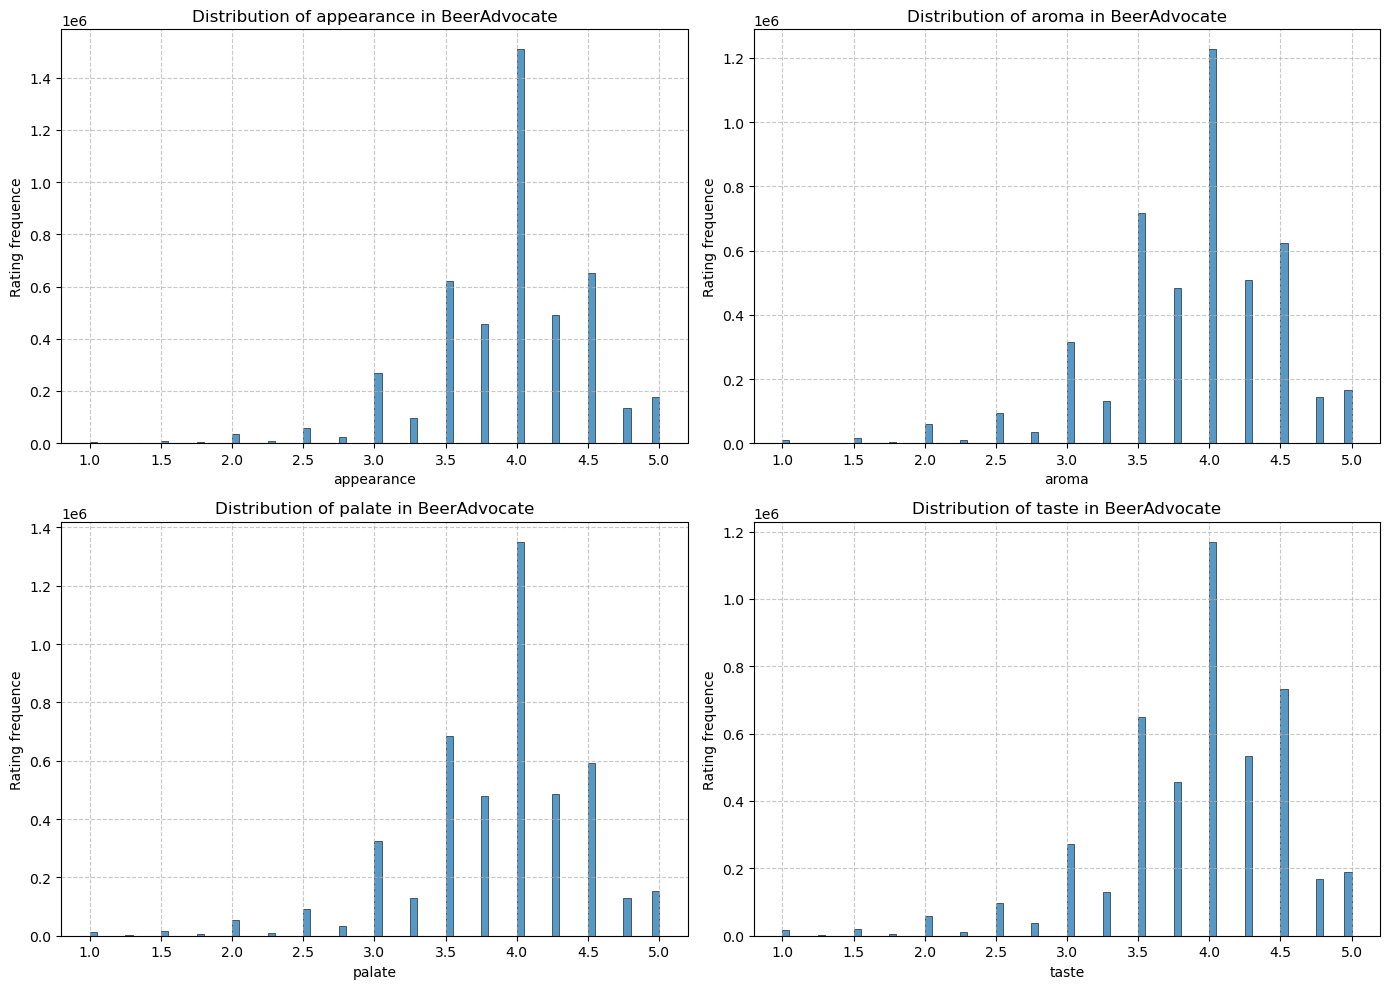

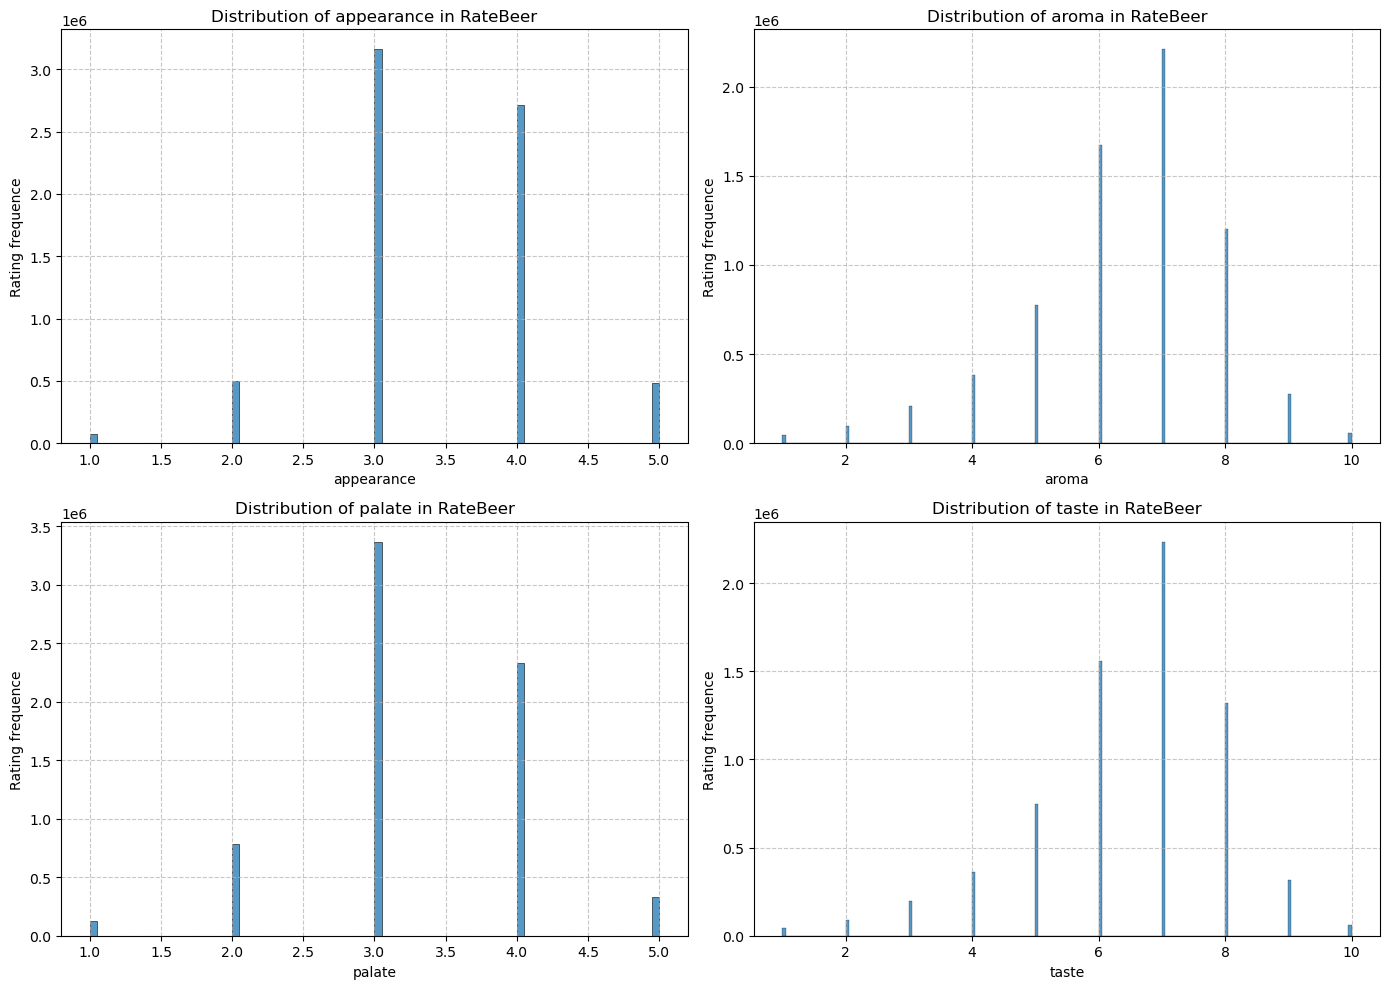

In [34]:
# Here we are plotting Beer Advocate data by creating histogram sublplots for each beer attribute.
# We are using histplot function of seaborn python library. We set the function to our preferences for a better visualization



plot_hist(attributes,ba_ratings_loc_filtered_no_missing,'BeerAdvocate')     
plot_hist(attributes,rb_ratings_loc_filtered_no_missing,'RateBeer') # Here we are doing the same  plotting for Rate Beer data

plt.close()

Here we are looking at the general distribution of the beer atributes to get a gist of the ratings to differentiate between each attribute and what are the differences between the databases. Here we can see that the ratings in the Rate Beer are more harsh compared to the Beer Advocate and they are generally lower.Also to note the rating syszem of Rate Beer seems to more strict only allowing 0.5 increments while the Beer Advocate ratings can be more precise. We see that the taste and aroma ratings are given out of ten in Rate Beer , This can cause to some problems while concanating and doing correlation analysis.So we need to scale them

In [80]:
rb_ratings_loc_filtered_no_missing['taste'] = rb_ratings_loc_filtered_no_missing['taste'] / 2
rb_ratings_loc_filtered_no_missing['aroma'] = rb_ratings_loc_filtered_no_missing['aroma'] / 2
rb_ratings_no_missing_attributes['taste'] = rb_ratings_no_missing_attributes['taste'] / 2
rb_ratings_no_missing_attributes['aroma'] = rb_ratings_no_missing_attributes['aroma'] / 2

Here we scaled the Rate Beer's taste and aroma beer attributes accordingly to the other attributes' rating scale so that we have a common scale. ( 5 point rating scale)

In [81]:
#We merge the datas vertically and drop their previous index values while adding their source dataset information,
total_ratings_loc_filtered_no_missing = pd.concat([ba_ratings_loc_filtered_no_missing, rb_ratings_loc_filtered_no_missing], keys=['ba', 'rb']).reset_index(level=0).rename(columns={'level_0': 'source'})
total_ratings_loc_filtered_no_missing = total_ratings_loc_filtered_no_missing.reset_index(drop=True)
total_ratings_loc_filtered_no_missing.head()
total_ratings_no_missing_attributes= pd.concat([ba_ratings_no_missing_attributes, rb_ratings_no_missing_attributes], keys=['ba', 'rb']).reset_index(level=0).rename(columns={'level_0': 'source'})
total_ratings_no_missing_attributes = total_ratings_no_missing_attributes.reset_index(drop=True)


In [82]:
total_ratings_no_missing_attributes.sample(n=6)

source                                          beer_name   beer_id  \
4326387      ba                Half Acre / Short's Captain Fantasy   71069.0   
919205       ba                                      Picoso Kronik  240549.0   
8755665      rb  SKA Local Series #11/13/17/20/22/23/24 (Hopera...  111750.0   
11784676     rb                Castelain ChTi Cuvée de Noël Ambrée   84384.0   
9030892      rb                       Tin Man 3 Gear Robust Porter  187448.0   
8277213      rb                            The Tap Charlies Porter   64528.0   

                             brewery_name  brewery_id  \
4326387            Half Acre Beer Company     18006.0   
919205          Lagunitas Brewing Company       220.0   
8755665                       SKA Brewing       486.0   
11784676                        Castelain       739.0   
9030892           Tin Man Brewing Company     15332.0   
8277213   Haverhill Brewery Inc / The Tap      3940.0   

                             style  abv                date      user_name  \
4326387     Saison / Farmhouse Ale  7.0 2011-09-13 10:00:00     rhoadsrage   
919205    American Amber / Red Ale  6.8 2016-07-15 10:00:00      Avatar113   
8755665       India Pale Ale (IPA)  NaN 2008-12-03 11:00:00      BOLTZ7555   
11784676                 Amber Ale  6.0 2013-10-11 10:00:00           dEnk   
9030892                     Porter  5.4 2014-01-27 11:00:00       presario   
8277213                     Porter  5.8 2006-12-30 11:00:00  jcwattsrugger   

                   user_id  appearance  aroma  palate  taste  overall  rating  \
4326387    rhoadsrage.6920         4.0   4.00     4.0   4.00      4.0    4.00   
919205    avatar113.593381         4.0   4.25     4.0   4.25      4.0    4.16   
8755665            66017.0         3.0   4.00     3.0   3.50     15.0    3.60   
11784676           88581.0         3.0   2.00     3.0   2.00      8.0    2.20   
9030892             5348.0         4.0   3.00     3.0   3.50     13.0    3.30   
8277213            21918.0         2.0   2.50     3.0   2.50     10.0    2.50   

          user_avg_rating  brewery_avg_rating  style_avg_rating  \
4326387          3.787251            4.083089          3.951112   
919205           3.982960            4.056890          3.740720   
8755665          3.621846            3.360613          3.482046   
11784676         3.260445            2.995561          3.160146   
9030892          3.172485            3.394651          3.435335   
8277213          3.265386            3.363676          3.435335   

          user_nb_reviews  
4326387            2786.0  
919205                0.0  
8755665            2252.0  
11784676           3762.0  
9030892            4539.0  
8277213           11421.0

The data frame above will be the main data frame for linear regression analysis as it will allow us to analyse the total ratings

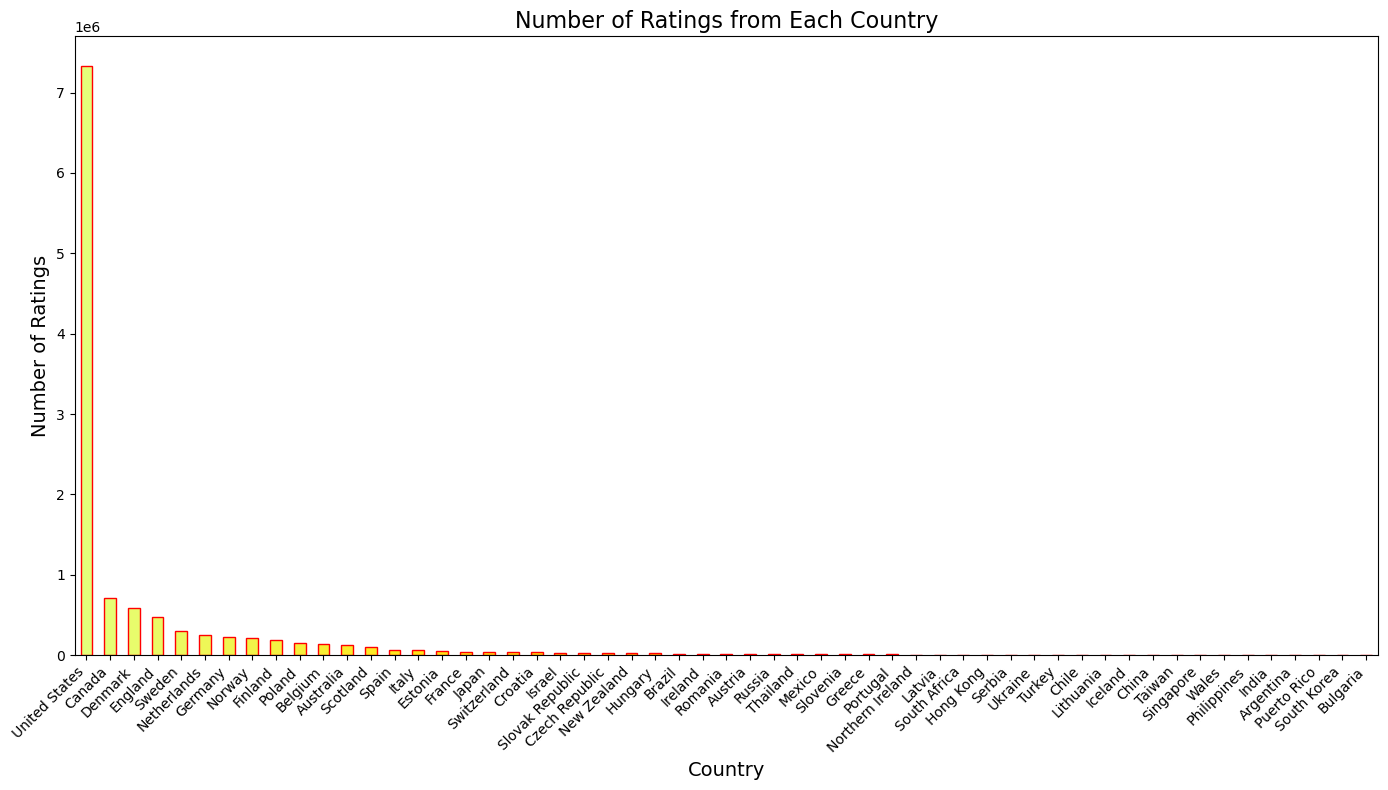

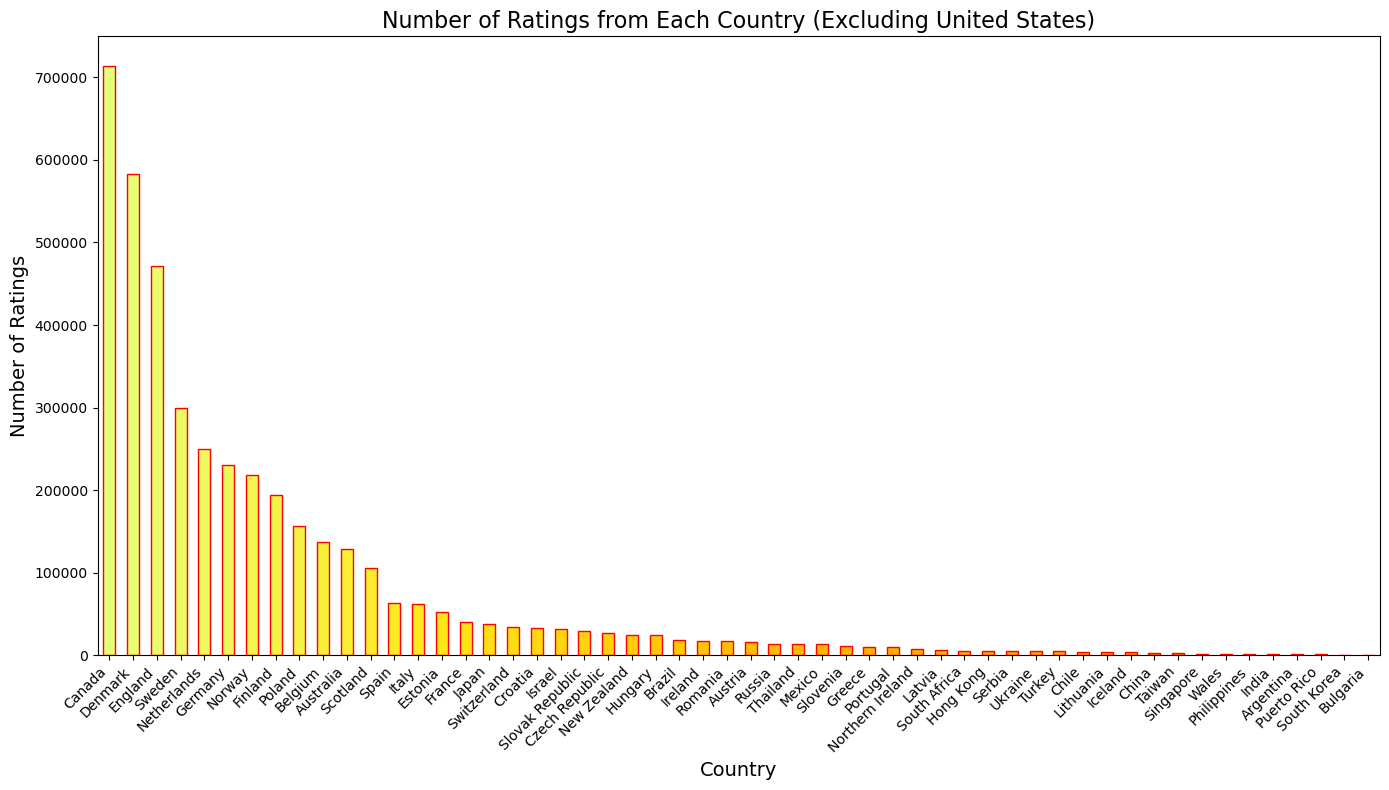

In [83]:
#Here we are creating bar plots for countries too see how much ratings are done from that specific country.
#We are using color gradient to our preference.
#We are doing more than more plots because USA has to many ratings and distrupts the flow of the plot
country_counts = total_ratings_loc_filtered_no_missing['user_location'].value_counts()
colors = plt.cm.Wistia(np.linspace(0, 1, len(country_counts)))
plt.figure(figsize=(14, 8))
country_counts.plot(kind='bar', color=colors, edgecolor='red')
plt.title("Number of Ratings from Each Country", fontsize=16)
plt.xlabel("Country", fontsize=14)
plt.ylabel("Number of Ratings", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()  
plt.show()

usa_filtered_ratings = total_ratings_loc_filtered_no_missing[total_ratings_loc_filtered_no_missing['user_location'] != 'United States']

country_counts_without_usa= usa_filtered_ratings['user_location'].value_counts()

colors = plt.cm.Wistia(np.linspace(0, 1, len(country_counts)))

plt.figure(figsize=(14, 8))
country_counts_without_usa.plot(kind='bar', color=colors, edgecolor='red')
plt.title("Number of Ratings from Each Country (Excluding United States)", fontsize=16)
plt.xlabel("Country", fontsize=14)
plt.ylabel("Number of Ratings", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
plt.close()

Here we wanted to see how many ratings are coming from each country and plotted it by histograms to visualize it. We have two plots of histogram one with United States and one without it.This is because United States has much more ratings data compared to other countries so the histogram plots becomes a little bit skewed, so to get a better look at other countries contribution we made another plot without USA. 

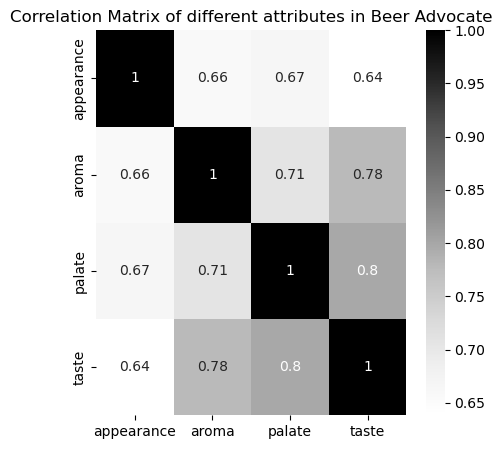

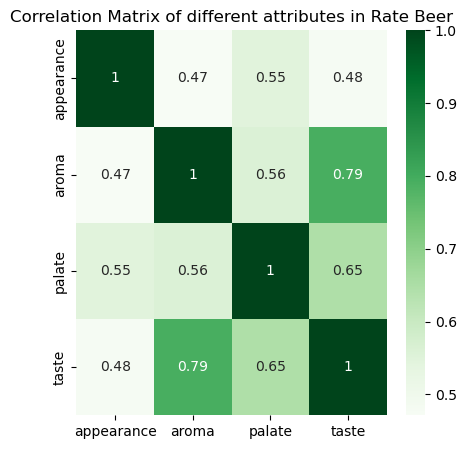

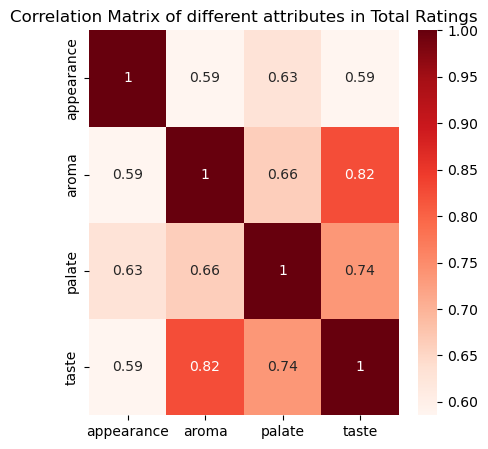

In [84]:
# We will try to see and compare how each attributes correlates between each other
# Best way to visualize this to create heat maps.We are creating heatmaps for each data set because this way
# we can see the changement of the correlation between the attributes better when we merge the two dataframe.
correlation_matrix_1 = ba_ratings_loc_filtered_no_missing[attributes].corr()

plt.figure(figsize=(5, 5))
sns.heatmap(correlation_matrix_1, annot=True, cmap="Greys")
plt.title("Correlation Matrix of different attributes in Beer Advocate")

correlation_matrix_2 = rb_ratings_loc_filtered_no_missing[attributes].corr()
plt.figure(figsize=(5, 5))
sns.heatmap(correlation_matrix_2, annot=True, cmap="Greens")
plt.title("Correlation Matrix of different attributes in Rate Beer")

correlation_matrix_total = total_ratings_loc_filtered_no_missing[attributes].corr()
plt.figure(figsize=(5, 5))
sns.heatmap(correlation_matrix_total, annot=True, cmap="Reds")
plt.title("Correlation Matrix of different attributes in Total Ratings")
plt.show()
plt.close()

Here we see the correlation matrix of each data frame, including the total ratings which is created by the concatanation of Rate Beer and Beer Advocate data frames. This matrix plot gives us a good information about the correalation between beer attributes and how the ratings differentiate between the data frames. We can see that in the Beer Advocate data frame taste aroma and palate attributes have a high correlation between each other while appearance also correlating to them but not as high. In the Rate Beer data frame we see that aroma and taste correlates more between each other then with palate.Palate still correlates with them but not as strong as it was in Beer Advocate. The suprising finding here is that in the total ratings data frame, the combination of the two data frames gives us a stronger correlation between aroma and taste.These differences of correlation across each data frame indicate to us that the user profile of the two platforms might  have a distinct look on the attributes and their contribution to elavate each other.The appereance seems to be more unique when compared to other attributes since its correlation values considerably moderate accross each dataset. High correlation numbers between the attributes (especially the aroma and taste attributes) can be a sign of multicolineratiy which is important to take into account while doing the linear regression analyses.

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                 4.513e+07
Date:                Fri, 20 Dec 2024   Prob (F-statistic):               0.00
Time:                        04:09:48   Log-Likelihood:             5.6712e+06
No. Observations:             8325434   AIC:                        -1.134e+07
Df Residuals:                 8325427   BIC:                        -1.134e+07
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5296   4.24e-05   8.32e+04      0.0

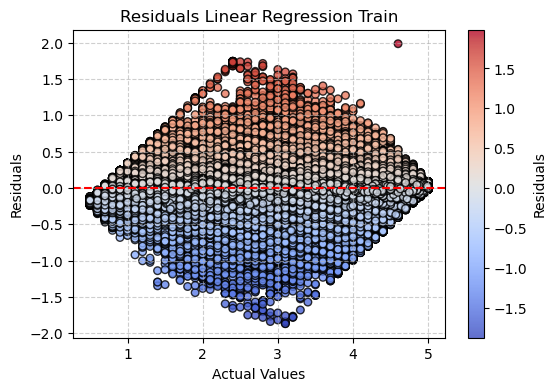

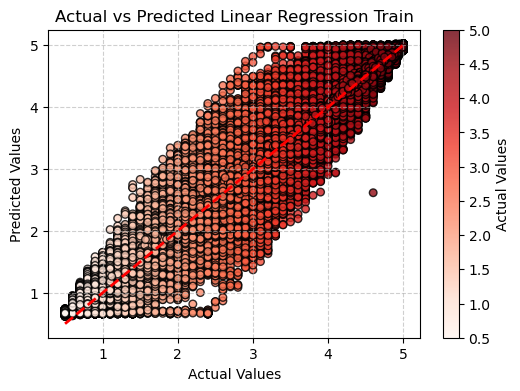

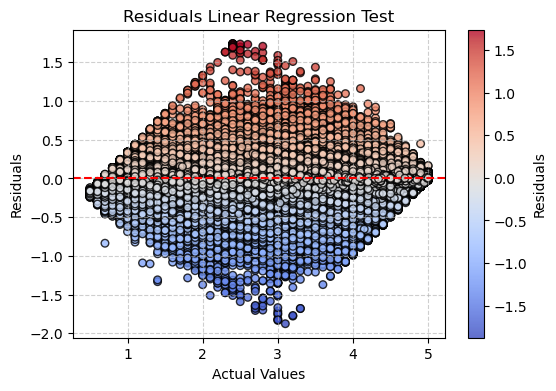

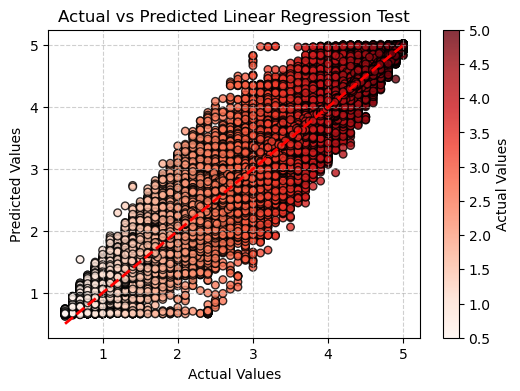

In [85]:
columns_to_drop_total = [
    'source', 'beer_id', 'beer_name', 'brewery_name', 'brewery_id', 
    'abv', 'date', 'user_name', 'user_id', 'overall', 
    'style','user_avg_rating','user_nb_reviews'
]
total_ratings_no_missing_attributes= total_ratings_no_missing_attributes.drop(columns = columns_to_drop_total)
total_ratings_final= total_ratings_no_missing_attributes.dropna()

X = total_ratings_final.drop(['rating'], axis=1)
y = total_ratings_final['rating']
results, summary = advanced_linear_regression(X, y,make_plots = True,print_summary= True)
linear_coefficients = summary.params


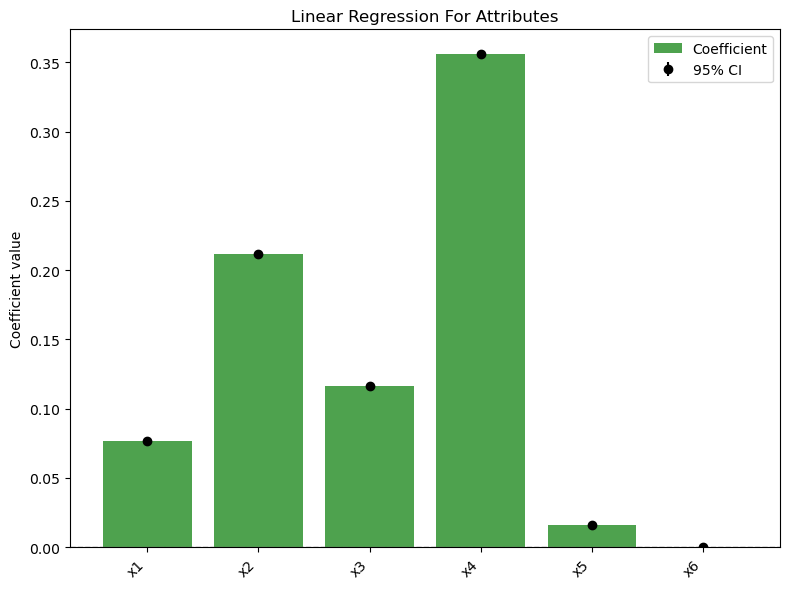

In [86]:
linear_coeff_int = summary.conf_int()
plot_coefficients(linear_coefficients, linear_coeff_int, 'Linear Regression For Attributes', 'forestgreen', ci_color='black')


The linear regression analysis on the total dataset shows us  that the model provides nearly perfect fit to the data, since  the R squared values for both the training and testing data is 0.97 which is very high. These values indicate that 97% of the variance in the final beer ratings can be explained by the selected independent variables, which are the beer attributes (appearance, aroma, palate, and taste) as well as confounder variables such as brewery_avg_rating and style_avg_rating. The high F-statistic and its associated p-value which is close to zero further confirm the statistical significance of the model. In addition the mean squared error (MSE) values for both training and testing proves that the linear model generalises the data well and does not show any signs of underfitting or overfitting and their low results shows that the model's predictions are adequate.
The coefficients of the regression shows us the relative importance of different beer attributes and confounder variables:
Taste (x4) is the most influential variable for the predicton, with a coefficient of 0.356, this means that  it is the most dominant attribute in shaping beer ratings.
Aroma (x2) follows as the second most important attribute, with a coefficient of 0.2115. This indicates that aroma plays a significant role but it is not as impactful as taste.
Palate and Appearance (x3 and x1) have smaller but still statistically significant positive effects on ratings, with coefficients of 0.1164 and 0.0769, respectively.
Brewery reputation (x5) has a small but noticeable positive influence (coefficient = 0.0157 which is in the same decimal as the appearance), suggesting that the brewery’s established reputation subtly affects individual beer ratings while beer style (x6) has a very small coefficient of 0.0003 marking that it has a  very minimal effect. As a concluison on the cofounders affect we can say that the inclusion of brewery reputation helped us to see that even though it is small the users might get influenced by it (either by having trust to the known breweries or having a bias against them) while the effect of the beer style is negliable.
The residual plots for both the training and test datasets shows us  that the residuals are symmetrically distributed around zero which is good because it means no systematic bias in the model predictions. However, there are few outliers in the rating ranges of 1–2 and 4–5 but their number is very small compared to the rest of the data.
The actual vs predicted plots for both the training and test datasets show a strong alignment of the data along the y = x line, indicating high predictive accuracy. The clustering of data points near this line confirms the model’s ability to show the relationships between predictors and the target variable effectively.

Finally , the linear regression model provides solid informations about the factors influencing beer ratings, as expected the most important attribute in user ratings is the taste of the beer. Hovewer as we have seen in the heatmaps of correlation matrix there might be some multicolinearity, we will adress this by using Lasso and Ridge regularization techniques.



In [87]:
results, model = advanced_linear_regression(X, y,'lasso',make_plots = False)
lasso_coefficients = model.coef_ 
print("Coefficients for Lasso Regularization:", lasso_coefficients)


Optimal alpha for Lasso: 0.0001
Training MSE: 0.014991825377367735 Training R2: 0.970168181335444 Training Pearson Correlation: 0.9849711668807166
Testing MSE: 0.015048308237429812 Testing R2: 0.9700590554441283 Testing Pearson Correlation: 0.984915765130364
Coefficients for Lasso Regularization: [7.68938507e-02 2.11558723e-01 1.16520884e-01 3.55793293e-01
 1.56679237e-02 3.20201541e-04]


In [88]:
results, model = advanced_linear_regression(X, y,'ridge',make_plots = False)
ridge_coefficients = model.coef_  # For Ridge Regression
print("Coefficients for Ridge Regularization:", ridge_coefficients)


Optimal alpha for Ridge: 0.7564633275546291
Training MSE: 0.014991810801548662 Training R2: 0.9701682103394632 Training Pearson Correlation: 0.9849711723393049
Testing MSE: 0.015048324443832388 Testing R2: 0.9700590231989753 Testing Pearson Correlation: 0.9849157450672511
Coefficients for Ridge Regularization: [0.07692475 0.21148656 0.11654514 0.35584989 0.0157191  0.00036357]


In [97]:
attributes_ = ["Appearance (x1)", "Aroma (x2)", "Palate (x3)", "Taste (x4)", "Brewery Avg. Rating (x5)", "Beer Avg. Rating (x6)"]
linear_coefficients_ = linear_coefficients[1:]
# Create the table
coefficient_table = pd.DataFrame({
    "Attribute": attributes_,
    "Linear Regression": linear_coefficients_,
    "Lasso Regression": lasso_coefficients,
    "Ridge Regression": ridge_coefficients
})
display(coefficient_table)

Attribute  Linear Regression  Lasso Regression  \
x1           Appearance (x1)           0.076925          0.076894   
x2                Aroma (x2)           0.211487          0.211559   
x3               Palate (x3)           0.116545          0.116521   
x4                Taste (x4)           0.355850          0.355793   
x5  Brewery Avg. Rating (x5)           0.015719          0.015668   
x6     Beer Avg. Rating (x6)           0.000364          0.000320   

    Ridge Regression  
x1          0.076925  
x2          0.211487  
x3          0.116545  
x4          0.355850  
x5          0.015719  
x6          0.000364


We applied Lasso and Ridge regularization techniques to the dataset to investigate potential multicollinearity among the predictor variables.These methods enhance the standard linear regression model by introducing penalties to the coefficients, helping to manage both multicollinearity and overfitting. The results of these analyses indicate that multicollinearity is not a significant issue in the dataset
As we can see from the table, results across normal linear regression, lasso, and ridge are very close as all methods produced nearly identical coefficients(identical in case of ridge and normal linear regression). This consistency is a strong indication that multicollinearity is not affecting the dataset. If multicollinearity was present, lasso regularization would have significantly shrunk or eliminated certain coefficients, and ridge regularization would have redistributed the variance among correlated predictors which would affect noticeable changes to the coefficients.

In conclusion, the results of lasso and ridge regularizations acts as an evidence that multicollinearity is not a concern in this dataset. These analyses again shows us  the reliability of the linear regression model and the stability of the coefficients given to the attributes 

In [94]:
# Dictionary to store coefficients
country_coefficients = {}
columns_to_drop_usa = [
    'source', 'beer_id', 'beer_name', 'brewery_name', 'brewery_id', 
    'abv', 'date', 'user_name', 'user_id', 'overall', 
    'user_location', 'brewery_location','style','user_avg_rating','user_nb_reviews'
]
columns_to_drop_im = [
    'source', 'beer_id', 'beer_name', 'brewery_name', 'brewery_id', 
    'abv', 'date', 'user_name', 'user_id', 'overall', 'rating', 
    'user_location', 'brewery_location','style','user_avg_rating','user_nb_reviews'
]
# Loop through each unique country

for country in total_ratings_loc_filtered_no_missing['user_location'].unique():
    # Filter the data for the current country
    country_data = total_ratings_loc_filtered_no_missing[
        total_ratings_loc_filtered_no_missing['user_location'] == country
    ]
    if country == 'United States':
        country_data=country_data.drop(columns=columns_to_drop_usa)
        country_data=country_data.dropna()
        X = country_data.drop(['rating'], axis=1)
        y = country_data['rating']
    else:       
        # Prepare independent variables (X) and dependent variable (y)
        X = country_data.drop(columns=columns_to_drop_im)
        y = country_data['rating']
    
    try:
        # Call the advanced_linear_regression function
        metrics, model = advanced_linear_regression(X, y,make_plots = False,print_summary=False)
        
        # Extract coefficients from the model object
        coeff_dict = dict(zip(model.params.index, model.params.values))
        coeff_dict.pop('const', None)  # Remove constant term if unnecessary

        # Store coefficients for this country
        country_coefficients[country] = coeff_dict
    
    except Exception as e:
        print(f"Error processing {country}: {e}")

# Convert coefficients dictionary to a DataFrame for analysis
country_coefficients = pd.DataFrame.from_dict(country_coefficients, orient='index')
country_coefficients.reset_index(inplace=True)
country_coefficients.rename(columns={'index': 'country'}, inplace=True)

# Display the coefficients DataFrame
#display(country_coefficients)


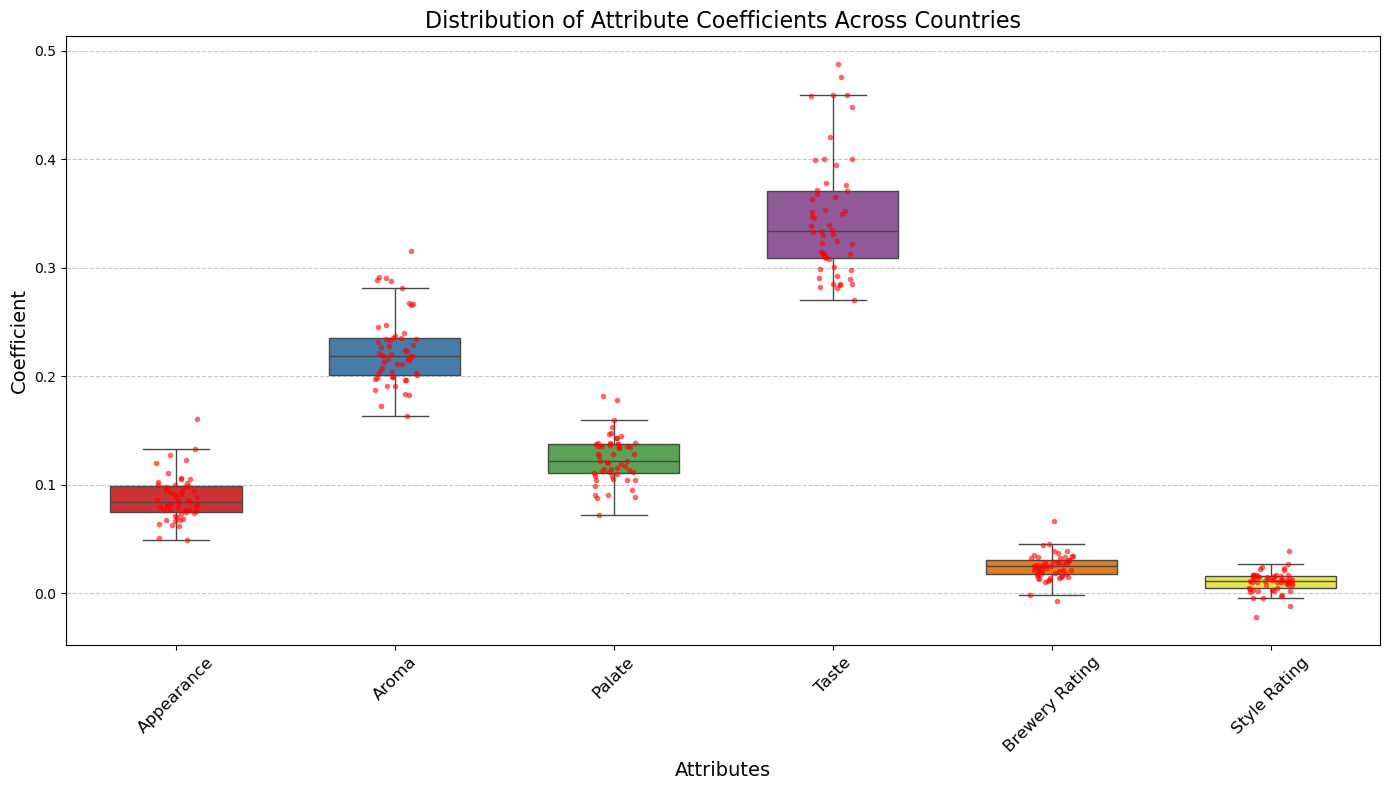

In [95]:
melted_coefficients = country_coefficients.melt(id_vars='country', var_name='attribute', value_name='coefficient')
attribute_mapping = {
    'x1': 'Appearance',
    'x2': 'Aroma',
    'x3': 'Palate',
    'x4': 'Taste',
    'x5': 'Brewery Rating',
    'x6': 'Style Rating'
}

melted_coefficients['attribute'] = melted_coefficients['attribute'].map(attribute_mapping)

plt.figure(figsize=(14, 8))
sns.boxplot(
    x='attribute', y='coefficient', data=melted_coefficients, palette='Set1', showfliers=False, width=0.6
)
sns.stripplot(
    x='attribute', y='coefficient', data=melted_coefficients, color='red', alpha=0.6, jitter=True, size=4
)

# Title and labels
plt.title('Distribution of Attribute Coefficients Across Countries', fontsize=16)
plt.xlabel('Attributes', fontsize=14)
plt.ylabel('Coefficient', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Median for each box
for i, box in enumerate(plt.gca().artists):
    box.set_edgecolor('black')  
    box.set_linewidth(1.2)      

plt.tight_layout()
plt.show()



Here we applied the linear regression analyses for each country which gave us information on how beer attributes and confounders influence ratings across various countries.
Across the countries, taste remains as the most influential factor while giving ratings to the beer. The boxplot helps us to illustrate its dominance,the taste having the highest coefficient median and the widest interquartile range. This variation in taste's influence might reflect country specific differences in how much importance users place give to the taste while evaluating beers . Similarly, aroma  consistently emerges as the second most significant attribute, with more tightly clustered coefficients compared to taste indicating widespread agreement on its importance. Palate and appearance contribute positively to beer ratings but with lower coefficients. Regional differences in these attributes’ coefficients suggest that some countries may focus on the visual or texture-related qualities more than others. 
The brewery rating displays moderate coefficients across most countries. This shows us that users' perception of brewery reputation does play a role, but it is smaller compared to the other attributes. It implies that trust or familiarity with a brewery can subtly influence ratings but is secondary to essential beer qualities. On the other hand, style rating consistently shows the lowest influence across countries. This negligible impact suggests that the specific beer style classification is not a significant determinant of ratings for most users. Instead, sensory attributes, such as taste and aroma, carry more weight in users’ evaluations.








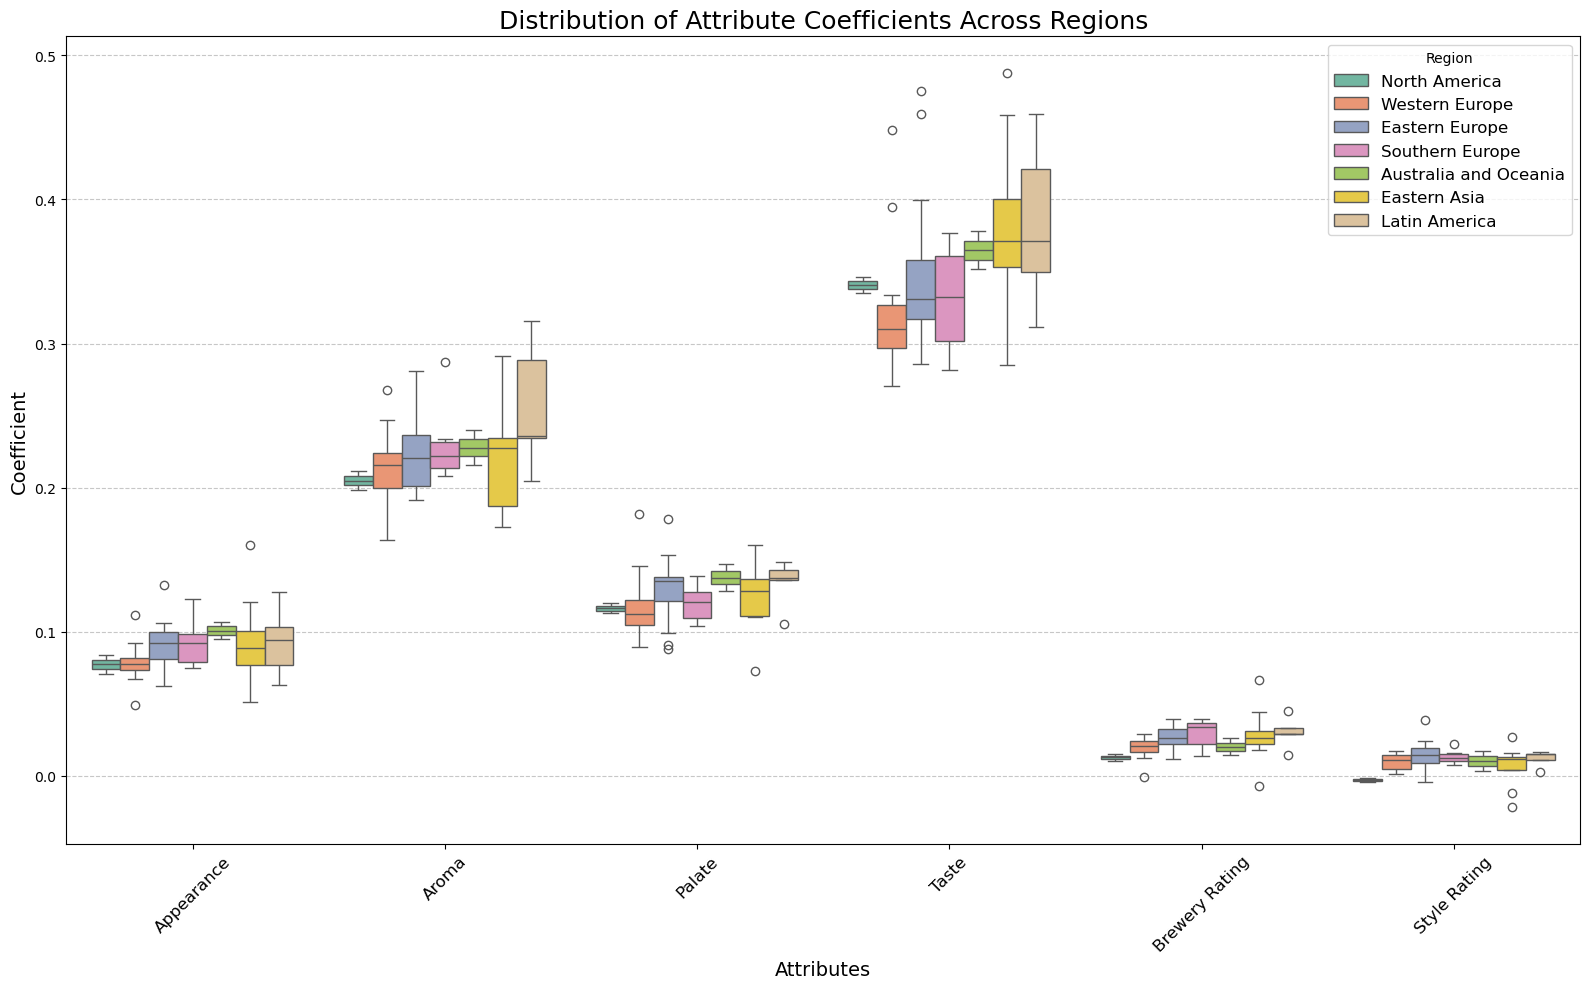

In [96]:
# Using the region_mapping functions from data_utils, we are creating boxplots specific to main regions

country_region_mapping, _ = region_mapping(country_coefficients)

#  Here we map countries to regions using the mapping dictionary
country_coefficients['region'] = country_coefficients['country'].map(country_region_mapping)

# we melt the dataframe for regional plotting 
regional_coefficients = country_coefficients.melt(
    id_vars=['country', 'region'], 
    var_name='attribute', 
    value_name='coefficient'
)


regional_coefficients['attribute'] = regional_coefficients['attribute'].map(attribute_mapping)

# We are creating box_plots for the regions 
plt.figure(figsize=(16, 10))
sns.boxplot(
    x='attribute', 
    y='coefficient', 
    hue='region', 
    data=regional_coefficients, 
    palette='Set2'
)

plt.title('Distribution of Attribute Coefficients Across Regions', fontsize=18)
plt.xlabel('Attributes', fontsize=14)
plt.ylabel('Coefficient', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.legend(title='Region', fontsize=12, loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


Here, we grouped countries into geographical regions to analyze whether beer attribute preferences exhibit regional patterns and to observe how the importance of specific attributes varies across regions.We observed that taste consistently holds the highest coefficient across all regions, reaffirming its universal importance, followed by aroma, palate, and appearance.Showing us that although slight inter-regional deviations in coefficient ranges are observable (e.g., appearance coefficients ranging from 0.8 to 1 across regions), the relative importance of attributes remains stable globally.Regions such as Western Europe, Eastern Europe, and North America exhibit tight clustering of coefficients, indicating consistent evaluation patterns. However, Latin America and Eastern Asia display larger intra-regional variance, likely due to smaller reviewer bases, which can introduce statistical noise and inflate variability rather than reflecting genuine preference differences.It is also noteworthy that North America, despite having only two countries (USA and Canada), shows highly consistent results, likely due to the largeness of USA as reviewer database. Meanwhile, attributes like Style Rating and Brewery Rating have much smaller coefficients across all regions, emphasizing their secondary role in evaluations. 

Overall, this analysis reveals both global consistency in attribute importance and regional nuances shaped by sample size, reviewer distribution, and possibly cultural factors, underscoring the need for cautious interpretation of higher variance in regions with fewer reviewers. Both the country-specific and general analyses show that beer ratings are primarily driven by sensory attributes, while social effects such as brewery reputation play a minor role compared to essential attributes, adding depth to our understanding of user preferences. At the end, we observed that while there are small deviations in the importance given to beer attributes between countries, the order of importance remains consistent, with Taste dominating as the most important attribute in every country by a relatively significant margin. Our analyses demonstrate that globally, there is agreement on the importance scale of each attribute, and variations across countries and regions are limited to small coefficient deviations of each attribute.

# 2) Location-related biases in ratings

## a) Cultural biases

In this part, we aim at determining whether users from certain countries are more generous or more critical in their ratings compared to users from other countries.

We will start by using a logistic regression model where the dependent variable is the reviewer’s country, and the independent variables are potentially relevant confounders, namely average rating for the beer style, brewery average rating and the number of reviews given by the user. The propensity scores that we will obtain will represent the likelihood of a review being associated with a particular country given these confounders. 

Using these propensity scores, we will then match individual reviews from reviewers in one country with reviews from reviewers in another country that have similar propensity scores. This matching will ensure that the paired reviews are comparable in terms of confounders, so that any differences in ratings are attributable to the reviewer’s country rather than other factors. 

**Logistic regression and matching**

We will work with the combined datasets. The corresponding dataframe is very large and contains a signficant number of reviews. Working with all of the data in this part is not reasonable. To bypass this issue, we will work with a subset of the dataset by randomly sampling up to 400 reviews from each unique user location. 

In [65]:
# create a subset of the combined review dataframe by randomly sampling up to 400 reviews from each unique user location
subset = total_ratings_loc_filtered.groupby('user_location', group_keys=False).apply(lambda x: x.sample(min(len(x), 400), random_state=42))

We will add a unique id to each review to keep track of which reviews are paired with one another when we will later perform the matching. Then, we will perform the logistic regression.

In [66]:
# add a unique id to each review (1 for the one in the 1rst row, 2 for the second one, etc)
subset['review_id'] = range(1, len(subset) + 1)

# define the feature matrix and the target variable
X = subset[['style_avg_rating','brewery_avg_rating','user_nb_reviews']]
Y = subset['user_location']

User location is a categorical variable, hence we have to perform one-hot encoding.

In [67]:
Y = pd.get_dummies(Y, columns=['user_location'])

In [68]:
# perform logistic regression
models, propensity_scores = fit_logistic_regression_multi_output(X, Y, scale_data=True)

In [69]:
# add the user_location from the original subset
X['user_location'] = subset['user_location']

# for each row, find the appropriate propensity score based on the row's index and user_location value
X['propensity_score'] = X.apply(lambda row: propensity_scores.loc[row.name, row['user_location']], axis=1)

X.head()

style_avg_rating  brewery_avg_rating  user_nb_reviews user_location  \
14464507          3.574880            3.833336              4.0     Argentina   
8994162           3.164008            3.309555            175.0     Argentina   
9383306           3.475659            3.950000              2.0     Argentina   
260510            3.850561            3.743380              5.0     Argentina   
9381340           3.329906            2.936111            175.0     Argentina   

          propensity_score  
14464507          0.041683  
8994162           0.036933  
9383306           0.042095  
260510            0.039132  
9381340           0.037845

In [70]:
X.describe()

style_avg_rating  brewery_avg_rating  user_nb_reviews  propensity_score
count      22000.000000        22000.000000     22000.000000      22000.000000
mean           3.334421            3.305574      2749.313773          0.031294
std            0.486454            0.512232      4848.309421          0.056713
min            1.915896            0.733333         0.000000          0.000183
25%            3.062233            3.044061        95.000000          0.017326
50%            3.453216            3.387904       909.000000          0.021789
75%            3.637258            3.650487      3069.000000          0.032566
max            4.276374            4.716667     46749.000000          0.969169

Let us now have a look at the obtained propensity scores. We can see that the scores are small. The mean propensity score is 0.0312, the median is 0.0217, and the standard deviation is 0.0567. To pair reviews with a similar propensity score, we can try to use a threshold on the order of the standard deviation, such as 0.05. This would ensure that paired reviews have propensity scores within roughly one standard deviation of one another, allowing reasonable matches while not being too lenient.

We will now use the propensity scores given to reviews to match individual reviews from reviewers in one country with reviews from reviewers in another country that have similar propensity scores. Each review will be matched to another review with a propensity score difference smaller than 0.05 and with a different value for user_location. If there is more than one such review, the chosen review will be the one with the smallest difference in propensity score. If there is no review satisfying the condition, the review will be discarded. Each review should be paired once.

Before performing the matching, we will add a unique id to each review in X, which will be the same id as the id of the corresponding review in the original subset dataframe. This will allow us to map each row in the matched dataset back to subset and retrieve additional information like "final rating".

In [71]:
# add a unique id to each review (1 for the one in the 1rst row, 2 for the second one, etc)
X['review_id'] = range(1, len(X) + 1)

In [72]:
# perform review matching based on propensity score
matched_data = match_reviews_propensity_score(X, score_col='propensity_score', location_col='user_location', max_diff=0.05)
matched_data.head()

style_avg_rating  brewery_avg_rating  user_nb_reviews  user_location  \
0          2.046774            1.709767              2.0  United States   
1          2.046774            1.801400            574.0  United States   
2          2.046774            2.048044           2174.0  United States   
3          2.220336            2.274903              2.0  United States   
4          2.220336            2.388527            726.0  United States   

   propensity_score  review_id  style_avg_rating_matched  \
0          0.000183      21334                  2.046774   
1          0.000202      21466                  2.046774   
2          0.000265      21277                  2.046774   
3          0.000523      21496                  2.665326   
4          0.000593      21583                  2.649529   

   brewery_avg_rating_matched  user_nb_reviews_matched user_location_matched  \
0                    2.039452                    143.0               Romania   
1                    2.421802                    109.0               Romania   
2                    3.048372                    143.0               Romania   
3                    2.004783                     19.0               Romania   
4                    2.608215                   2391.0               Romania   

   propensity_score_matched  review_id_matched  
0                  0.000501              14956  
1                  0.000608              15172  
2                  0.000827              15105  
3                  0.001741              14836  
4                  0.001780              15011

In [73]:
print('Number of matches:',matched_data.shape[0])

Number of matches: 10943


We have about 11 thousand matches, we seems sufficient to continue our analysis. 

We will now retrieve the final rating corresponding to each review in each pair from the subset dataframe.

In [74]:
# merge to get final rating for the first review in each pair
matched_data = matched_data.merge(subset[['review_id', 'rating']], on='review_id', how='left')

# merge to get final rating for the matched review
matched_data = matched_data.merge(
    subset[['review_id', 'rating']], 
    left_on='review_id_matched', 
    right_on='review_id', 
    how='left', 
    suffixes=('', '_matched_temp')
)

matched_data = matched_data.drop(columns=['review_id_matched_temp'])  # drop the extra review_id column
matched_data = matched_data.rename(columns={'rating_matched_temp': 'rating_matched'})

matched_data.head()

style_avg_rating  brewery_avg_rating  user_nb_reviews  user_location  \
0          2.046774            1.709767              2.0  United States   
1          2.046774            1.801400            574.0  United States   
2          2.046774            2.048044           2174.0  United States   
3          2.220336            2.274903              2.0  United States   
4          2.220336            2.388527            726.0  United States   

   propensity_score  review_id  style_avg_rating_matched  \
0          0.000183      21334                  2.046774   
1          0.000202      21466                  2.046774   
2          0.000265      21277                  2.046774   
3          0.000523      21496                  2.665326   
4          0.000593      21583                  2.649529   

   brewery_avg_rating_matched  user_nb_reviews_matched user_location_matched  \
0                    2.039452                    143.0               Romania   
1                    2.421802                    109.0               Romania   
2                    3.048372                    143.0               Romania   
3                    2.004783                     19.0               Romania   
4                    2.608215                   2391.0               Romania   

   propensity_score_matched  review_id_matched  rating  rating_matched  
0                  0.000501              14956    3.90             1.9  
1                  0.000608              15172    1.40             2.2  
2                  0.000827              15105    2.20             3.2  
3                  0.001741              14836    2.25             3.5  
4                  0.001780              15011    3.00             2.7

**Paired analysis**

After the matching, we have pairs of reviews from different countries that are similar in terms of confounders. The differences in ratings within a pair should thus be due to the difference in country and not in confounders.

In order to determine whether users from certain countries are more generous or more critical in their ratings compared to users from other countries, we will compare paired rating differences between all pairs of user location. We will group paired reviews consisting of reviews from the same pair of countries, and for each group, we will perform a paired t-test to determine if the mean difference in ratings within pairs of the group is significantly different from zero. We will only consider country pairs with at least 20 paired reviews.

In [84]:
# perform t-test to compare the difference in final beer rating for each pair of countries
results_df = compare_countries_bidirectional(matched_data)
results_df.head()

country_1    country_2  test_stat   p_value  n_pairs
0  Argentina       Brazil   1.051731  0.304876       22
1  Argentina     Bulgaria  -0.086377  0.931740       31
2  Argentina    Lithuania   0.665149  0.513949       20
3  Argentina  Philippines   1.793706  0.084500       27
4  Argentina  Puerto Rico  -4.415859  0.000200       24

We will now plot the obtained p_values for each country pair to see if there are some significant differences in final beer ratings for some country pairs at a 5% significance level.

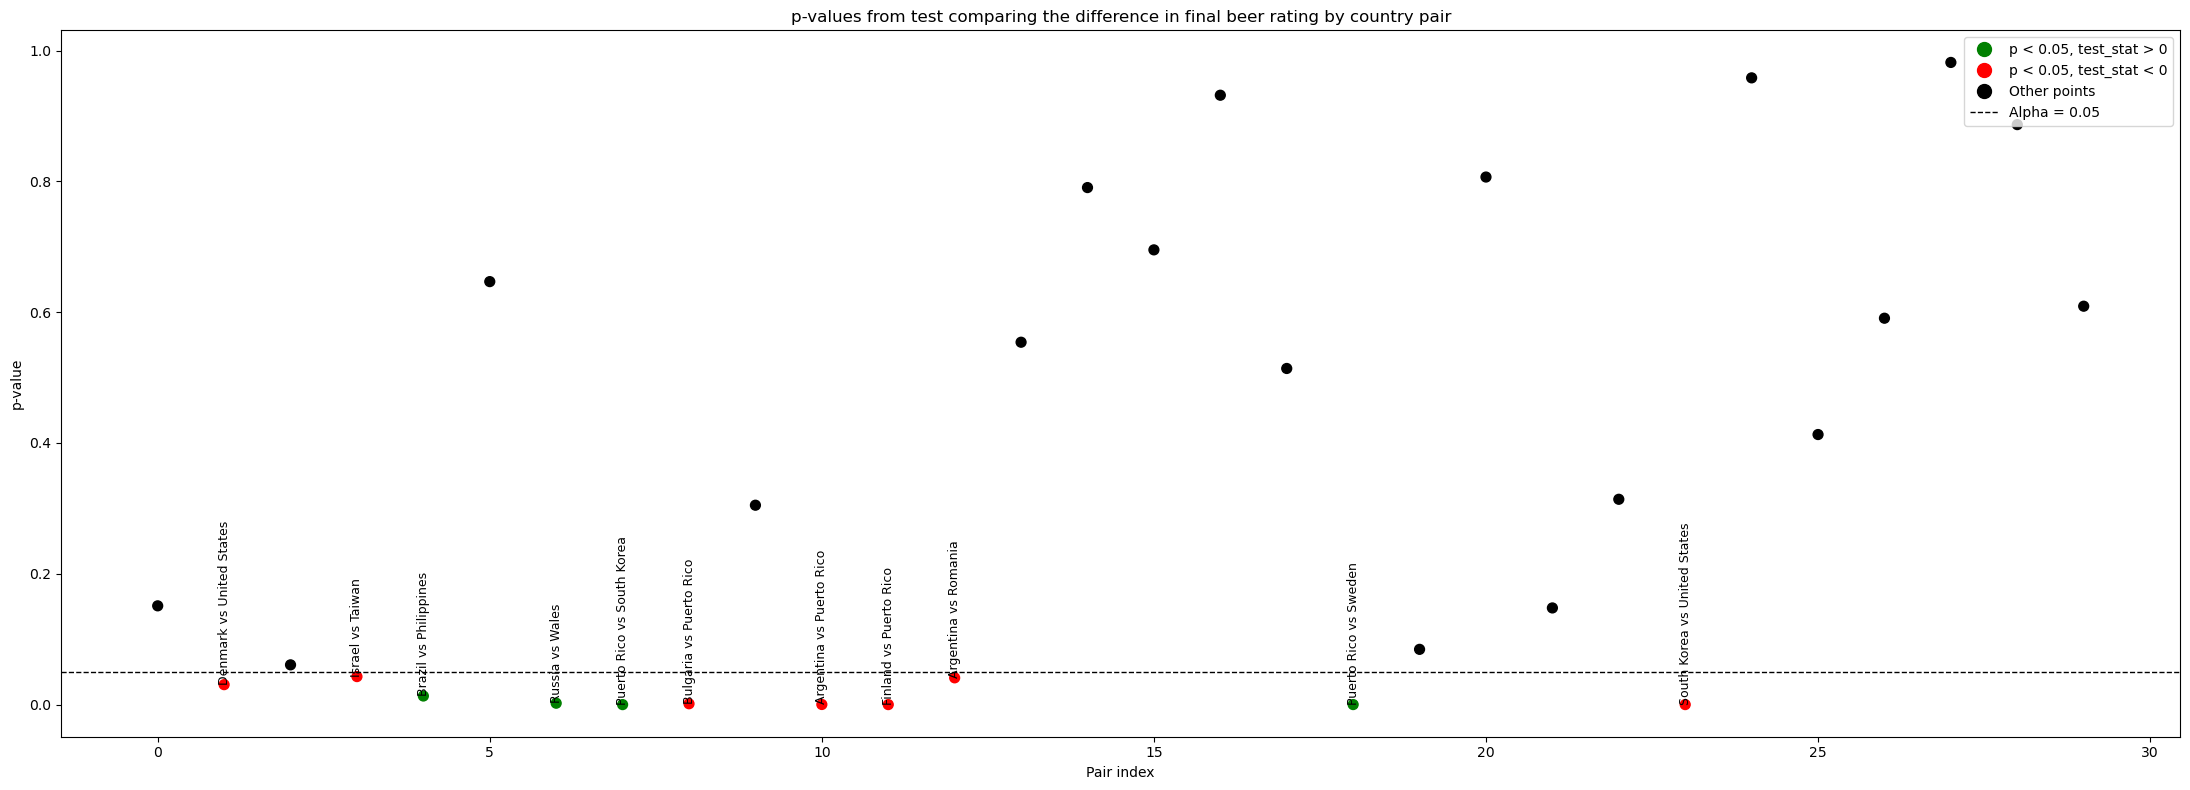

In [85]:
plot_pvalues(results_df)

We can see that few country pairs had enough matches with respect to our threshold, as shown by the low number of data points.

We observe that there are several country pairs for which there is a significant difference in final rating. For instance, we can see that after accounting for confounders, users from Filand tend to give ratings that are significantly lower than users from the Puerto Rico from a statistical standpoint. On the other hand, users from Russia tend to give ratings that are significantly higher than users from Wales from a statistical standpoint. These results suggest that users from certain regions tend to be more generous or more critical in their ratings compared to users from other countries.

In order to determine if these differences are also meaningful from a practical standpoint, we will look at their magnitude. We will plot a boxplot to visualize the distribution of differences in final beer rating between matched reviews for the 10 country pairs for which the t-test yielded the lowest p-values. This will allow us to assess both the direction and size of the differences in ratings.

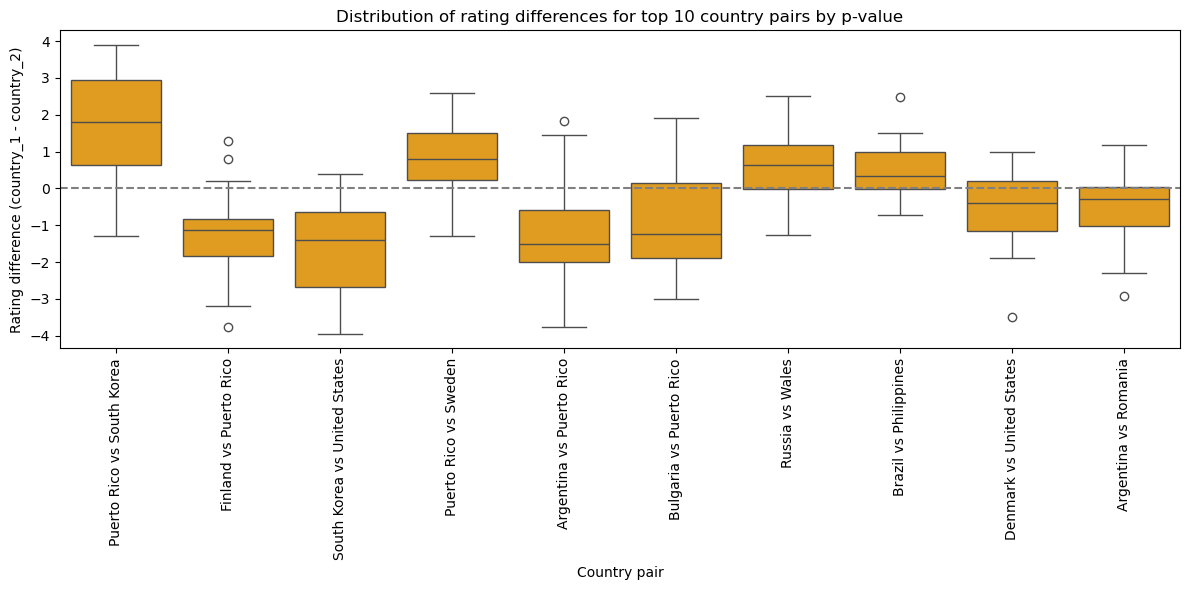

In [87]:
# plot a boxplot of rating differences for the top 10 country pairs (smallest p-values)
plot_top_10_pairs_boxplot(matched_data, results_df)

We observe that few boxes contain zero (zero is not comprised between Q1 and Q3). This means that for most of the top 10 country pairs with the lowest p-values, ratings from one country (country 1) are consistently higher or lower than those from the other country (country 2) for most paired reviews in the sample. This implies that the majority of matched reviews for most of of these country pairs show a meaningful and unidirectional difference in ratings. In addition, the median for some country pairs is larger than 1 in absolute value. A difference of 1 out of 5 is large, which means that for these country pairs, the differences in ratings are not only statistically significant but also meaningful from a practical standpoint.

**Conclusion**

Our analysis suggests that, after accounting for potential confounders, users from certain countries appear more generous in their ratings compared to users from other countries. Clear trends in rating differences were observed for certain country pairs, with the differences appearing significant from both a statistical and practical standpoint. These findings align with the hypothesis that a "cultural bias" might influence beer reviewers, potentially impacting beer ratings.

However, the matching process did not yield sufficient matches for all countries, which restricted our ability to make meaningful comparisons across a broader range of country pairs. In addition, a significant bias was only observed for some specific country pairs, meaning our results do not support the conclusion that this bias is a general or universal phenomenon. Further research would be needed to clarify the role of cultural bias in beer ratings.

## b) Beer origin bias

In this part, we will investigate whether users rate domestic beers higher than foreign ones. 

To do so, we will start by labeling each review as either domestic (reviewing a beer produced in the reviewer’s country) or foreign. We will then match reviews of domestic and foreign beers from the same user. We will also make sure that matched reviews correspond to the same beer style to account for the effect of beer style on ratings.

We subsequently perform a paired t-test to determine whether the mean difference in ratings within pairs is significantly different from zero. We will perform this test again focusing only on  matched reviews from beer enthusiasts —users who have written a substantial number of reviews— who might prioritize intrinsic qualities of the beers over external factors such as location.

In [88]:
# create copies to avoid modifying the dataframes, selecting only necessary columns to reduce memory usage
columns_to_keep = ['user_id', 'style', 'rating', 'user_location', 'brewery_location', 'user_nb_reviews']

# sample 10% of rows to avoid memory overload and copy
ratings_origin_bias = total_ratings_loc_filtered[columns_to_keep].sample(frac=0.1, random_state=42).copy()

In [89]:
print("Number of selected reviews:",ratings_origin_bias.shape[0])

Number of selected reviews: 1480673


We are working with about one and a half million reviews, which seems largely sufficient to perform our analysis.

We will start by labeling reviews as either domestic or foreign. To do so, we will add a column to the review dataframe named 'domestic' containing booleans indicating whether the location of the brewery that produced the reviewed beer is the same as the location of the reviewer. Domestic reviews (reviewing a beer produced in the reviewer’s country) will have True in this column, whereas foreign reviews will have False.

In [90]:
# add column to identify domestic and foreign reviews
ratings_origin_bias['domestic'] = (ratings_origin_bias['brewery_location'] == ratings_origin_bias['user_location'])
ratings_origin_bias['domestic'].value_counts()

domestic
True     1030454
False     450219
Name: count, dtype: int64

**Analysis on all types of reviewers**

We will now match domestic and foreign reviews from the same user and reviewing a beer of the same style. Matching for the same beer style will allow us to account for the effect of beer style on ratings.

In [91]:
# perform review matching
matched_reviews = match_reviews(
    df=ratings_origin_bias, 
    filter_column='domestic', 
    group1_value=True, 
    group2_value=False, 
    join_columns=['user_id', 'style'], 
    suffixes=('_domestic', '_foreign')
)
matched_reviews.head()

index_domestic           user_id                   style  rating_domestic  \
0          9869742           71317.0          Imperial Stout             4.20   
3          4354605     ricochet.7102  Fruit / Vegetable Beer             4.40   
4         13945149           21197.0                  Bitter             2.70   
22         1532657  agentzero.351054  Russian Imperial Stout             3.52   
25        13536321          137343.0    Golden Ale/Blond Ale             2.80   

   user_location_domestic brewery_location_domestic  user_nb_reviews_domestic  \
0                 Finland                   Finland                    1719.0   
3           United States             United States                     502.0   
4                 England                   England                    5248.0   
22          United States             United States                    1739.0   
25                England                   England                   10210.0   

    domestic_domestic  review_id_domestic  index_foreign  rating_foreign  \
0                True                   4       13765817            3.40   
3                True                   5         271465            3.63   
4                True                  10       13382494            3.10   
22               True                  11        1115509            3.48   
25               True                  13       13383091            2.60   

   user_location_foreign brewery_location_foreign  user_nb_reviews_foreign  \
0                Finland                  England                   1719.0   
3          United States                   Canada                    502.0   
4                England                 Scotland                   5248.0   
22         United States                      NaN                   1739.0   
25               England                 Scotland                  10210.0   

    domestic_foreign  review_id_foreign  
0              False               3310  
3              False             854950  
4              False              21561  
22             False              35743  
25             False              27114

In [92]:
print('Number of matched reviews:', matched_reviews.shape[0])

Number of matched reviews: 79910


We obtained nearly 80 thousand matches of distinct reviews, which seems sufficieny to perform our analysis.

In order to determine whether there is a statistically significant difference between the final ratings of matched reviews, we will perform a paired t-test.

In [93]:
# t-test comparing final ratings within pairs
t_stat, p_value = ttest_rel(matched_reviews['rating_domestic'], matched_reviews['rating_foreign'])
print("t-statistic =", t_stat)
print("p-value =", p_value)

t-statistic = -11.991501524155565
p-value = 4.2035754887595925e-33


We observe that the p-value is extremely small. This suggests that the mean difference in final rating between matched domestic and foreign reviews is significantly different from zero. In addition, we notice that the test statistic is negative. This implies a counter-intuitive phenomenon: domestic reviews appear to have lower ratings than matched foreign ratings on average.

To further explore this phenomenon and get an idea of the distribution of rating differences within matched reviews, we will plot the histogram of these differences.

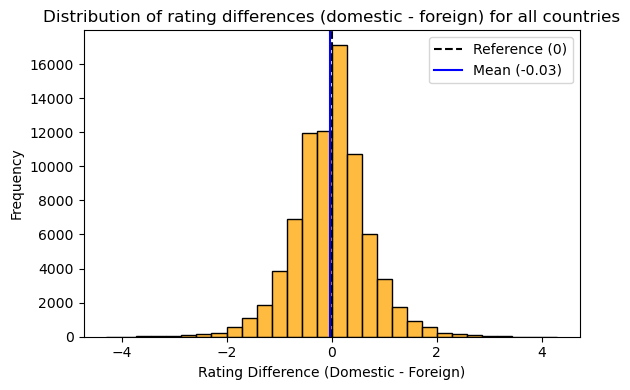

In [94]:
# calculate the rating differences
matched_reviews['rating_difference'] = matched_reviews['rating_domestic'] - matched_reviews['rating_foreign']


# plot the histogram of rating differences for all countries combined
plot_rating_differences_histogram(
    data=matched_reviews, 
    diff_column='rating_difference', 
    custom_title='Distribution of rating differences (domestic - foreign) for all countries'
)

We can see that the distribution of rating differences between matched domestic and foreign reviews is approximately symmetrical and centered around zero. The distribution is bell-shaped, with fewer data points with a rating difference farther from zero, and nearly no data points with a rating difference larger than 2. This implies that there is no clear trend in rating differences between matched domestic and foreign reviews. We can also see that the mean rating difference between matched reviews is very small (-0.03). We conclude that while the t-test detected a statistically significant difference between ratings of matched domestic and foreign reviews, the difference is actually not significant from a practical standpoint. The statistical significance may result from the large number of matched reviews, which can make even small differences appear statistically significant. 

In this way, the data suggest that there is no sign of a rating bias related to whether the reviewed beer is from the same country or a different country than the reviewer.

We will now visualize the distribution of rating differences between matched reviews for different countries separately. We will look at the 10 countries with the highest mean difference and consider only countries with matched reviews from at least 100 different reviewers to ensure results are representative.

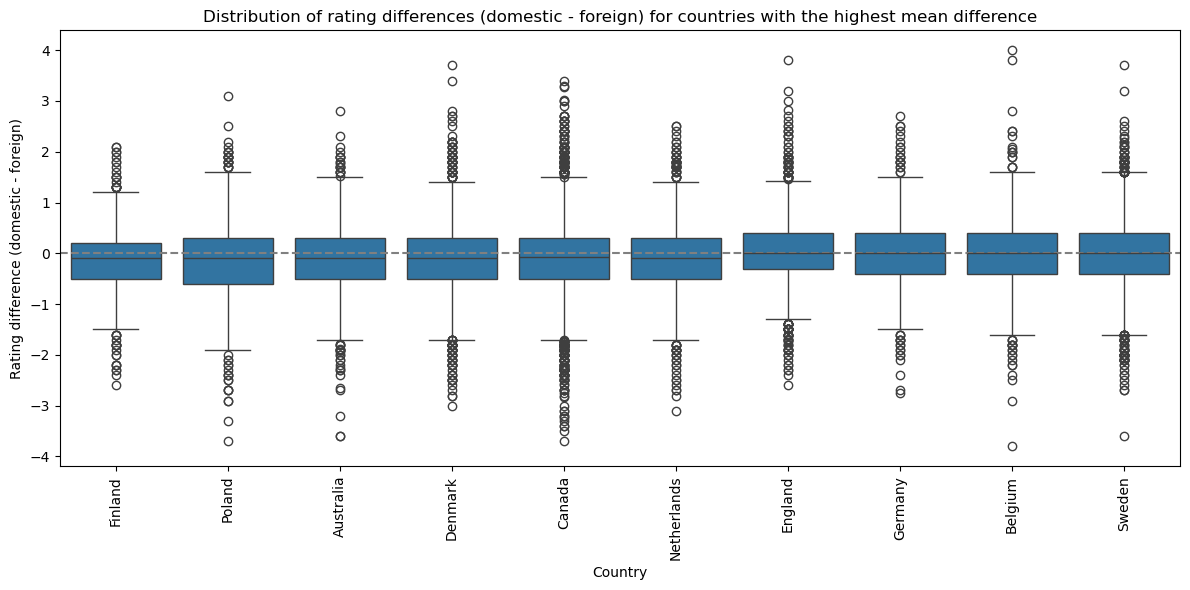

In [95]:
# calculate the number of unique reviewers (user_id) for each user_location_domestic
unique_user_counts = matched_reviews.groupby('user_location_domestic')['user_id'].nunique()

# filter for countries with ≥100 unique reviewers
valid_locations = unique_user_counts[unique_user_counts >= 100].index
matched_reviews_filtered = matched_reviews[matched_reviews['user_location_domestic'].isin(valid_locations)]

# plot the boxplot for the 10 countries with the highest mean differences
plot_top_10_boxplot(matched_reviews_filtered)

We can see that even for the 10 countries with the highest mean rating difference between matched reviews, the distribution of rating differences is centered around zero. For each of the 10 countries, the whiskers and outliers (circles) show a roughly balanced number of positive and negative extreme values. This suggests that there is no strong skew in the rating differences.

This means that even when looking at individual countries, there does not seem to be a particular rating bias related to whether the reviewed beer is from the same country or a different country than the reviewer.

**Focus on beer enthusiasts**

We will now focus only on matched reviews from beer enthusiasts, which correspond to users who wrote a significant number of reviews. We will consider that a beer enthusiast is a reviewer who wrote at least 50 reviews. Intuitively, we expect beer enthusiasts to be less sensitive to factors that are not related to the instrinsic qualities of a beer. Hence, we do not expect differences between pairs of matched reviews to be significant, especially since we observed that these differences were not practically significant when looking at all types of reviewers.

In [96]:
ENTHUSIAST_THRESHOLD = 50

# filter matched reviews from users who wrote at least 50 reviews
matched_reviews_enthusiasts = matched_reviews[matched_reviews['user_nb_reviews_domestic'] >= ENTHUSIAST_THRESHOLD]
print("Number of matched reviews from beer enthusiasts:", matched_reviews_enthusiasts.shape[0])

# t-test comparing final ratings within pairs
t_stat, p_value = ttest_rel(matched_reviews_enthusiasts['rating_domestic'], matched_reviews_enthusiasts['rating_foreign'])
print("t-statistic =", t_stat)
print("p-value =", p_value)

Number of matched reviews from beer enthusiasts: 65611
t-statistic = -11.845067868427941
p-value = 2.4624751457838154e-32


We have more than 65 thousand matched reviews from beer enthusiasts, which seems sufficient to perform our analysis.

The extremely small p-value indicates that the mean difference in final ratings between matched domestic and foreign reviews from beer enthusiasts is statistically significant. Furthermore, the negative test statistic indicates that domestic reviews tend to have lower ratings compared to their matched foreign counterparts on average. Again, these results may appear counter-intuitive and may seem to contradict our hypothesis that beer enthusiasts are less sensitive to factors that are not related to intrinsic beer characteristics. However, we have to keep in mind again that statistical significance does not imply practical significance, as we have seen in the previous part of the analysis.

As done previously, we will plot the histogram of the rating differences between matched reviews from beer enthusiasts to get an idea of the distribution and magnitude of these differences.

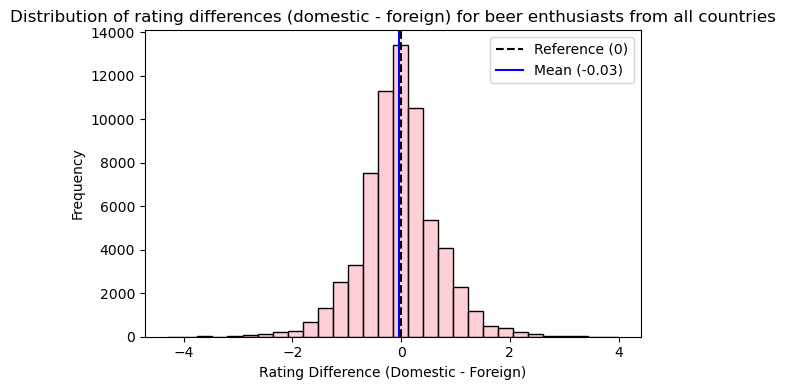

In [97]:
# calculate the rating differences
matched_reviews_enthusiasts['rating_difference'] = (matched_reviews_enthusiasts['rating_domestic'] - matched_reviews_enthusiasts['rating_foreign'])

# plot the histogram of rating differences for beer enthusiasts from all countries
plot_rating_differences_histogram(
    data=matched_reviews_enthusiasts, 
    diff_column='rating_difference', 
    color='pink',
    custom_title='Distribution of rating differences (domestic - foreign) for beer enthusiasts from all countries'
)

We observe that the distribution of rating differences between matched domestic and foreign reviews from beer enthusiats is very similar to the one we obtained in the previous part of the analysis.

The distribution is bell-shaped, approximately symmetrical and centered around zero. This indicates that there is no evident pattern in the rating differences between matched domestic and foreign reviews from beer enthusiasts. Additionally, the mean rating difference is again minimal (-0.03). While the t-test revealed a statistically significant difference in ratings between matched domestic and foreign reviews, this difference is again negligible in practical terms.

In this way, the data seems consistent with our hypothesis that beer enthusiasts are not influenced by the origin of beers in their ratings.

Just like in the previous part of the analysis, will visualize the distribution of rating differences between matched reviews from beer enthusiasts for different countries separately. We will again look at the 10 countries with the highest mean difference and consider only countries with matched reviews from at least 100 different reviewers to ensure results are representative.

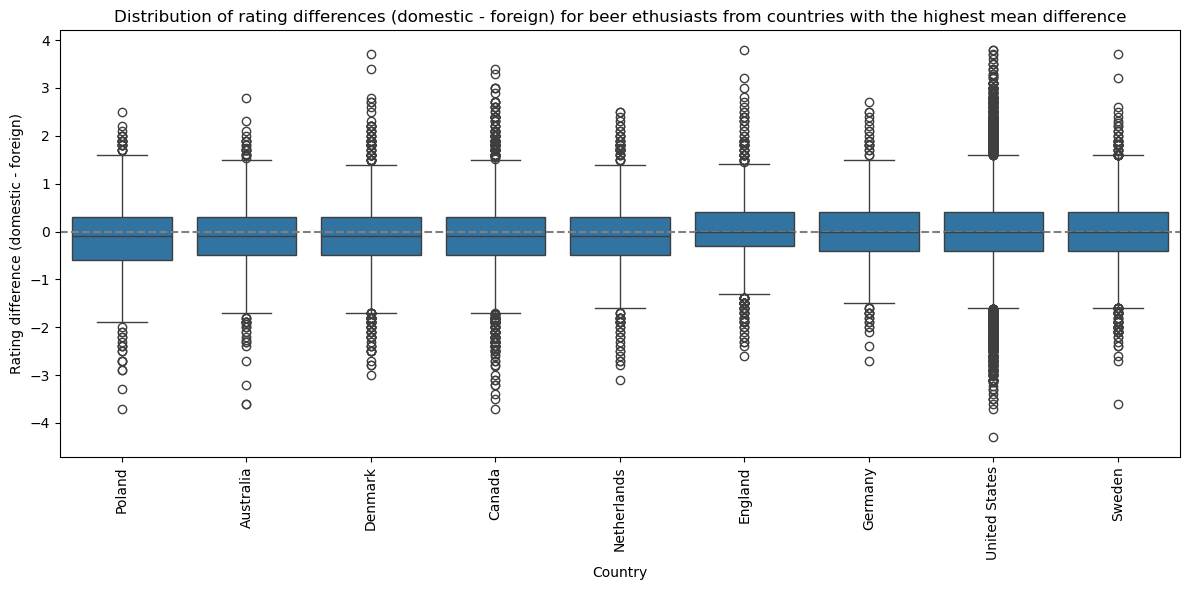

In [98]:
# calculate the number of unique reviewers (user_id) for each user_location_domestic
unique_user_counts = matched_reviews_enthusiasts.groupby('user_location_domestic')['user_id'].nunique()

# filter for countries with ≥100 unique reviewers
valid_locations = unique_user_counts[unique_user_counts >= 100].index
matched_reviews_enthusiasts_filtered = matched_reviews_enthusiasts[matched_reviews_enthusiasts['user_location_domestic'].isin(valid_locations)]

# plot the boxplot for the 10 countries with the highest mean differences
plot_top_10_boxplot(
    df=matched_reviews_enthusiasts_filtered,
    custom_title='Distribution of rating differences (domestic - foreign) for beer ethusiasts from countries with the highest mean difference'
)

Once again, we find that even for the 10 countries with the largest mean rating differences between matched reviews, the distribution of rating differences among beer enthusiasts is centered around zero. The whiskers and outliers for each of these countries indicate a roughly equal number of positive and negative extreme values, showing no significant skew in the differences.

This suggests that, even when analyzing individual countries, there is no clear evidence of rating bias among beer enthusiasts based on whether the beer being reviewed is domestic or foreign.

**Conclusion**

Our analysis revealed that the origin of beers do not seem to bias ratings. This was expected for beer enthusiasts, but our findings showed that this holds true when considering all users together.

# 3) Other biases

## a) Seasonal biases

In this part, we will examine how seasonal changes influence the ratings of different beer styles.

**Season labeling**

To start with, we will use the time information to determine the season during which each rating was posted. This task may be complex as some countries are in the Northern hemisphere and others are in the Southern hemisphere, and some may be located close to the Equator and may thus not even experience seasons! We will simplify things by only considering reviews from the 10 countries with the most reviews. We will determine whether they are in the Northern or Southern hemisphere and use the time information in the reviews to determine the season during which each review was posted.

Let us first identify the 10 countries with the most reviews.

In [64]:
# combine user locations from Beer Advocate and Rate Beer review dataframes
combined_user_locations = pd.concat([ba_ratings_loc_filtered['user_location'], rb_ratings_loc_filtered['user_location']])

# get the 10 most frequent values in the combined 'user_location' column
top_10_combined_locations = combined_user_locations.value_counts().head(10).index.tolist()

top_10_combined_locations

['United States',
 'Canada',
 'Denmark',
 'England',
 'Sweden',
 'Netherlands',
 'Germany',
 'Norway',
 'Finland',
 'Poland']

Let us know filter reviews from these countries only.

In [65]:
ba_ratings_top_10_locations = ba_ratings_loc_filtered[ba_ratings_loc_filtered['user_location'].isin(top_10_combined_locations)]
ba_ratings_top_10_locations['user_location'].value_counts()

user_location
United States    7303869
Canada            274512
England            41597
Sweden             29914
Netherlands        22952
Germany            17460
Finland             3076
Norway              3037
Poland              2225
Denmark              893
Name: count, dtype: int64

In [66]:
rb_ratings_top_10_locations = rb_ratings_loc_filtered[rb_ratings_loc_filtered['user_location'].isin(top_10_combined_locations)]
rb_ratings_top_10_locations['user_location'].value_counts()

user_location
United States    3177972
Denmark           581975
Canada            522693
England           440845
Sweden            283459
Netherlands       233741
Germany           218794
Norway            216892
Finland           191900
Poland            154391
Name: count, dtype: int64

We can see that the 10 locations with the highest number of reviews are all countries located in the Northern hemisphere. This will make it easier to determine the season during which reviews were posted. To do this, we will use a function called 'get_season', which determines the season based on the month information contained in a date (eg,'Winter' if the month is December, January or February) and that we have written in src/utils/data_utils.py, to create a new column called 'season' in rating dataframes.

In [67]:
ba_ratings_top_10_locations['season'] = ba_ratings_top_10_locations['date'].apply(lambda x: get_season(pd.to_datetime(x)))
rb_ratings_top_10_locations['season'] = rb_ratings_top_10_locations['date'].apply(lambda x: get_season(pd.to_datetime(x)))

In [68]:
ba_ratings_top_10_locations['season'].value_counts()

season
Summer    1972440
Winter    1956038
Spring    1929090
Fall      1841967
Name: count, dtype: int64

**Linear regression**

We will now perform a linear regression analysis with the final rating as the dependent variable and key predictors, namely season, average rating for the beer style, average rating for the brewery, user’s average rating and ABV as the independent variables. We will also include attribute ratings as independent variables, as they are important predictors of beer ratings, as seen in previous parts of the analysis. Since, as explained below, we will use the model to make predictions, we will need the model to have high R2 and low RMSE for the predictions to be accurate and interpretable. This is why we have to try to include all key predictors in the model.

We will then examine the regression coefficients for the season variable to see whether ratings are significantly higher or lower in certain seasons after accounting for confounders. Using these coefficients, we  will calculate predicted ratings for each beer style in each season and visualize the results with line charts. This will allow us to visualize how ratings fluctuate with the seasons and how these patterns differ across differentbeer styles.

#### Step 1: 
Our first step will consist in performing linear regression.

As seen in previous parts of the analysis, in RateBeer, aroma and taste ratings are rated out of 10 and not out of 5 like all other ratings. We will thus start converting them to ratings out of 5.

In [69]:
rb_ratings_top_10_locations['taste'] = rb_ratings_top_10_locations['taste'] / 2
rb_ratings_top_10_locations['aroma'] = rb_ratings_top_10_locations['aroma'] / 2

We will work on RateBeer and BeerAdvocate dataset together, so we will concatanate the corresponding dataframes.

In [70]:
# merging BeerAdvocate and RateBeer datasets
combined_ratings = pd.concat([ba_ratings_top_10_locations, rb_ratings_top_10_locations], ignore_index=True)

We will now isolate the columns corresponding to the variables that we will use in our linear regression analysis, and prepare the data for the regression. We will then perform the regression.

In [71]:
attributes = ['appearance', 'aroma', 'palate', 'taste'] 
combined_ratings_no_missing_attributes= combined_ratings.dropna(subset= attributes )
columns_to_keep = ['season', 'style', 'abv', 'user_avg_rating', 'brewery_avg_rating', 'style_avg_rating', 'rating', 'appearance', 'aroma', 'palate', 'taste']
data_reduced = combined_ratings_no_missing_attributes[columns_to_keep].dropna()

In [72]:
# perform one-hot encoding for the categorical season variable
# remove one of the columns to avoid introducing colinearity
data_reduced = pd.get_dummies(data_reduced, columns=['season'], drop_first=True)

In [73]:
# define the independent and the dependent variables
data_reduced = data_reduced.drop(columns=['style'])

X = data_reduced.drop(columns=['rating'])
y = data_reduced['rating']

In [74]:
# peform linear regression
# we also return the scaler because we will need it for our analysis
metrics, model, scaler = advanced_linear_regression(X, y, model_type='linear', scale_data=True, make_plots=False, print_summary=True, return_scaler=True)

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                 2.123e+07
Date:                Wed, 18 Dec 2024   Prob (F-statistic):               0.00
Time:                        13:51:01   Log-Likelihood:             4.9935e+06
No. Observations:             7128103   AIC:                        -9.987e+06
Df Residuals:                 7128091   BIC:                        -9.987e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5525    4.5e-05    7.9e+04      0.0

We have Training R2: 0.9704 This is an excellent fit. The model explains 97% of the variability in ratings, thus we conclude that model fits the data extremely well.We also have a MSE as 0.01442 which is very low, which means that the model's predictions are very close to the true values.

Our model seems thus good enough to work with predictions later in the analysis.

#### Step 2:
We will now examine the regression coefficients for the season to see how they affect beer ratings. Using all the other independent variables in the model helped isolate the effect of season on ratings.

In [75]:
# extract coefficients and their p-values from fitted regression model
linear_coefficients = model.params
p_values = model.pvalues

# combine feature names, coefficients, and p-values into a dataframe
feature_names = ['Intercept'] + list(X.columns)
linear_coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': linear_coefficients,
    'p-value': p_values
})
linear_coefficients_df

Feature  Coefficient       p-value
const           Intercept     3.552488  0.000000e+00
x1                    abv     0.002226  0.000000e+00
x2        user_avg_rating    -0.000319  1.289318e-07
x3     brewery_avg_rating     0.015163  0.000000e+00
x4       style_avg_rating    -0.001109  5.017367e-42
x5             appearance     0.076178  0.000000e+00
x6                  aroma     0.209587  0.000000e+00
x7                 palate     0.115837  0.000000e+00
x8                  taste     0.348882  0.000000e+00
x9          season_Spring    -0.000281  9.979510e-07
x10         season_Summer    -0.000373  6.309549e-11
x11         season_Winter    -0.000328  1.052942e-08

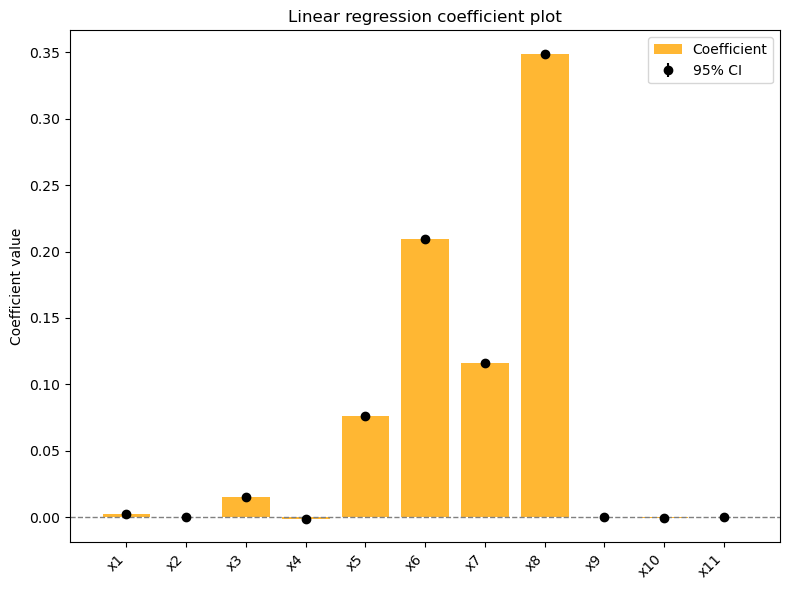

In [76]:
# extract coefficients and their confidence intervals from the model
conf_int = model.conf_int()

# plot coefficients
plot_coefficients(linear_coefficients, conf_int, "Linear regression coefficient plot", bar_color='orange')

We can see that the p-values of all the coefficients are zero or extremely small, indicating that all the independent variables included in the model are useful in explaining variations in ratings at a 5% significance level.

Attribute ratings (x5 to x8) are associated with the largest coefficients, meaning that they have the strongest influence on the final rating since we standardized the data.

On the other hand, coefficients of season_Spring (x9), season_Summer (x10) and season_Winter (x11) are much smaller than other coefficients. This can be seen in the above plot. This suggests that though season appears to have a statistically significant impact on beer ratings, it does not seem to be the dominant factor driving rating behavior. Other factors, such as attribute ratings and the brewery avergae rating, seem to play a much larger role.

#### Step 3: 
Using the regression coefficients, we will calculate the predicted ratings for each beer style in each season, and create a table with columns for season, beer style and predicted rating.

In [77]:
season_columns = [col for col in data_reduced.columns if col.startswith('season_')]
seasons = [col.replace('season_', '') for col in season_columns]
seasons

['Spring', 'Summer', 'Winter']

In [78]:
styles = combined_ratings['style'].unique()

In [79]:
# we will have combinations of all unique seasons and styles
combinations = pd.DataFrame(list(product(seasons, styles)), columns=['season', 'style'])

grouped_data = combined_ratings.groupby('style').agg({
    'abv': 'mean',
    'user_avg_rating': 'mean',
    'brewery_avg_rating': 'mean',
    'style_avg_rating': 'mean',
    'appearance': 'mean',
    'aroma': 'mean',
    'palate': 'mean',
    'taste': 'mean'
}).reset_index()

In [80]:
combinations = combinations.merge(grouped_data, on='style', how='left')

#one-hot encoded columns
for season in seasons:
    combinations[f'season_{season}'] = (combinations['season'] == season).astype(int)

In [81]:
print(combinations[['season_Spring', 'season_Summer', 'season_Winter']].sum())


season_Spring    183
season_Summer    183
season_Winter    183
dtype: int64


In [82]:
combinations = combinations.drop(columns=['season'], errors='ignore')


In [83]:
#drop missing values
numerical_features = [
    'abv', 'user_avg_rating', 'brewery_avg_rating', 
    'appearance', 'aroma', 'palate', 'taste', 'style_avg_rating'
]
combinations = combinations.dropna(subset=numerical_features)

In [84]:
#scale using the same scaler used during training
combinations[numerical_features] = scaler.fit_transform(combinations[numerical_features])

In [85]:
X_pred = combinations.drop(columns=['style'])
X_pred = sm.add_constant(X_pred)#added intercept

In [86]:
print("Columns in X_pred:", X_pred.columns)
print("Columns expected by the model:", model.params.index)


Columns in X_pred: Index(['const', 'abv', 'user_avg_rating', 'brewery_avg_rating',
       'style_avg_rating', 'appearance', 'aroma', 'palate', 'taste',
       'season_Spring', 'season_Summer', 'season_Winter'],
      dtype='object')
Columns expected by the model: Index(['const', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10',
       'x11'],
      dtype='object')


We need to convert the column names. 

In [87]:
column_mapping = {
    'const': 'const',
    'abv': 'x1',
    'user_avg_rating': 'x2',
    'brewery_avg_rating': 'x3',
    'style_avg_rating': 'x4',
    'appearance': 'x5',
    'aroma': 'x6',
    'palate': 'x7',
    'taste': 'x8',
    'season_Spring': 'x9',
    'season_Summer': 'x10',
    'season_Winter': 'x11'
}

# renamed columns in X_pred 
X_pred_renamed = X_pred.rename(columns=column_mapping)
X_pred_renamed = X_pred_renamed[model.params.index]

In [88]:

predicted_ratings = model.predict(X_pred_renamed)
combinations['predicted_rating'] = predicted_ratings

print(combinations[['style', 'predicted_rating']].head())

              style  predicted_rating
0   Euro Pale Lager          2.821257
1  English Pale Ale          3.258526
2    English Bitter          3.786328
3     Irish Red Ale          3.733850
4    American Stout          4.273471


We put the predicted ratings into a table where rows represent beer styles, columns represent seasons and each cell contain the predicted ratings.

In [89]:
#one-hot encoded columns
combinations['season'] = combinations.apply(
    lambda row: 'Spring' if row['season_Spring'] == 1 else
                'Summer' if row['season_Summer'] == 1 else
                'Winter' if row['season_Winter'] == 1 else None, axis=1
)

predicted_table = combinations.pivot_table(
    values='predicted_rating',
    index='style',
    columns='season',
    fill_value=0
)

display(predicted_table)


season                     Spring    Summer    Winter
style                                                
Abbey Dubbel             3.516284  3.516192  3.516237
Abbey Tripel             3.557007  3.556914  3.556960
Abt/Quadrupel            4.117676  4.117584  4.117629
Altbier                  3.428914  3.428822  3.428867
Amber Ale                2.997335  2.997242  2.997288
...                           ...       ...       ...
Wheat Ale                2.764863  2.764771  2.764816
Wheatwine                4.389537  4.389445  4.389490
Winter Warmer            4.004949  4.004857  4.004902
Witbier                  3.381376  3.381283  3.381329
Zwickel/Keller/Landbier  2.927924  2.927832  2.927878

[182 rows x 3 columns]

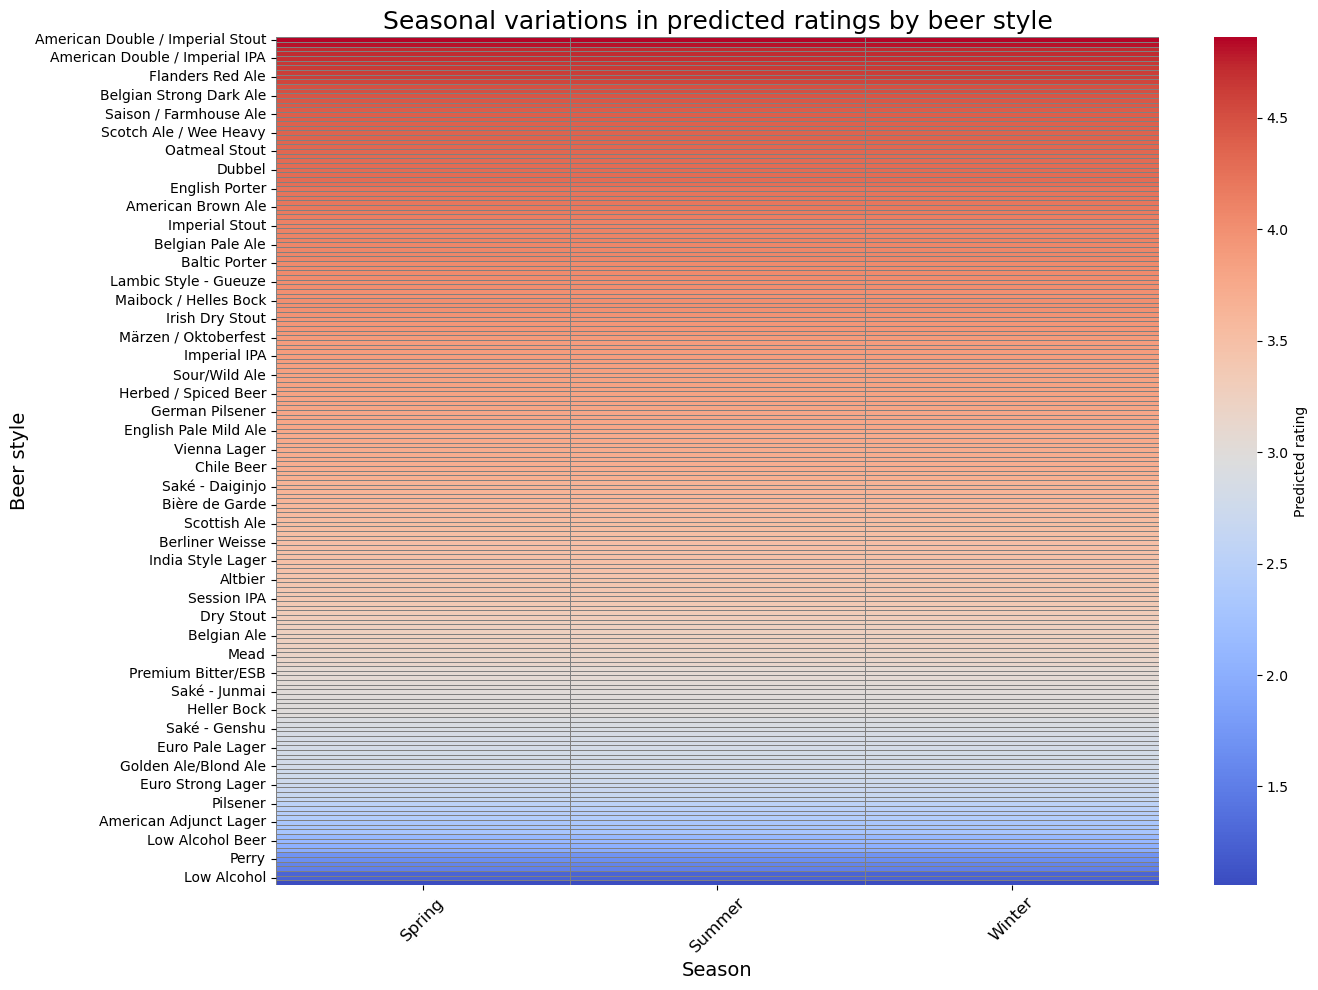

In [90]:
# plot a heatmap of predicted beer ratings across different seasons and beer styles
plot_seasonal_heatmap(predicted_table)

We observe that most beer styles show no visible color variations accross seasons. This suggests that the predicted ratings for most beer styles are the same regardless of the season. The season has very small effect on the predicted ratings. This was expected from the very small regression coefficients for the season variable.

#### Step 4: 
We will now use line charts to show the seasonal trends for different beer styles. For a more fine-grained analysis, we will look at the seasonal variations of several subsets of beer styles.

We will first considered the 10 beer styles with the highest average predicted rating by the model.

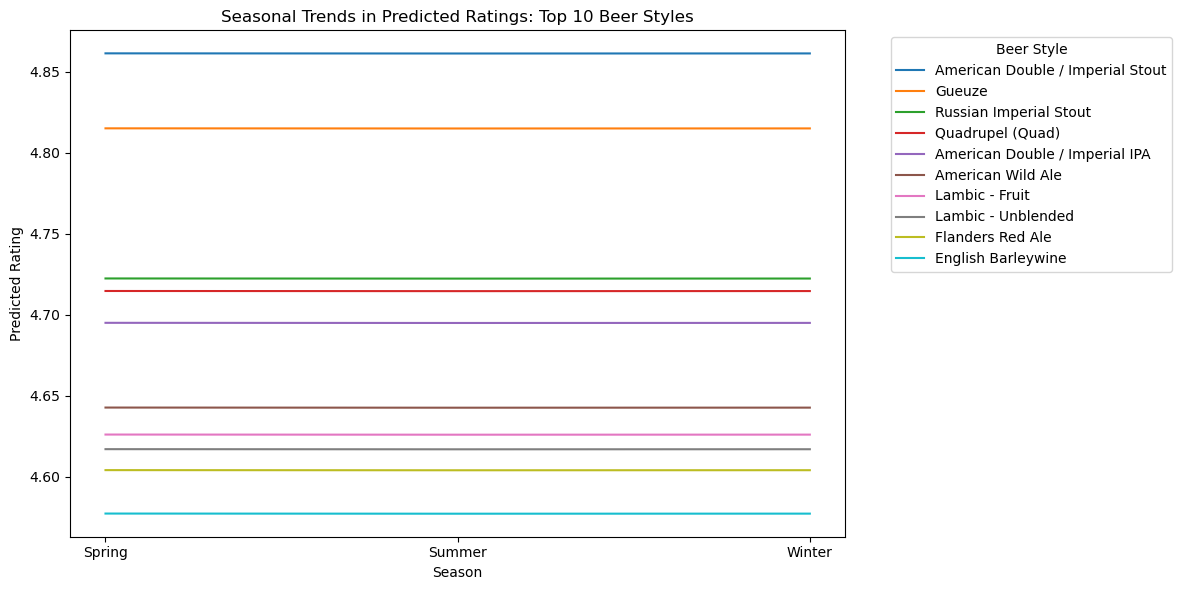

In [91]:
predicted_table['average_rating'] = predicted_table.mean(axis=1)

# select the 10 beer styles with the highest average predicted rating
top_10_styles = predicted_table.sort_values(by='average_rating', ascending=False).head(10)
top_10_styles = top_10_styles.drop(columns=['average_rating'])

top_10_predicted(top_10_styles,'Top')

There is no noticeable variation across seasons for the top-rated beer styles: the lines appear flat. These beer styles, eg American Double, Quadrupel, Gueuze etc. are consistently rated highly regardless of the season. The ratings of these beers seem to be not affected by the seasons.

We will now look at the the 10 beer styles with the lowest average predicted rating.

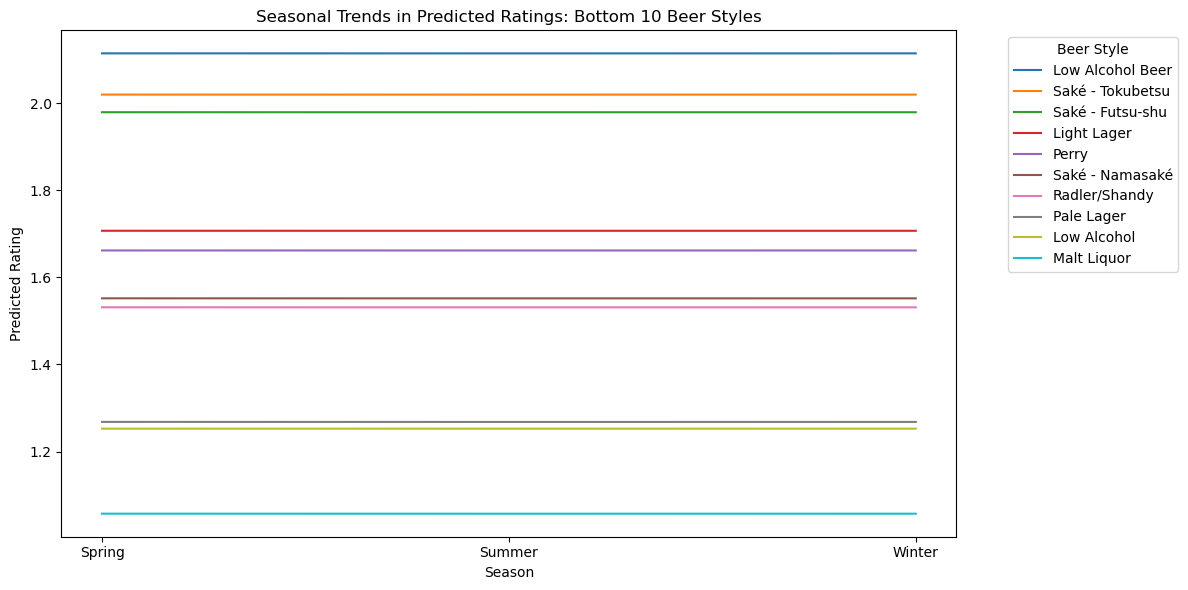

In [92]:
bottom_10_styles = predicted_table.sort_values(by='average_rating', ascending=False).tail(10)
bottom_10_styles = bottom_10_styles.drop(columns=['average_rating'])

# select the 10 beer styles with the lowest average predicted rating

top_10_predicted(bottom_10_styles,'Bottom')

These poorly rated beer styles consistently receive low ratings accross seasons. There is not a visible difference of ratings between the seasons for these beer styles. We again observe that seasons does not seem to be an important factor in determining beer ratings.

We will now look at average predicted ratings for all beer styles combined across seasons.

In [93]:
#  calculate the average predicted rating for each season
average_ratings_by_season = combinations.groupby('season')['predicted_rating'].mean()
print("Average Predicted Ratings by Season:")
print(average_ratings_by_season)

Average Predicted Ratings by Season:
season
Spring    3.552208
Summer    3.552115
Winter    3.552161
Name: predicted_rating, dtype: float64


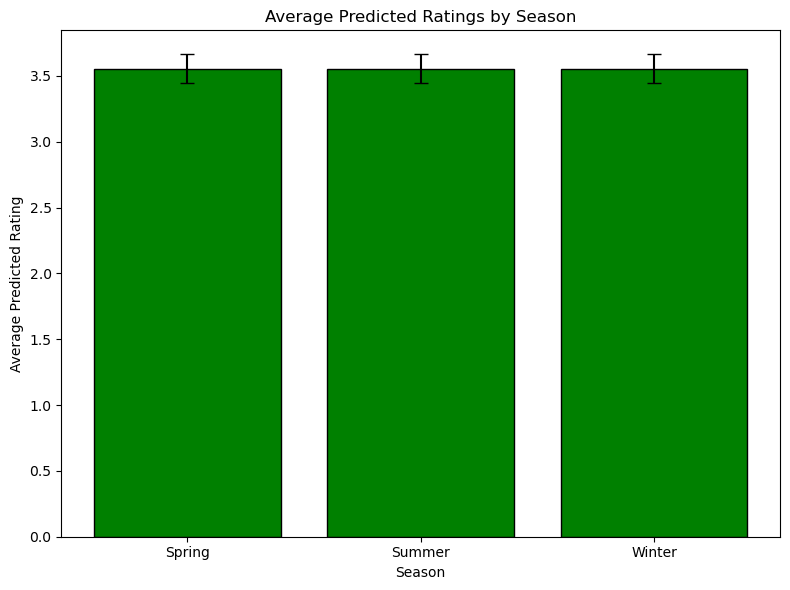

In [101]:
season_stats = combinations.groupby('season')['predicted_rating'].agg(['mean', 'std', 'count'])

# we add 95% confidence interval
season_stats['ci'] = 1.96 * (season_stats['std'] / np.sqrt(season_stats['count']))

plt.figure(figsize=(8, 6))
plt.bar(
    season_stats.index, 
    season_stats['mean'],
    yerr=season_stats['ci'],
    color='green',
    edgecolor='black',
    capsize=5 
)

# plot average predicted ratings by season

plt.title("Average Predicted Ratings by Season")
plt.xlabel("Season")
plt.ylabel("Average Predicted Rating")
plt.tight_layout()
plt.show()

The bars all have approximately the same height. This means that average predicted ratings do not vary significantly across seasons for all beer styles combined.

We will now calculate the range of predicted ratings for each beer style across seasons as the difference between the highest predicted rating and the lowest predicted ratig for each beer style.We will compare this range between beer style with the highest variation in predicted ratings and the beer styles with the lowest variation in predicted ratings.


In [97]:
# calculate range (max - min) of predicted ratings for each beer style across seasons
predicted_table['rating_range'] = predicted_table.max(axis=1) - predicted_table.min(axis=1)

styles_with_seasonal_variation = predicted_table.sort_values(by='rating_range', ascending=False)

# select beer styles with highest seasonal variation
print("Beer Styles with Highest Seasonal Variation in Predicted Ratings:")
top_10_variations = styles_with_seasonal_variation.head(10)
display(top_10_variations)


Beer Styles with Highest Seasonal Variation in Predicted Ratings:


season                            Spring    Summer    Winter  average_rating  \
style                                                                          
Belgian Strong Dark Ale         4.456575  4.456482  4.456528        4.456528   
American Double / Imperial IPA  4.695091  4.694998  4.695044        4.695044   
Rye Beer                        4.231212  4.231119  4.231165        4.231165   
Scotch Ale / Wee Heavy          4.370876  4.370783  4.370829        4.370829   
Flanders Oud Bruin              4.428150  4.428058  4.428103        4.428104   
Flanders Red Ale                4.604138  4.604046  4.604091        4.604092   
Foreign / Export Stout          4.288984  4.288891  4.288937        4.288937   
Braggot                         4.107923  4.107831  4.107877        4.107877   
Berliner Weissbier              4.403596  4.403503  4.403549        4.403549   
Belgian Dark Ale                4.009840  4.009748  4.009794        4.009794   

season                          rating_range  
style                                         
Belgian Strong Dark Ale             0.000092  
American Double / Imperial IPA      0.000092  
Rye Beer                            0.000092  
Scotch Ale / Wee Heavy              0.000092  
Flanders Oud Bruin                  0.000092  
Flanders Red Ale                    0.000092  
Foreign / Export Stout              0.000092  
Braggot                             0.000092  
Berliner Weissbier                  0.000092  
Belgian Dark Ale                    0.000092

In [98]:
# select beer styles with lowest seasonal variation
least_10_variations = styles_with_seasonal_variation.tail(10)
display(least_10_variations)

season                    Spring    Summer    Winter  average_rating  \
style                                                                  
English Barleywine      4.577321  4.577229  4.577275        4.577275   
Gueuze                  4.815177  4.815085  4.815130        4.815131   
Gose                    4.302547  4.302455  4.302501        4.302501   
German Hefeweizen       3.033548  3.033455  3.033501        3.033501   
Fruit Beer              2.797982  2.797889  2.797935        2.797935   
Fruit / Vegetable Beer  3.700698  3.700606  3.700651        3.700652   
Euro Dark Lager         3.591253  3.591161  3.591207        3.591207   
English Porter          4.234540  4.234448  4.234493        4.234494   
English Brown Ale       3.893274  3.893181  3.893227        3.893227   
Hefeweizen              4.076794  4.076702  4.076748        4.076748   

season                  rating_range  
style                                 
English Barleywine          0.000092  
Gueuze                      0.000092  
Gose                        0.000092  
German Hefeweizen           0.000092  
Fruit Beer                  0.000092  
Fruit / Vegetable Beer      0.000092  
Euro Dark Lager             0.000092  
English Porter              0.000092  
English Brown Ale           0.000092  
Hefeweizen                  0.000092

We observe that the rating_range values are the same between both subsets, though the difference was expected to be the largest possible. This confirms that seasonal variations do not seem to significantly influence beer ratings from a practical standpoint.

## b) Experience biais

**Data preparation**

To analyze how users’ rating tendencies evolve with experience, we will focus on users who have posted a substantial number of reviews, based on a chosen threshold. Let us set that threshold arbitrarily to 15 reviews, which seems like a number of reviews that is high enough to be able to define different experience levels.

First, let us verify that we have enough users who wrote at least this many reviews.

In [117]:
REVIEW_NB_THRESHOLD = 15

# calculate the counts of each 'user_id' in the review dataframes
ba_user_counts = ba_ratings['user_id'].value_counts()
rb_user_counts = rb_ratings['user_id'].value_counts()

# keep only user_id values that appear at least 15 times
ba_prolific_users = ba_user_counts[ba_user_counts >= REVIEW_NB_THRESHOLD].index.tolist()
rb_prolific_users = rb_user_counts[rb_user_counts >= REVIEW_NB_THRESHOLD].index.tolist()

print("Number of users who wrote at least",REVIEW_NB_THRESHOLD,"reviews:")
print('Beer Advocate:',len(ba_prolific_users))
print('Rate Beer:',len(rb_prolific_users))

Number of users who wrote at least 15 reviews:
Beer Advocate: 39945
Rate Beer: 13834


We have about 40 and 14 thousand users who wrote at least 15 reviews on Beer Advocate and Rate Beer, respectively, which seems to be enough data to do perform our analysis. We can also note that we have significantly more data from Beer Advocate than from Rate Beer.
Let us now isolate reviews from these users.

In [118]:
# filter rating dataframes to isolate users who wrote at least 15 reviews
prolific_ba_users_ratings = ba_ratings[ba_ratings.user_id.isin(ba_prolific_users)]
prolific_rb_users_ratings = rb_ratings[rb_ratings.user_id.isin(rb_prolific_users)]

Our analysis will start by sorting the reviews of each user chronologically and assigning an "experience level" to each rating based on the number of reviews they had posted up to that point. These levels will be predefined and consistent across all users: new reviewer (first n reviews), amateur (from the n+1th to the oth review), and expert (from the o+1th review onward).

Let us define these experience levels arbitrarily: we will consider that a user is a new reviewer for the first 5 reviews, an amateur for the 6th to the 10th review and and expert starting from the 11th review. In our analysis, we will compare reviews from "new reviewers" and from "expert reviewers", which correspond to the extremes of the defined experience spectrum.

In [119]:
# define experience levels
NEW_REVIEWER_THRESHOLD = 5
AMATEUR_THRESHOLD = 10

Let us now add experience levels to the reviews of users who wrote at least 15 reviews

In [120]:
ba_ratings_with_experience_levels = assign_experience_level(prolific_ba_users_ratings, NEW_REVIEWER_THRESHOLD, AMATEUR_THRESHOLD)
ba_ratings_with_experience_levels.sample(5)

beer_name   beer_id                     brewery_name  \
3710170  Where The Helles Summer?  147101.0    Southern Tier Brewing Company   
6860952      New Holland The Poet    8322.0      New Holland Brewing Company   
5044120              Vienna Lager   46793.0  Devils Backbone Brewing Company   
166590                  Hobgoblin     236.0     Wychwood Brewery Company Ltd   
6062501        Devil's Millhopper  117433.0        Alligator Brewing Company   

         brewery_id                                style  abv  \
3710170      3818.0                  Munich Helles Lager  4.6   
6860952       335.0                        Oatmeal Stout  5.2   
5044120     18539.0                         Vienna Lager  5.2   
166590        160.0  Extra Special / Strong Bitter (ESB)  5.2   
6062501     25133.0                         American IPA  NaN   

                       date        user_name                 user_id  \
3710170 2015-04-29 10:00:00         Pens1967         pens1967.758709   
6860952 2015-04-02 10:00:00           emills           emills.842689   
5044120 2014-07-06 10:00:00  Fantasy_Draught  fantasy_draught.820293   
166590  2014-01-06 11:00:00           Jose9e           jose9e.622380   
6062501 2015-03-13 11:00:00      Dayvcrocket      dayvcrocket.397021   

         appearance  aroma  palate  taste  overall  rating  user_avg_rating  \
3710170         4.0    3.5     4.0   3.75     3.75    3.73         3.690733   
6860952         4.5    4.5     5.0   4.75     4.75    4.70         4.349773   
5044120         NaN    NaN     NaN    NaN      NaN    4.00         3.869762   
166590          NaN    NaN     NaN    NaN      NaN    4.25         3.661193   
6062501         4.0    5.0     4.0   4.25     4.50    4.44         4.182442   

         brewery_avg_rating  style_avg_rating  user_nb_reviews  \
3710170            3.934824          3.666693              1.0   
6860952            3.828267          3.938648              0.0   
5044120            3.706212          3.556377              1.0   
166590             3.605743          3.704078              0.0   
6062501            3.796933          3.957763              2.0   

        experience_level  
3710170           expert  
6860952           expert  
5044120          amateur  
166590            expert  
6062501           expert

In [134]:
rb_ratings_with_experience_levels = assign_experience_level(prolific_rb_users_ratings, NEW_REVIEWER_THRESHOLD, AMATEUR_THRESHOLD)

**Linear regression**

The first part of our analysis will consist of a linear regression aiming at quantifying the effect of experience level on ratings while simultaneously adjusting for potential confounders. The dependent variable will be the final rating of the beer, and the key independent variable will be the experience level of the user. We will also include additional independent variables corresponding to potential confounders, namely the average rating for the corresponding beer style, the average rating for the corresponding brewery and user generosity (the average rating for the corresponding user).

Let us start by removing potential NaN values from the dataframes produced in the previous part.

In [135]:
print("Initial number of reviews (BeerAdvocate):",ba_ratings_with_experience_levels.shape[0])
ba_ratings_with_experience_levels = ba_ratings_with_experience_levels.dropna()
print("Number of reviews after NaN removal (BeerAdvocate):",ba_ratings_with_experience_levels.shape[0])

print("Initial number of reviews (RateBeer):",rb_ratings_with_experience_levels.shape[0])
rb_ratings_with_experience_levels = rb_ratings_with_experience_levels.dropna()
print("Number of reviews after NaN removal (RateBeer):",rb_ratings_with_experience_levels.shape[0])

Initial number of reviews (BeerAdvocate): 8014572
Number of reviews after NaN removal (BeerAdvocate): 4457719
Initial number of reviews (RateBeer): 6961724
Number of reviews after NaN removal (RateBeer): 6789140


We will now perform linear regression using the advanced_linear_regression helper function in data_utils.py.

In [119]:
# define features and the target variable
X_ba = ba_ratings_with_experience_levels[["experience_level","style_avg_rating","user_avg_rating","brewery_avg_rating"]]
y_ba = ba_ratings_with_experience_levels["rating"]

X_rb = rb_ratings_with_experience_levels[["experience_level","style_avg_rating","user_avg_rating","brewery_avg_rating"]]
y_rb = rb_ratings_with_experience_levels["rating"]

Experience level is a categorical variable, hence we need to perform one-hot encoding for the corresponding column.

In [120]:
X_ba = pd.get_dummies(X_ba, columns=['experience_level'], drop_first=True)
X_rb = pd.get_dummies(X_rb, columns=['experience_level'], drop_first=True)
X_ba.head()

style_avg_rating  user_avg_rating  brewery_avg_rating  \
8066930          4.199219         4.187515            4.293222   
7506943          4.189310         4.187515            3.814326   
5304312          4.163594         4.187515            3.957581   
6886756          3.957763         4.187515            4.000324   
4486754          4.163594         4.187515            3.949614   

         experience_level_expert  experience_level_new_reviewer  
8066930                    False                           True  
7506943                    False                           True  
5304312                    False                           True  
6886756                    False                           True  
4486754                    False                           True

In [121]:
# perform linear regression on BeerAdvocate data
metrics_ba, model_ba = advanced_linear_regression(X_ba, y_ba, model_type='linear', make_plots=False, scale_data=True, test_size=0.2, print_summary=True)

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                 5.134e+05
Date:                Tue, 17 Dec 2024   Prob (F-statistic):               0.00
Time:                        10:11:05   Log-Likelihood:            -2.0186e+06
No. Observations:             3566175   AIC:                         4.037e+06
Df Residuals:                 3566169   BIC:                         4.037e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8910      0.000   1.72e+04      0.0

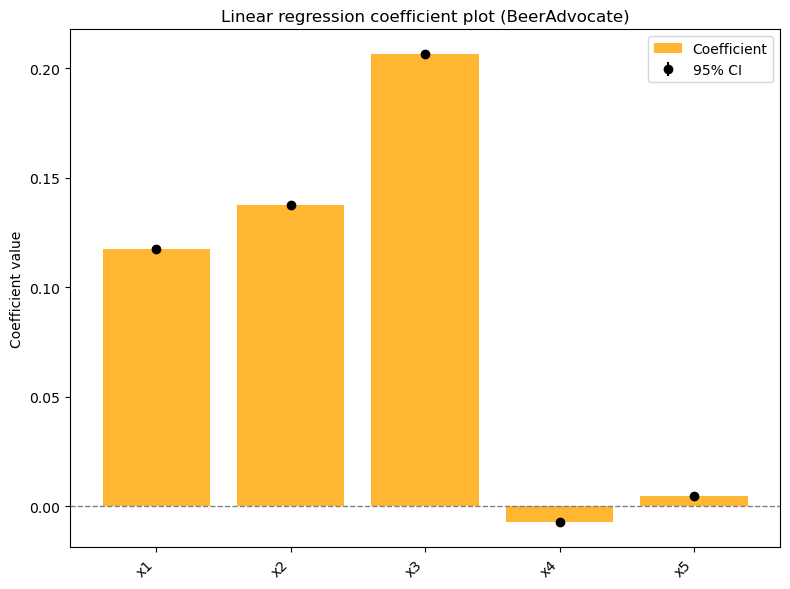

In [122]:
# extract coefficients and their confidence intervals from the model
coefficients_ba = model_ba.params
conf_int_ba = model_ba.conf_int()

# plot coefficients
plot_coefficients(coefficients_ba, conf_int_ba, "Linear regression coefficient plot (BeerAdvocate)", bar_color='orange')

We can make several observations:
- R2 = 0.41, meaning that 41% of the variation in the final rating is explained by the model; 59% remains unexplained and is likely due to other factors that we did not include in the model
- the p-values of all coefficients, including those corresponding to user experience levels, namely x4 and x5, are extremely small (written as null in the model summary), which indicates that the chosen features are useful in explaining variations in the final rating
- the coefficients corresponding to user experience levels are much smaller than the other coefficients, meaning that though they useful in explaining variations in the final rating, they have a much smaller effect on the final rating than the average rating of the beer style, the average rating of the brewery and user generosity
- x4, which correponds to the expert experience level, is negative; this means that being an expert reviewer is associated with lower final ratings
- x5, which correponds to the new reviewer experience level, is positive; this means that being a new reviewer is associated with higher final ratings.

In [123]:
# perform linear regression on RateBeer data
metrics_rb, model_rb = advanced_linear_regression(X_rb, y_rb, model_type='linear', make_plots=False, scale_data=True, test_size=0.2,  print_summary=True)

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.503
Model:                            OLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                 1.098e+06
Date:                Tue, 17 Dec 2024   Prob (F-statistic):               0.00
Time:                        10:11:16   Log-Likelihood:            -3.6603e+06
No. Observations:             5429944   AIC:                         7.321e+06
Df Residuals:                 5429938   BIC:                         7.321e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2834      0.000   1.61e+04      0.0

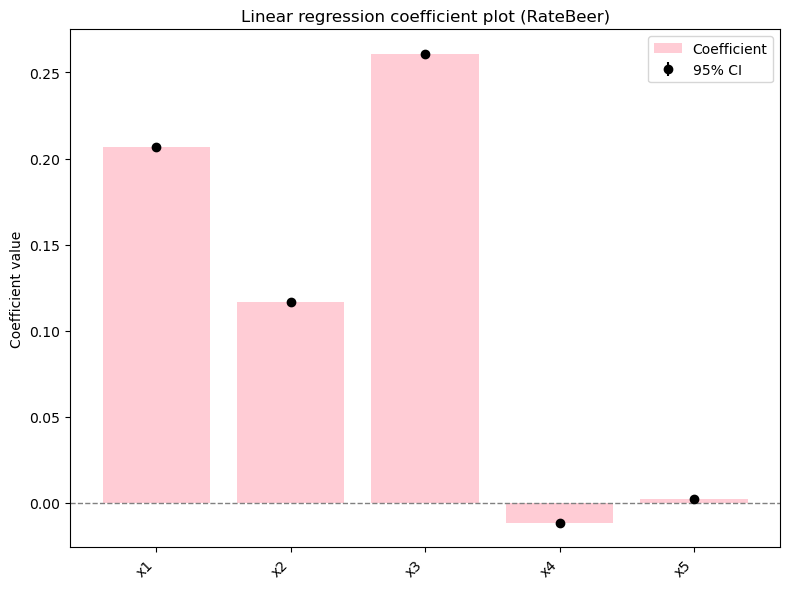

In [124]:
# extract coefficients and their confidence intervals from the model
coefficients_rb = model_rb.params
conf_int_rb = model_rb.conf_int()

# plot coefficients
plot_coefficients(coefficients_rb, conf_int_rb, "Linear regression coefficient plot (RateBeer)", bar_color='pink')

As seen in the output of the linear regression performed on the BeerAdvocate data, R2 is small, p-values of all coefficients are extremely low, coefficients corresponding to user experience levels are much smaller than the other coefficients. We again observe that the coefficient correponding to the expert experience level (x4) is negative and that the coefficient correponding to the new reviewer experience level (x5) is positive.

In this way, the linear regression analysis on both datasets a suggests that user experience levels significantly influence the final rating, as indicated by their small p-values. However, their effect size is smaller compared to factors like beer style, brewery reputation, and user generosity. The results imply that new reviewers are more generous, while expert reviewers are more critical, leading to lower ratings, but the overall influence of experience level on the final rating appears to be relatively subtle.

**Paired analysis**

In the second part of our analysis, we will conduct a paired study to examine how individual users’ ratings change as they gain experience. 

By comparing reviews from the same user, we can control for confounding factors related to user-specific characteristics. To further isolate the effect of experience on ratings, we will pair reviews with a "new reviewer" and an "expert" experience level within each user, matching them based on beer style and brewery, which may be confounders. We will then perform a one-tailed paired t-test to determine if ratings given by a user when they are a new reviewer are higher than those they give when they are an expert, as suggested by the previous results.

We will start by pairing reviews with 'new_reviewer' and 'expert' experience levels for the same user, style, and brewery.

In [137]:
# perform review matching
paired_reviews_ba = match_reviews(
    df= ba_ratings_with_experience_levels, 
    filter_column='experience_level', 
    group1_value='new_reviewer', 
    group2_value='expert', 
    join_columns=['user_id', 'style', 'brewery_id'], 
    suffixes=('_new', '_expert')
)

paired_reviews_rb = match_reviews(
    df= rb_ratings_with_experience_levels, 
    filter_column='experience_level', 
    group1_value='new_reviewer', 
    group2_value='expert', 
    join_columns=['user_id', 'style', 'brewery_id'], 
    suffixes=('_new', '_expert')
)

In [143]:
print('Number of matched reviews:')
print('BeerAdvocate:', paired_reviews_ba.shape[0])
print('RateBeer:', paired_reviews_rb.shape[0])

Number of matched reviews:
BeerAdvocate: 9213
RateBeer: 9352


We have more than 9 thousand distinct matched reviews for each dataset, which is not huge but seems large enough to perform our analysis.

We will now perform a one-tailed t-test to determine if ratings given by a user when they are a new reviewer are higher than those they give when they are an expert.

In [139]:
# one-tailed paired t-test on BeerAdvocate data
t_stat, p_value = ttest_rel(paired_reviews_ba['rating_new'], paired_reviews_ba['rating_expert'],alternative='greater')
print("Results of one-tailed paired t-test on BeerAdvocate data:")
print("t-statistic =", t_stat)
print("p-value =", p_value)

Results of one-tailed paired t-test on BeerAdvocate data:
t-statistic = 17.084707386247196
p-value = 9.430141591579247e-65


In [140]:
# one-tailed paired t-test on RateBeer data
t_stat, p_value = ttest_rel(paired_reviews_rb['rating_new'], paired_reviews_rb['rating_expert'],alternative='greater')
print("Results of one-tailed paired t-test on RateBeer data:")
print("t-statistic =", t_stat)
print("p-value =", p_value)

Results of one-tailed paired t-test on RateBeer data:
t-statistic = 8.08970963699974
p-value = 3.3629772546320747e-16


The one-tailed paired t-tests performed on both datasets yielded a positive test statistic and a very small p-value. This suggests that on average, the final rating given by a specific user to beers from the same brewery and with the same style is higher when the user is a new reviewer than when they have become an expert reviewer. These findings align with the results of the linear regression, which suggested that new reviewers are more generous, while expert reviewers are more critical.

The t-tests performed above evaluated the statistical significance of the mean difference in ratings between matched reviews. In order to get a better idea of the magnitude and distribution of the difference in ratings between matched reviews, we will plot a boxplot.

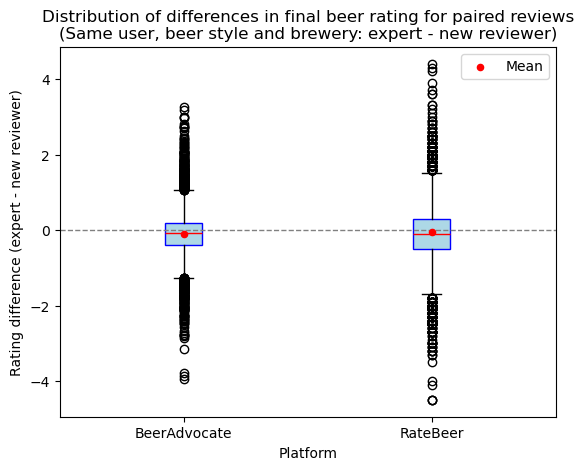

In [141]:
# calculate the difference in final rating within each pair of reviews
differences_ba = paired_reviews_ba['rating_expert'] - paired_reviews_ba['rating_new']
differences_rb = paired_reviews_rb['rating_expert'] - paired_reviews_rb['rating_new']

# plot a boxplot to show the ditribution of the differences
data = [differences_ba, differences_rb]
labels = ['BeerAdvocate', 'RateBeer']
means = [differences_ba.mean(), differences_rb.mean()]

plt.boxplot(data, labels=labels, patch_artist=True, boxprops=dict(facecolor="lightblue", color="blue"), medianprops=dict(color="red"))
plt.scatter([1, 2], means, color='red', marker='o', s=20, zorder=3, label='Mean')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
plt.title('Distribution of differences in final beer rating for paired reviews\n(Same user, beer style and brewery: expert - new reviewer)') 
plt.ylabel('Rating difference (expert - new reviewer)')
plt.xlabel('Platform')
plt.legend()
plt.show()
plt.close()

In [144]:
# explicitely calculate the mean differences
mean_diff_ba = differences_ba.mean()
mean_diff_rb = differences_rb.mean()
print("Mean Difference (BeerAdvocate):", mean_diff_ba)
print("Mean Difference (RateBeer)" ,mean_diff_rb)

Mean Difference (BeerAdvocate): -0.1004276565722349
Mean Difference (RateBeer) -0.06269247219846022


We observe that for both datasets, the mean difference is negative but very small and close to zero. In addition, there are many paired reviews where the expert review is associated with a much smallerfinal rating than the paired new reviewer review, as shown by the numerous data points with a large negative value for the difference. However, there are also some cases where the expert review has a much larger rating, leading to high positive values.

The t-tests performed previously detected a statistically significant difference, showing that new reviewers tend to give slightly higher ratings than expert reviewers on average. This significance is likely due to the large sample size, which can make even small and differences statistically significant.

The boxplots showed that the mean difference is close to zero in practical terms, with many extreme positive and negative differences balancing each other out. They revelade the high variability and the presence of outliers in rating differences, which are aspects that were not captured by the t-tests.

These results illustrate the difference between statistical and practical significance: while the t-tests demonstrate a statistically significant difference, the actual effect size (difference in final ratings between matched reviews) is small and not practically meaningful. New reviewers appear to be slightly more generous than experts on average, but the difference is minimal and likely negligible in practical terms.

**Conclusion**

Both the linear regression and the paired analysis concluded that the user’s experience level has a measurable effect on their ratings, with more experienced users tending to be slightly more critical. They both showed that while the difference in ratings across different experience levels is real and significant from a statistical perspective, it is numerically small. The small impact of experience level on ratings was shown by the relatively small coefficients of experience levels in the linear regression, and by the very small mean difference revealed by the paired analysis.

Thus, while user experience level has a detectable influence on ratings, it is not the dominant factor driving rating behavior. Other factors, such as beer style, brewery reputation, and user generosity, play a much larger role.